# Rank Abundance Curve Analysis

In this analysis, I will be applying the techniques outlined in Avolio et al.'s 2019 paper. I will be using the functions related to rank abundance curve analysis in the codyn software package in R.

WHAT QUESTIONS ARE YOU TRYING TO ANSWER?
- How is the plankton community changing over time?

HOW ARE YOU ANSWERING THEM WITH THIS APPROACH?
-sustained and frequent observations of plankton with automated flow cytometry
-rank abundance curve analysis

NOTE:
try and speak to the advantages RAC provides. What can we see with this method that can't with other ways of looking at community stability.

We need methods to bridge multivariate measures (too abstract and tricky to interpret wrt to community change) with community structure and composition.

- species evenness: relative abundance of species in a community
- species richness: number of species in a community


## What are rank abundance curves?

A rank abundance curve is plot of abundance rank (most abundant is 1st, second most is rank 2 and so forth) vs. species abundance.

5 things u can compare + quantify in an RAC
1. species richness --> length of the RAC
2. evenness --> slope of the RAC
3. species rank change --> how much species ranks decrease or increase over time
4. species loss
5. species gain

It would be great to make an RAC video of the RAC changing over the shelf - just as a visualization - to see the rank changing

In [1]:
# install.packages("codyn")

library("dplyr") #for wrangling dataframes
library("tidyr") #for wrangling dataframes
library("lubridate") # for working with dates
library("codyn") #for RAC functions
library("ggplot2")
library("zoo")
library("scales")

#vegan did not install:(


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## importing data from MVCO

The data are count/mL and biovolume/mL estimates for 144 species observed from 2006-2021 at the daily and hourly frequency by the Imaging Flow Cytobot. Images of plankton from IFCB were classified by a CNN.

Data includes datetime, mL analyzed, and the concentration for 144 species as well as extraneous observations e.g. bubble, debris.

Extraneous observations need to be filtered out.

NOTE: MAKE SURE YOU UPDATE PLANKTON RAC ANALYSIS

In [4]:
dfBv = read.csv('/D/MIT-WHOI/data/2021/biovol_concentration_by_class_time_series_CNN_daily08Sep2021.csv') #daily biovol concentration
str(dfBv)

#filtering out irrelevant data points
dfBv <- dfBv  %>% 
        select(-c("bead","fiber",
                  "camera_spot","detritus",
                  "detritus_clear",
                  "fiber_TAG_external_detritus" ,
                  "unknown2","square_unknown",
                  "mix","bubble","pollen","fecal_pellet"))
head(dfBv)
print(length(names(dfBv)))

## converting to long format
dfBv_long <- gather(dfBv,species,conc,Acanthoica_quattrospina:zooplankton,factor_key=TRUE)


dfBv_long$date = dmy_hms(as.character(dfBv_long$datetime))
dfBv_long$year = year(dfBv_long$date)
dfBv_long$month = month(dfBv_long$date)
dfBv_long$day = day(dfBv_long$date)
dfBv_long["mdy"] = paste0(dfBv_long$month,"_",dfBv_long$day,"_",dfBv_long$year)

head(dfBv_long)
print(length(dfBv_long$species))


dfBv_long<- dfBv_long %>% 
            drop_na() %>%
            filter_all( all_vars(. != 0)) %>% #removing rows with zero observations
            group_by(mdy,species) %>% #grouping by date and species
            summarize(conc.sum = sum(conc)) #summing overall concentration per species per day
head(dfBv_long)

'data.frame':	4278 obs. of  157 variables:
 $ datetime                                    : Factor w/ 4278 levels "01-Apr-2007 11:56:31",..: 782 924 1067 1207 1348 1491 1631 1772 1910 2051 ...
 $ milliliters_analyzed                        : num  53.3 244.1 202.8 145.1 169.4 ...
 $ Acanthoica_quattrospina                     : num  9.76 290.81 192.54 147.16 187.4 ...
 $ Akashiwo                                    : num  0 0 477 0 0 ...
 $ Alexandrium_catenella                       : num  0 345 348 0 0 ...
 $ Amphidinium                                 : num  0 52.2 35.7 34 40.8 ...
 $ Amylax                                      : num  0 63.5 140.3 0 147.9 ...
 $ Apedinella                                  : num  134 247 227 154 148 ...
 $ Asterionellopsis_glacialis                  : num  351 1158 551 1317 718 ...
 $ Bacillaria                                  : num  0 250 0 342 450 ...
 $ Bacillariophyceae                           : num  87.5 1212.9 4178.2 2939.5 1976.3 ...
 $ Bacte

datetime             milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 06-Jun-2006 21:26:01  53.2644               9.759605                0.000 
2 07-Jun-2006 11:58:20 244.0683             290.813132                0.000 
3 08-Jun-2006 12:30:33 202.7547             192.535218              477.219 
4 09-Jun-2006 07:29:59 145.0619             147.161169                0.000 
5 10-Jun-2006 15:24:26 169.4460             187.400310                0.000 
6 11-Jun-2006 11:57:42 245.2778             166.991430                0.000 
  Alexandrium_catenella Amphidinium Amylax    Apedinella
1   0.0000                0.00000     0.00000 134.46871 
2 345.0087               52.24687    63.48645 247.46123 
3 348.0239               35.73311   140.25489 227.19316 
4   0.0000               33.99913     0.00000 153.72953 
5   0.0000               40.79109   147.94894 147.80289 
6   0.0000              173.87111    24.18868  71.27988 
  Asterionellopsis_glacialis Bacillaria ⋯ cryptophyta flagellate
1  351.0845                    0.0000   ⋯   194.9936   7138.413 
2 1158.4849                  250.0361   ⋯ 10859.3231  27923.528 
3  551.2762                    0.0000   ⋯  8922.8682  25749.560 
4 1316.7792                  341.9177   ⋯ 10383.9361  20899.055 
5  718.0052                  450.3304   ⋯ 11972.9815  19977.209 
6 1348.6409                    0.0000   ⋯ 16445.7408  18592.018 
  flagellate_morphotype1 flagellate_morphotype3 pennate  
1   41.48348              486.2230               386.9074
2  456.57564              850.9299              2154.1844
3  517.69960             1465.1457              2375.6255
4  735.11284             1190.3039              3139.3134
5 1266.82804              945.0718              2955.0458
6  971.02212             1074.2562              3260.9844
  pennate_Pseudo.nitzschia pennate_Thalassionema pennate_morphotype1
1  0.000000                 0.00000                0.00000          
2 51.577795                33.81509              165.57660          
3 40.036551                18.73581               13.80714          
4 11.299711                 0.00000              899.71711          
5  9.252876                 0.00000              467.79779          
6 19.459239                 0.00000              301.62626          
  shellfish_larvae zooplankton
1    0.000          4083.289  
2    0.000          1744.340  
3    0.000         11062.726  
4 2357.634          3702.001  
5    0.000          6337.449  
6 1271.393         12028.249

[1] 145


datetime             milliliters_analyzed species                 conc      
1 06-Jun-2006 21:26:01  53.2644             Acanthoica_quattrospina   9.759605
2 07-Jun-2006 11:58:20 244.0683             Acanthoica_quattrospina 290.813132
3 08-Jun-2006 12:30:33 202.7547             Acanthoica_quattrospina 192.535218
4 09-Jun-2006 07:29:59 145.0619             Acanthoica_quattrospina 147.161169
5 10-Jun-2006 15:24:26 169.4460             Acanthoica_quattrospina 187.400310
6 11-Jun-2006 11:57:42 245.2778             Acanthoica_quattrospina 166.991430
  date                year month day mdy      
1 2006-06-06 21:26:01 2006 6      6  6_6_2006 
2 2006-06-07 11:58:20 2006 6      7  6_7_2006 
3 2006-06-08 12:30:33 2006 6      8  6_8_2006 
4 2006-06-09 07:29:59 2006 6      9  6_9_2006 
5 2006-06-10 15:24:26 2006 6     10  6_10_2006
6 2006-06-11 11:57:42 2006 6     11  6_11_2006

[1] 611754


`summarise()` has grouped output by 'mdy'. You can override using the `.groups` argument.



mdy      species                    conc.sum  
1 1_1_2007 Acanthoica_quattrospina     209.13259
2 1_1_2007 Amphidinium                 116.28988
3 1_1_2007 Amylax                       94.46878
4 1_1_2007 Apedinella                  528.39997
5 1_1_2007 Asterionellopsis_glacialis 8626.67625
6 1_1_2007 Balanion                   1332.70809

In [2]:
dfConc = read.csv('/D/MIT-WHOI/data/2021/concentration_by_class_time_series_CNN_daily08Sep2021.csv') #daily biovol concentration

#filtering out irrelevant columns
dfConc <- dfConc  %>% select(-c("bead","fiber","camera_spot","detritus","detritus_clear","fiber_TAG_external_detritus" ,"unknown2","square_unknown","mix","bubble","pollen","fecal_pellet"))


#converting to long format
dfConc_long <- gather(dfConc,species,conc,Acanthoica_quattrospina:zooplankton,factor_key=TRUE)

dfConc_long$date = dmy_hms(as.character(dfConc_long$datetime))
dfConc_long$year = year(dfConc_long$date)
dfConc_long$month = month(dfConc_long$date)
dfConc_long$day = day(dfConc_long$date)
dfConc_long["mdy"] = paste0(dfConc_long$month,"_",dfConc_long$day,"_",dfConc_long$year)

dfConc_long <- dfConc_long %>% 
            drop_na() %>%
            filter_all( all_vars(. != 0)) %>%
            group_by(mdy,species) %>%
            summarize(conc.sum = sum(conc))


`summarise()` has grouped output by 'mdy'. You can override using the `.groups` argument.



In [3]:
#aggregate by month
dfConc = read.csv('/D/MIT-WHOI/data/2021/concentration_by_class_time_series_CNN_daily08Sep2021.csv') #daily biovol concentration

#filtering out irrelevant columns
dfConc <- dfConc  %>% select(-c("bead","fiber","camera_spot","detritus","detritus_clear","fiber_TAG_external_detritus" ,"unknown2","square_unknown","mix","bubble","pollen","fecal_pellet"))

head(dfConc)

#converting to long format
dfConc_long <- gather(dfConc,species,conc,Acanthoica_quattrospina:zooplankton,factor_key=TRUE)

dfConc_long$date = dmy_hms(as.character(dfConc_long$datetime))
dfConc_long$year = year(dfConc_long$date)
dfConc_long$month = month(dfConc_long$date)
dfConc_long$day = day(dfConc_long$date)
dfConc_long["my"] = paste0(dfConc_long$month,"_",dfConc_long$year)
dfConc_long$week = week(dfConc_long$date)
dfConc_long$wy = paste0(dfConc_long$week,"_",dfConc_long$year)

head(dfConc_long)
dfConc_long <- dfConc_long %>% 
            drop_na() %>%
            filter_all( all_vars(. != 0)) %>%
            group_by(my,species)

dfConc_long$count <- dfConc_long$conc * dfConc_long$milliliters_analyzed

dfConc_long <- dfConc_long %>% 
                summarize(my.conc = (sum(count)/sum(milliliters_analyzed)))

head(dfConc_long)
# str(dfConc_long)


datetime             milliliters_analyzed Acanthoica_quattrospina Akashiwo   
1 06-Jun-2006 21:26:01  53.2644             0.01877427              0.000000000
2 07-Jun-2006 11:58:20 244.0683             0.68833202              0.000000000
3 08-Jun-2006 12:30:33 202.7547             0.50800296              0.004932068
4 09-Jun-2006 07:29:59 145.0619             0.36536123              0.000000000
5 10-Jun-2006 15:24:26 169.4460             0.44261885              0.000000000
6 11-Jun-2006 11:57:42 245.2778             0.43216298              0.000000000
  Alexandrium_catenella Amphidinium Amylax      Apedinella
1 0.000000000           0.000000000 0.000000000 0.1126456 
2 0.020486072           0.020486072 0.008194429 0.3892354 
3 0.004932068           0.004932068 0.014796203 0.4488182 
4 0.000000000           0.013787216 0.000000000 0.2550635 
5 0.000000000           0.011803169 0.017704754 0.2655713 
6 0.000000000           0.020385046 0.004077009 0.1386183 
  Asterionellopsis_glacialis Bacillaria  ⋯ cryptophyta flagellate
1 0.05632280                 0.000000000 ⋯  0.4130339  19.33749  
2 0.24583286                 0.004097214 ⋯ 29.2786941  76.08937  
3 0.17262237                 0.000000000 ⋯ 24.8625528  73.44835  
4 0.08961691                 0.006893608 ⋯ 28.4774952  57.45133  
5 0.12393328                 0.005901585 ⋯ 30.6587325  48.91824  
6 0.18346541                 0.000000000 ⋯ 43.1755276  48.14540  
  flagellate_morphotype1 flagellate_morphotype3 pennate  
1 0.01877427             2.196589               0.6195508
2 0.36465208             4.445478               3.4949239
3 0.38470127             8.187232               4.2366461
4 0.54459504             6.342119               4.8806746
5 0.83802503             5.417655               4.9632327
6 0.72163063             6.013589               5.7322750
  pennate_Pseudo.nitzschia pennate_Thalassionema pennate_morphotype1
1 0.00000000               0.000000000           0.000000000        
2 0.09423593               0.004097214           0.004097214        
3 0.07398101               0.009864135           0.004932068        
4 0.02068082               0.000000000           0.041361649        
5 0.01770475               0.000000000           0.011803169        
6 0.03261607               0.000000000           0.020385046        
  shellfish_larvae zooplankton
1 0.000000000      0.018774267
2 0.000000000      0.008194429
3 0.000000000      0.024660338
4 0.006893608      0.006893608
5 0.000000000      0.005901585
6 0.004077009      0.032616074

datetime             milliliters_analyzed species                 conc      
1 06-Jun-2006 21:26:01  53.2644             Acanthoica_quattrospina 0.01877427
2 07-Jun-2006 11:58:20 244.0683             Acanthoica_quattrospina 0.68833202
3 08-Jun-2006 12:30:33 202.7547             Acanthoica_quattrospina 0.50800296
4 09-Jun-2006 07:29:59 145.0619             Acanthoica_quattrospina 0.36536123
5 10-Jun-2006 15:24:26 169.4460             Acanthoica_quattrospina 0.44261885
6 11-Jun-2006 11:57:42 245.2778             Acanthoica_quattrospina 0.43216298
  date                year month day my     week wy     
1 2006-06-06 21:26:01 2006 6      6  6_2006 23   23_2006
2 2006-06-07 11:58:20 2006 6      7  6_2006 23   23_2006
3 2006-06-08 12:30:33 2006 6      8  6_2006 23   23_2006
4 2006-06-09 07:29:59 2006 6      9  6_2006 23   23_2006
5 2006-06-10 15:24:26 2006 6     10  6_2006 23   23_2006
6 2006-06-11 11:57:42 2006 6     11  6_2006 24   24_2006

`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.



my     species                    my.conc    
1 1_2007 Acanthoica_quattrospina    0.257439668
2 1_2007 Alexandrium_catenella      0.004306486
3 1_2007 Amphidinium                0.022003390
4 1_2007 Amylax                     0.011375139
5 1_2007 Apedinella                 0.435537699
6 1_2007 Asterionellopsis_glacialis 0.173651075

In [20]:
#aggregate by week of a given year
dfConc = read.csv('/D/MIT-WHOI/data/2021/concentration_by_class_time_series_CNN_daily08Sep2021.csv') #daily biovol concentration

#filtering out irrelevant columns
dfConc <- dfConc  %>% select(-c("bead","fiber","camera_spot","detritus","detritus_clear","fiber_TAG_external_detritus" ,"unknown2","square_unknown","mix","bubble","pollen","fecal_pellet"))

# head(dfConc)

#converting to long format
dfConc_long <- gather(dfConc,species,conc,Acanthoica_quattrospina:zooplankton,factor_key=TRUE)

dfConc_long$date = dmy_hms(as.character(dfConc_long$datetime))
dfConc_long$year = year(dfConc_long$date)
dfConc_long$month = month(dfConc_long$date)
dfConc_long$day = day(dfConc_long$date)
dfConc_long["my"] = paste0(dfConc_long$month,"_",dfConc_long$year)
dfConc_long$week = week(dfConc_long$date)
dfConc_long$wy = paste0(dfConc_long$week,"_",dfConc_long$year)

head(dfConc_long)
dfConc_long <- dfConc_long %>% 
            drop_na() %>%
            filter_all( all_vars(. != 0)) %>%
            group_by(wy,species)

dfConc_long$count <- dfConc_long$conc * dfConc_long$milliliters_analyzed

dfConc_long <- dfConc_long %>% 
                summarize(wy.conc = (sum(count)/sum(milliliters_analyzed)))

head(dfConc_long)
# count(dfConc_long)
# str(dfConc_long)


datetime             milliliters_analyzed species                 conc      
1 06-Jun-2006 21:26:01  53.2644             Acanthoica_quattrospina 0.01877427
2 07-Jun-2006 11:58:20 244.0683             Acanthoica_quattrospina 0.68833202
3 08-Jun-2006 12:30:33 202.7547             Acanthoica_quattrospina 0.50800296
4 09-Jun-2006 07:29:59 145.0619             Acanthoica_quattrospina 0.36536123
5 10-Jun-2006 15:24:26 169.4460             Acanthoica_quattrospina 0.44261885
6 11-Jun-2006 11:57:42 245.2778             Acanthoica_quattrospina 0.43216298
  date                year month day my     week wy     
1 2006-06-06 21:26:01 2006 6      6  6_2006 23   23_2006
2 2006-06-07 11:58:20 2006 6      7  6_2006 23   23_2006
3 2006-06-08 12:30:33 2006 6      8  6_2006 23   23_2006
4 2006-06-09 07:29:59 2006 6      9  6_2006 23   23_2006
5 2006-06-10 15:24:26 2006 6     10  6_2006 23   23_2006
6 2006-06-11 11:57:42 2006 6     11  6_2006 24   24_2006

`summarise()` has grouped output by 'wy'. You can override using the `.groups` argument.



wy     species                    wy.conc    
1 1_2007 Acanthoica_quattrospina    0.305915655
2 1_2007 Alexandrium_catenella      0.007487408
3 1_2007 Amphidinium                0.025235467
4 1_2007 Amylax                     0.016876077
5 1_2007 Apedinella                 0.409947578
6 1_2007 Asterionellopsis_glacialis 0.308490703

### species sorted by functional groups

In [5]:
#reading in long format of dataframe with just sorted functional groups
dfFunc_long= read.csv("/D/MIT-WHOI/github_repos/plankton-index/df_daily_long.txt",sep = " ")

dfFunc_long["datetime"] = dmy_hms(as.character(dfFunc_long$datetime))
dfFunc_long["day"] = as.numeric(day(dfFunc_long$datetime))
dfFunc_long$year = as.numeric(year(dfFunc_long$datetime))
dfFunc_long["month"] = as.numeric(month(dfFunc_long$datetime))
dfFunc_long["mdy"] = paste0(dfFunc_long$month,"_",dfFunc_long$day,"_",dfFunc_long$year)

head(dfFunc_long)
dfFunc_long <- dfFunc_long %>%
                    filter(!((group == "IFCB artifact")|(group == "Other live")|(group == "Other not alive")) )%>%
                    drop_na() %>%
                    filter_all( all_vars(. != 0)) %>%
                    group_by(mdy,group) %>% 
                    summarize(bvsum = sum(biovol.mL))
print(dfFunc_long[dfFunc_long["mdy"]=="1_1_2007",])


datetime            group           biovol.mL  day year month mdy     
1 2006-06-06 21:26:01 Coccolithophore   9.759605 6   2006 6     6_6_2006
2 2006-06-06 21:26:01 Nano              9.759605 6   2006 6     6_6_2006
3 2006-06-07 11:58:20 Coccolithophore 290.813132 7   2006 6     6_7_2006
4 2006-06-07 11:58:20 Nano            290.813132 7   2006 6     6_7_2006
5 2006-06-08 12:30:33 Coccolithophore 192.535218 8   2006 6     6_8_2006
6 2006-06-08 12:30:33 Nano            192.535218 8   2006 6     6_8_2006

`summarise()` has grouped output by 'mdy'. You can override using the `.groups` argument.



# A tibble: 8 × 3
# Groups:   mdy [1]
  mdy      group               bvsum
  <chr>    <fct>               <dbl>
1 1_1_2007 ""                   123.
2 1_1_2007 "Ciliate"         105709.
3 1_1_2007 "Coccolithophore"   1786.
4 1_1_2007 "Diatom"          822169.
5 1_1_2007 "Dinoflagellate"   35218.
6 1_1_2007 "flagellate"       52053.
7 1_1_2007 "Nano"              2420.
8 1_1_2007 "pennatediatom"    42685.


In [19]:
#loading in functional group time series in short format
df_short = read.csv('/D/MIT-WHOI/data/2021/df_short.csv',sep = ",")

head(df_short)

datetime            Ciliate   Coccolithophore Diatom   Dinoflagellate
1 2007-04-01 00:28:14  709.3214  93.44487       12002.19 2157.252      
2 2007-04-01 01:22:34 1247.3074 113.91439       24331.02 3934.494      
3 2007-04-01 02:27:47 3507.6317 182.88740       27352.18 3242.391      
4 2007-04-01 03:33:02 3780.9450 235.35671       23526.83 3326.214      
5 2007-04-01 04:27:21 1926.0687 130.89181       27207.96 3470.655      
6 2007-04-01 05:21:43 3964.0301 344.98361       30548.18 4056.734      
  IFCB.artifact Nano      Other.live Other.not.alive flagellate pennatediatom
1  49.37423      810.6801  1297.0477 6219.874        1169.330   1598.6325    
2 425.17350     5884.2299 25432.0810 8790.613        4432.410   1293.7470    
3 554.43073     7561.7284 20241.8640 3524.367        6278.653   1875.1887    
4 687.77718     7602.6864   321.6584 3334.468        6025.515    762.9971    
5 906.48885     8728.3185   793.5578 5252.780        7052.399    648.8277    
6 525.13958     8865.6599   435.8745 3881.340        7667.204   1519.7931

# Intra-Functional Group Analysis

Within each functional group, how are the species changing?

### extracting species that make up the functional groups

In [4]:
#loading in class list file that maps species to their respective functional groups
cl =  read.csv('/D/MIT-WHOI/data/2021/IFCB_classlist_type.csv') #importing 
head(cl)

dia = cl[cl$Diatom == 1,]$CNN_classlist
pens = cl[cl$pennatediatom == 1,]$CNN_classlist
dinos = cl[cl$Dinoflagellate == 1,]$CNN_classlist
cocco = cl[cl$Coccolithophore == 1,]$CNN_classlist
cils = cl[cl$Ciliate == 1,]$CNN_classlist
fla = cl[cl$flagellate == 1,]$CNN_classlist
nano = cl[cl$Nano == 1,]$CNN_classlist

print(paste("diatoms",length(dia)))
length(dinos)
length(pens)
length(cocco)
length(cils)
length(fla)
length(nano)

head(dia)

CNN_classlist                                Diatom pennatediatom
1 Chaetoceros_tenuissimus                      1      0            
2 Cylindrotheca_min                            1      1            
3 Eucampia_morphytype1                         1      0            
4 Guinardia_delicatula_TAG_Amphidinium_grazing 1      0            
5 Hemiaulus_membranaceus                       1      0            
6 pennate_Pseudo_nitzschia                     1      1            
  Dinoflagellate Coccolithophore Ciliate flagellate Nano Other.live
1 0              0               0       0          0    0         
2 0              0               0       0          0    0         
3 0              0               0       0          0    0         
4 0              0               0       0          0    0         
5 0              0               0       0          0    0         
6 0              0               0       0          0    0         
  Other.not.alive IFCB.artifact
1 0               0            
2 0               0            
3 0               0            
4 0               0            
5 0               0            
6 0               0

[1] "diatoms 63"


[1] 55

[1] 147

[1] 8

[1] 30

[1] 16

[1] 17

[1] Chaetoceros_tenuissimus                     
[2] Cylindrotheca_min                           
[3] Eucampia_morphytype1                        
[4] Guinardia_delicatula_TAG_Amphidinium_grazing
[5] Hemiaulus_membranaceus                      
[6] pennate_Pseudo_nitzschia                    
198 Levels: Acanthoica_quattrospina Akashiwo ... zooplankton


1. The Diatom Functional Group

In [5]:
dataframe = dfConc
dia_col = which(colnames(dataframe) %in% dia)
pen_col = which(colnames(dataframe) %in% pens)
coc_col = which(colnames(dataframe) %in% cocco)
cil_col = which(colnames(dataframe) %in% cils)
fla_col = which(colnames(dataframe) %in% fla)
nan_col = which(colnames(dataframe) %in% nano)

## Diatoms

[1] 226734


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.



my     species                    my.conc    
1 1_2007 Asterionellopsis_glacialis 0.173651075
2 1_2007 Bacillariophyceae          3.048763896
3 1_2007 Bacteriastrum              0.003573324
4 1_2007 Biddulphia                 0.138166986
5 1_2007 Cerataulina_pelagica       0.328497676
6 1_2007 Chaetoceros                3.209776941

[1] "integer"

my     my2    richness_change evenness_change rank_change gains     
1 1_2007 1_2008  0.01923077     -0.010432644    0.12167160  0.01923077
2 1_2008 1_2009  0.01886792      0.011931610    0.09576362  0.01886792
3 1_2009 1_2010  0.00000000     -0.003609663    0.08187967  0.00000000
4 1_2010 1_2011  0.00000000     -0.010501750    0.10964756  0.00000000
5 1_2011 1_2012  0.00000000     -0.007415621    0.11249555  0.00000000
6 1_2012 1_2013 -0.03773585      0.007327807    0.13207547  0.00000000
  losses     monthyear 
1 0.00000000 2007-01-01
2 0.00000000 2008-01-01
3 0.00000000 2009-01-01
4 0.00000000 2010-01-01
5 0.00000000 2011-01-01
6 0.03773585 2012-01-01

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


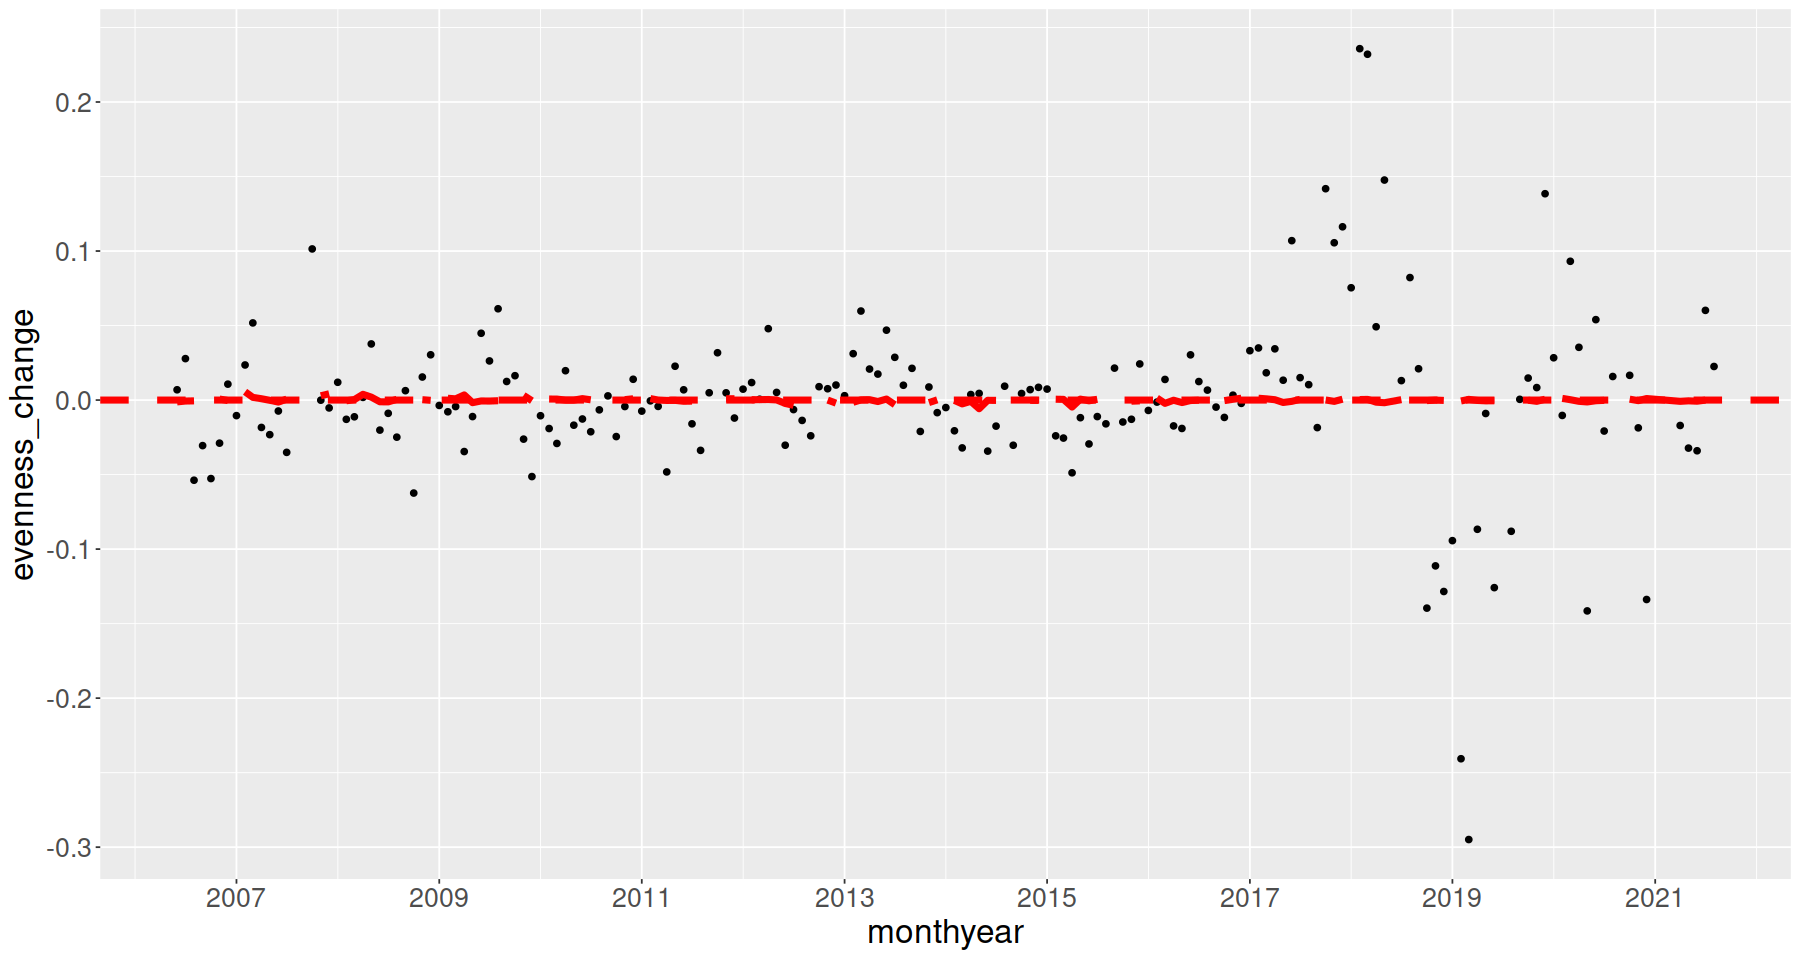

Warning message:
“Removed 4 rows containing missing values (geom_point).”


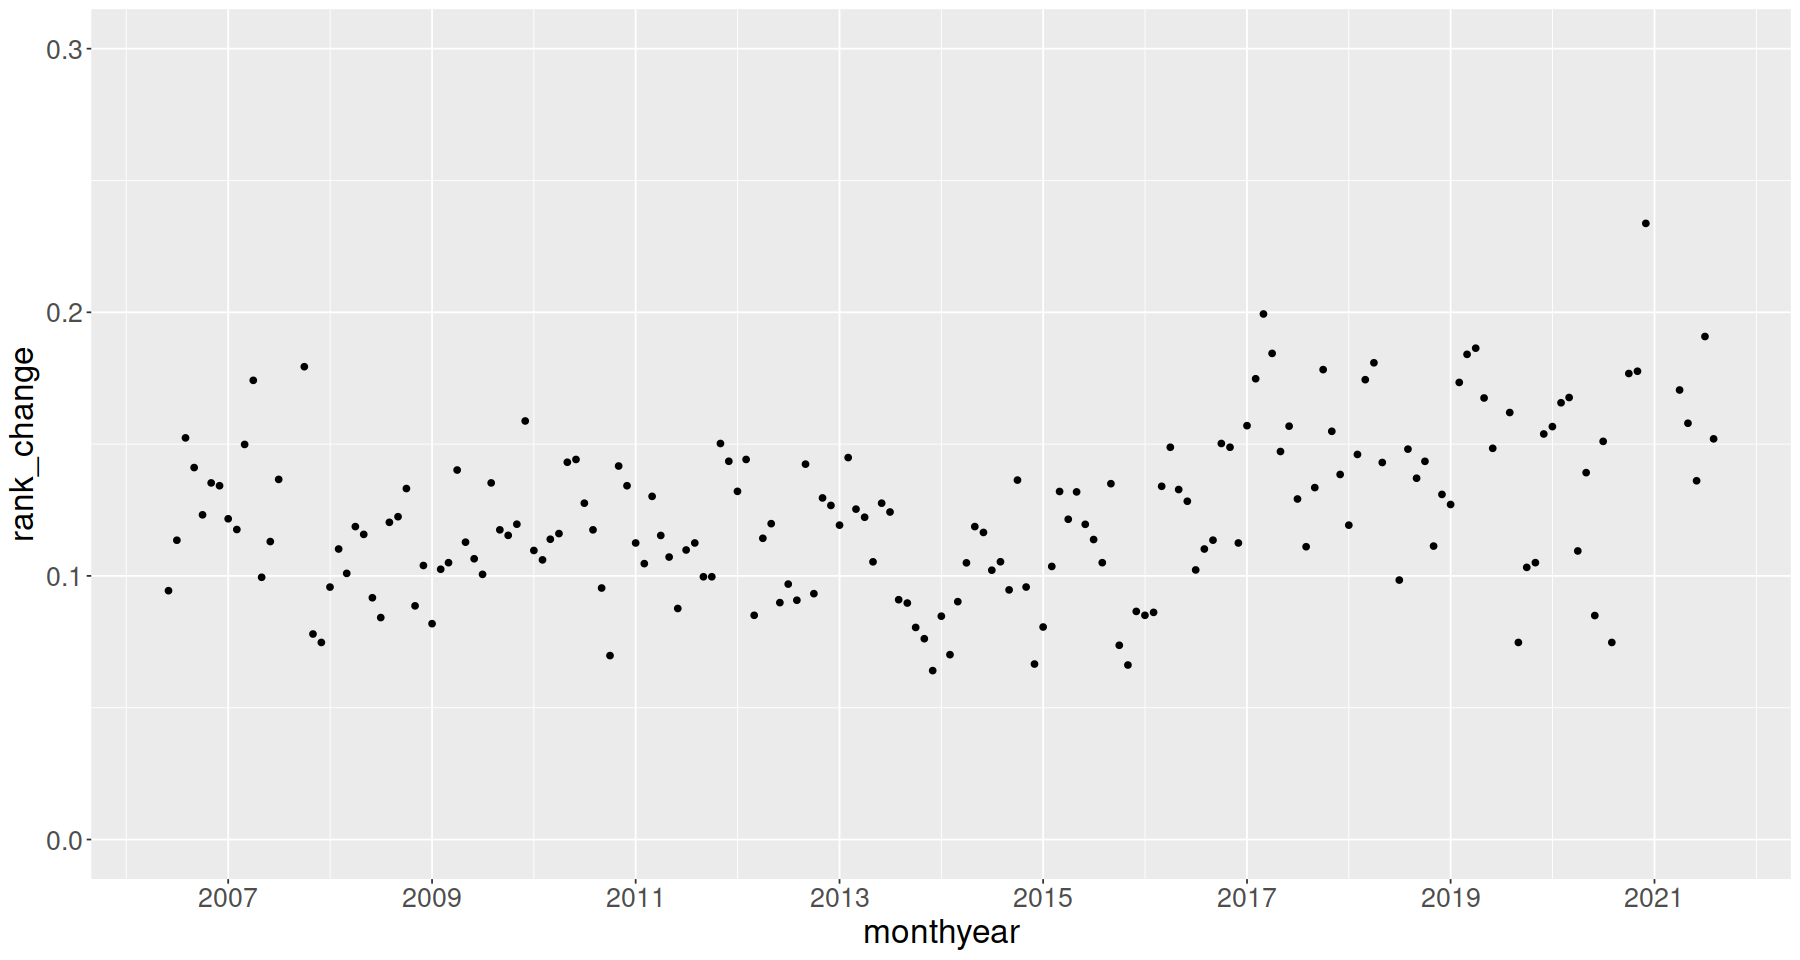

Warning message:
“Removed 6 rows containing missing values (geom_point).”


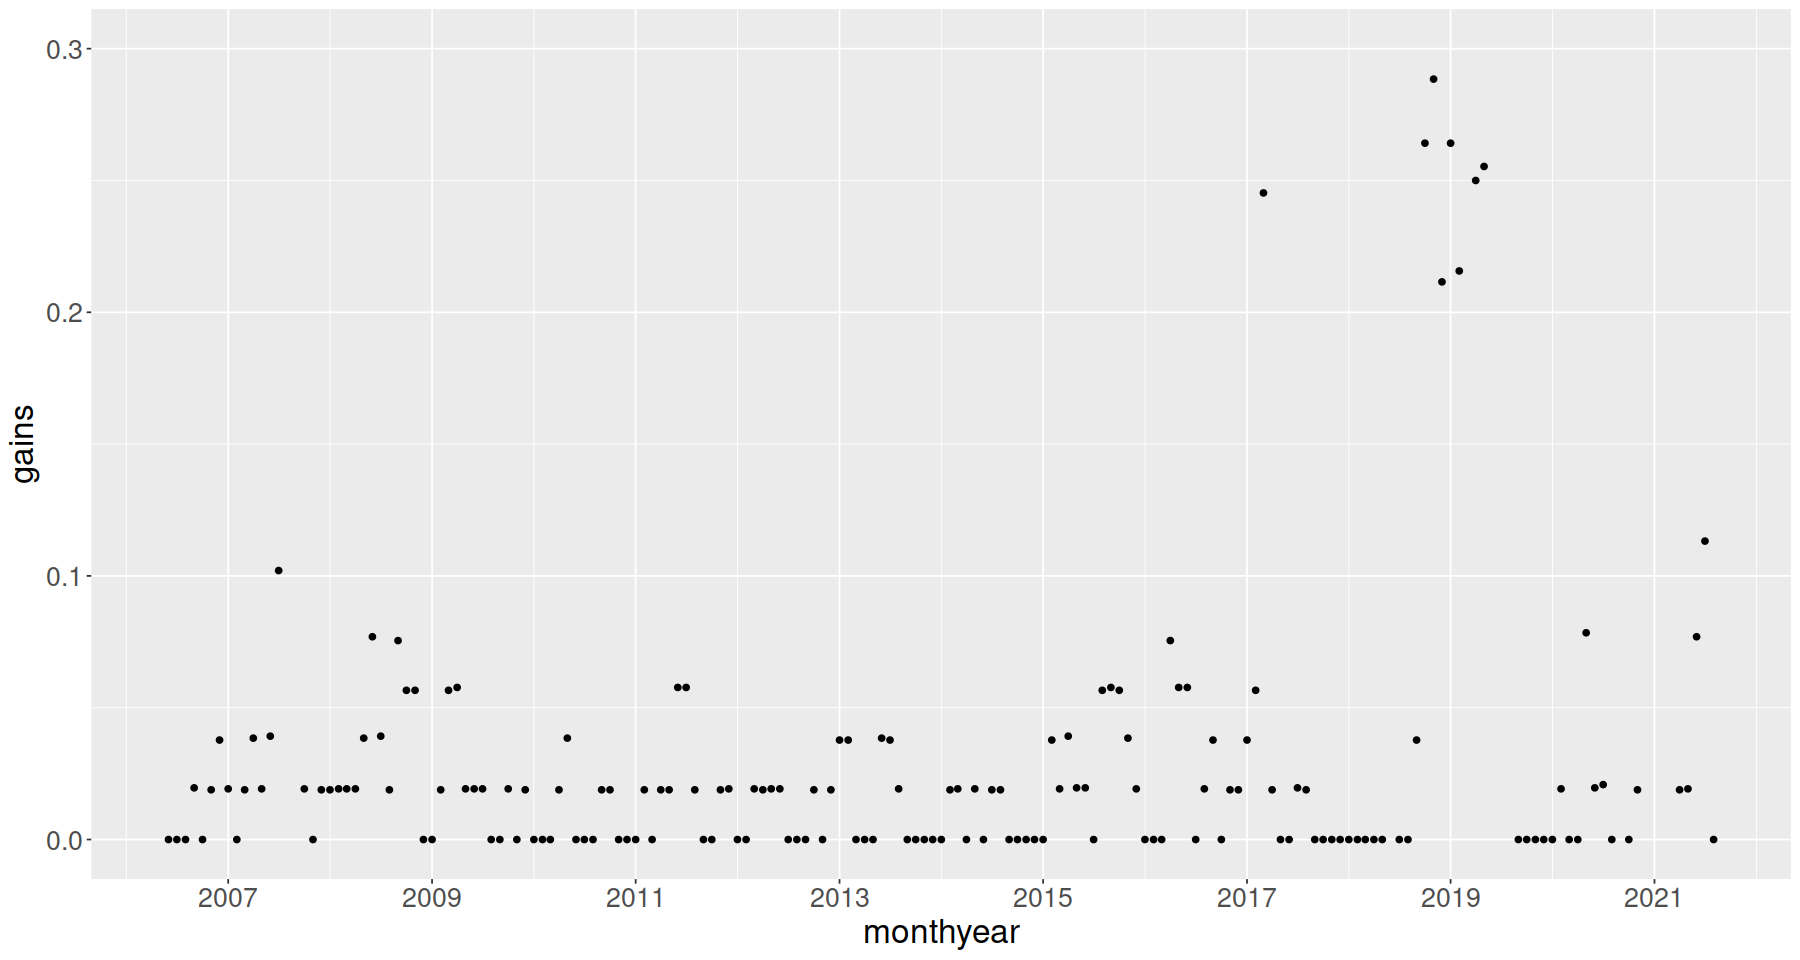

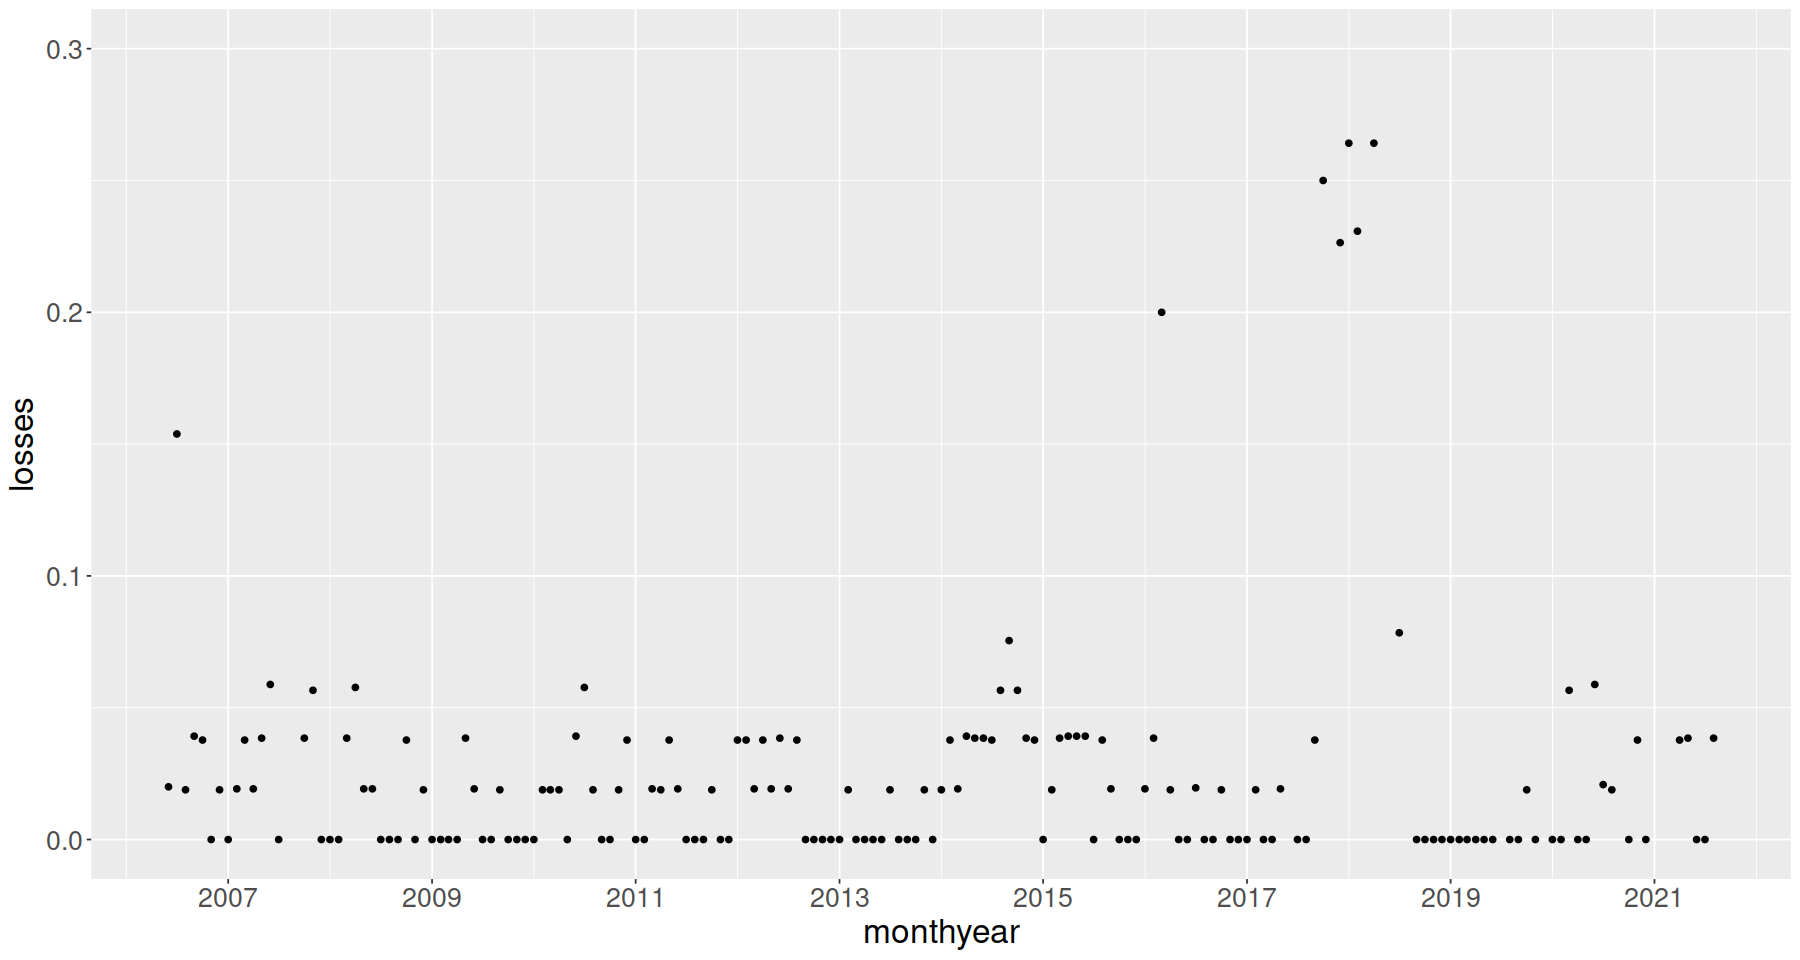

In [11]:
# converting to long format
# head(dfConc)
df.dia <- dfConc[,c(1,2,dia_col)] # isolating just the diatom group

# head(df.dia)

#converting from wide to long format 
df.dia.long <- gather(df.dia,species,conc,as.character(colnames(df.dia)[3]):as.character(colnames(df.dia)[length(df.dia)]),factor_key=TRUE)

df.dia.long$date = dmy_hms(as.character(df.dia.long$datetime))
df.dia.long$year = year(df.dia.long$date)
df.dia.long$month = month(df.dia.long$date)
df.dia.long$day = day(df.dia.long$date)
df.dia.long["mdy"] = paste0(df.dia.long$month,"_",df.dia.long$day,"_",df.dia.long$year)
df.dia.long["my"] = paste0(df.dia.long$month,"_",df.dia.long$year)

# head(df.dia.long)
print(length(df.dia.long$species))

df.dia.long<- df.dia.long %>% 
            drop_na() %>%
            filter_all( all_vars(. != 0)) %>%
            group_by(my,species)

# head(df.dia.long)

df.dia.long$count <- df.dia.long$conc * df.dia.long$milliliters_analyzed

df.dia.long <- df.dia.long %>% 
                summarize(my.conc = (sum(count)/sum(milliliters_analyzed)))

head(df.dia.long)

dfrm <- RAC_change(df = df.dia.long, 
           species.var = "species",
           abundance.var = "my.conc",
           time.var ="my")

dfrm$monthyear = as.Date(my(dfrm$my),format = "%Y-%m-%d")
typeof(dfrm$my)
head(dfrm)

options(repr.plot.width=15, repr.plot.height=8)


# plotting evenness change
ggplot(data = dfrm,aes(x = monthyear, y = evenness_change)) +
geom_point()+
geom_hline(yintercept = 0,
           linetype = "dashed",
           color = "red",
           size = 2)+
    theme(text = element_text(size=20))+
  geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = rank_change)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = gains)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = losses)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)

## Pennate Diatoms

[1] 47058


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


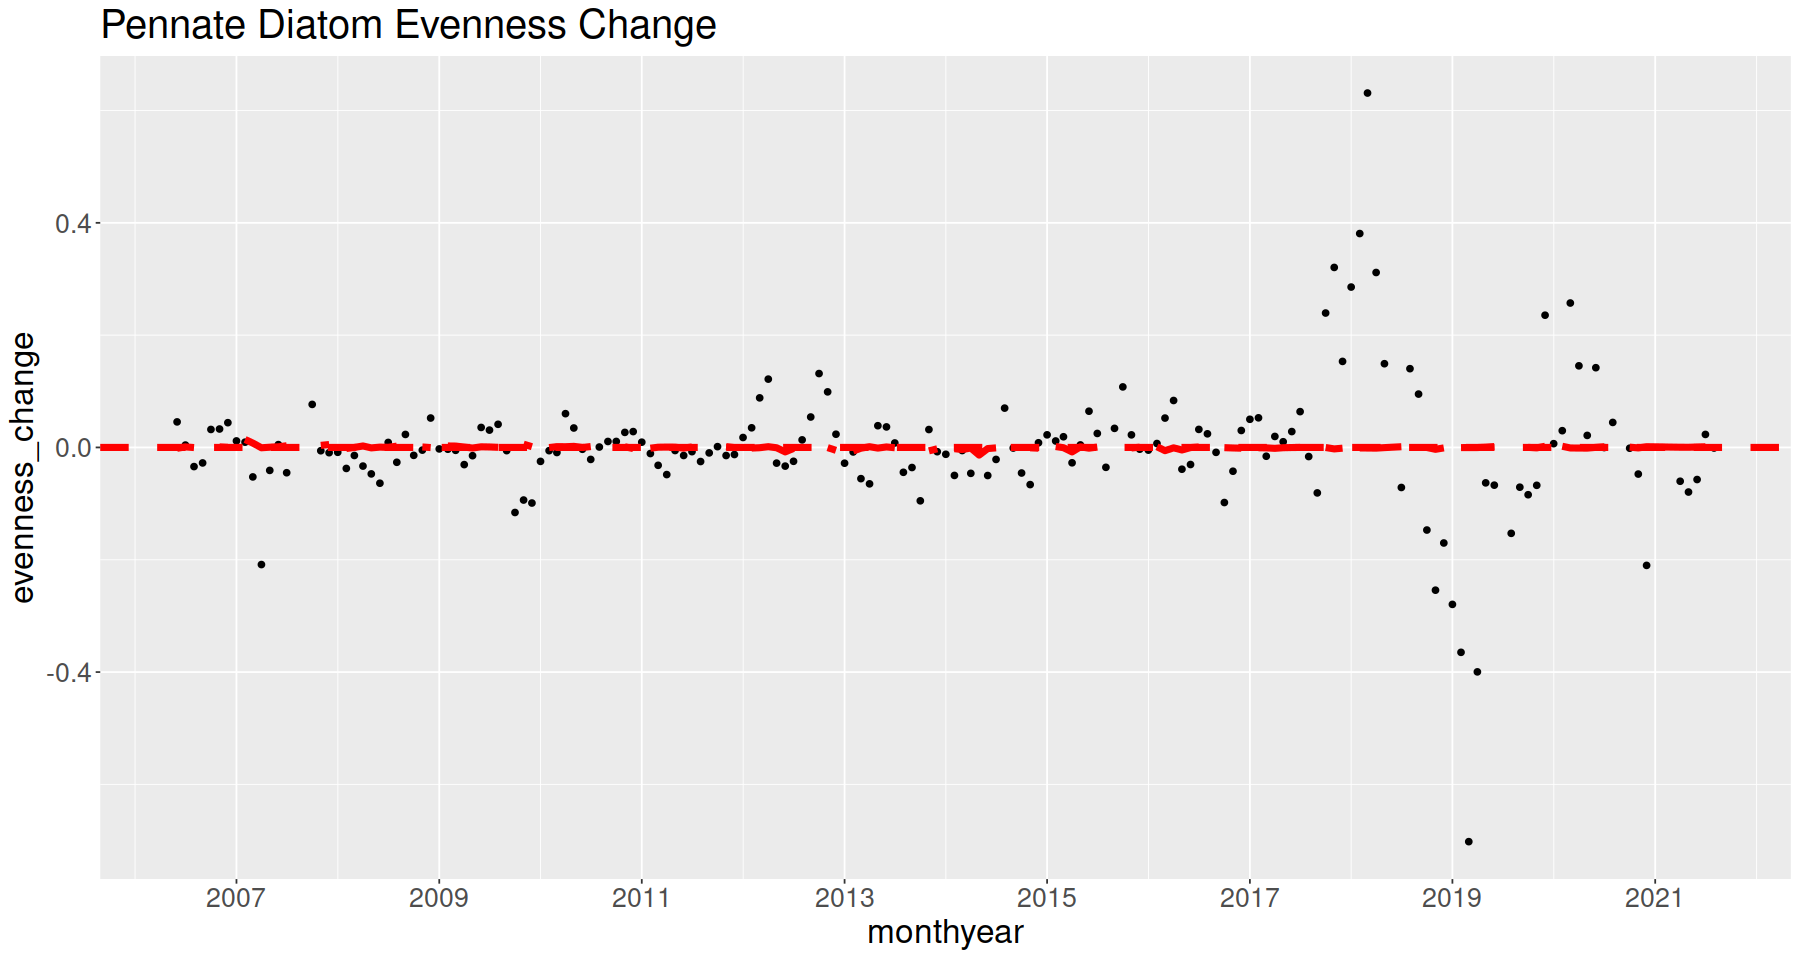

Warning message:
“Removed 9 rows containing missing values (geom_point).”


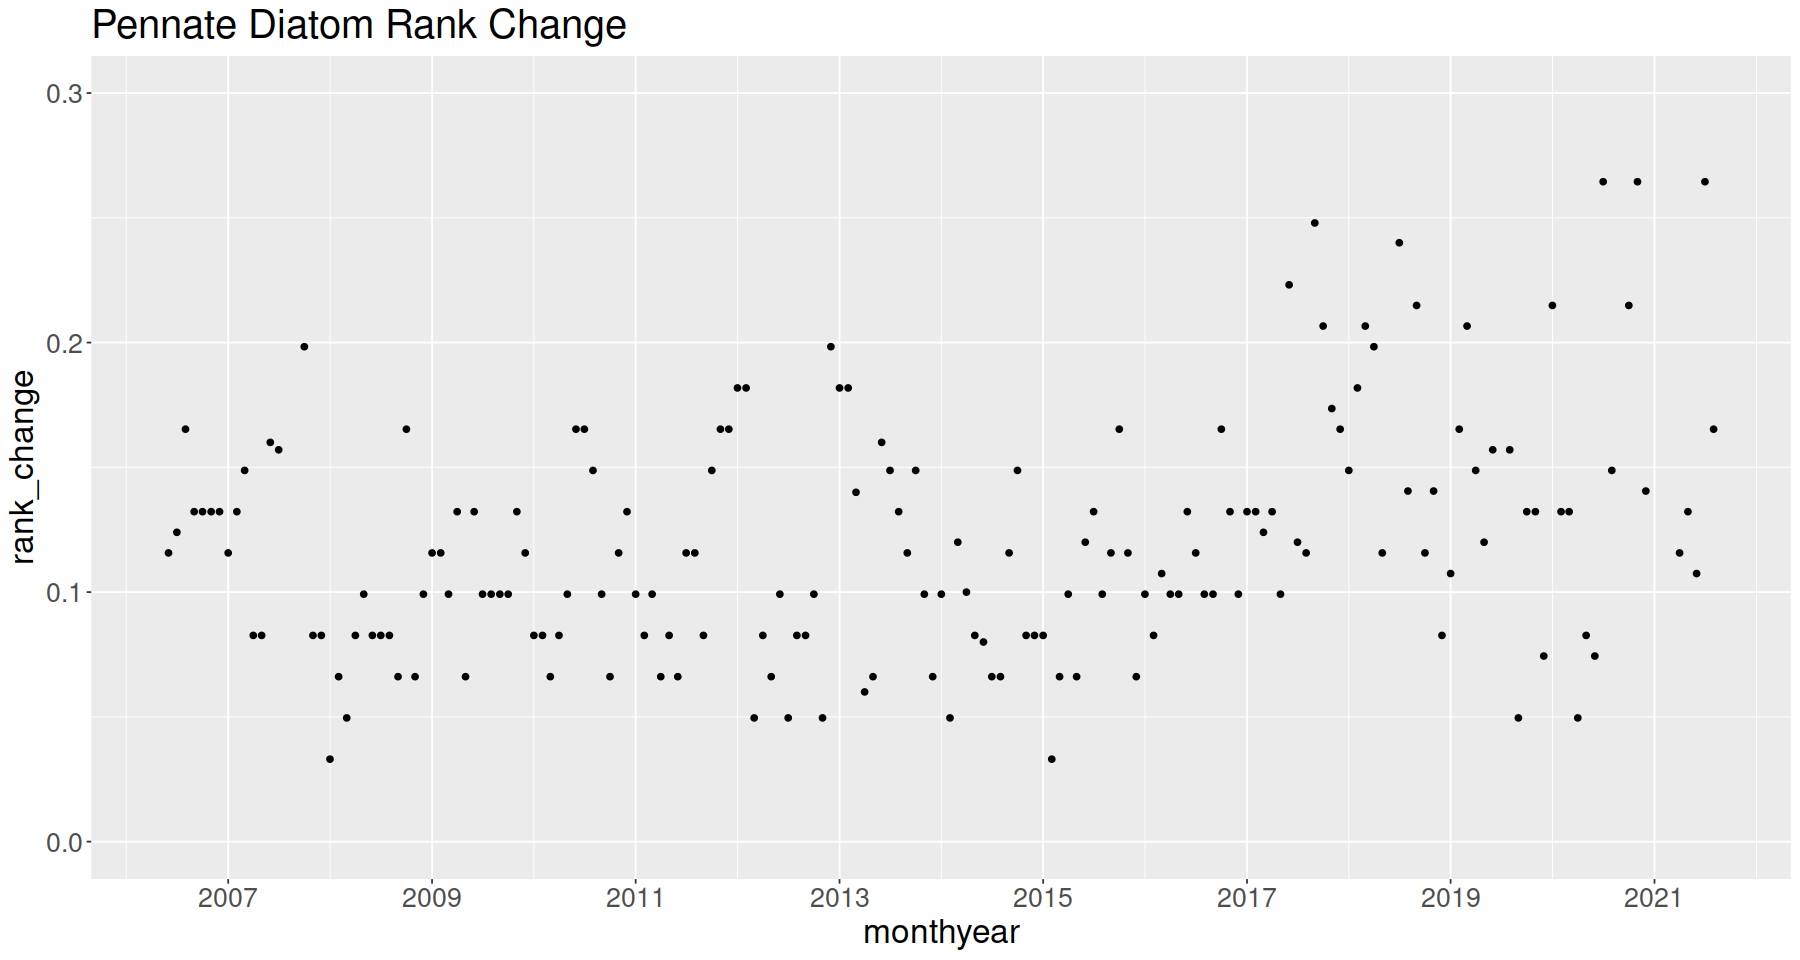

Warning message:
“Removed 9 rows containing missing values (geom_point).”


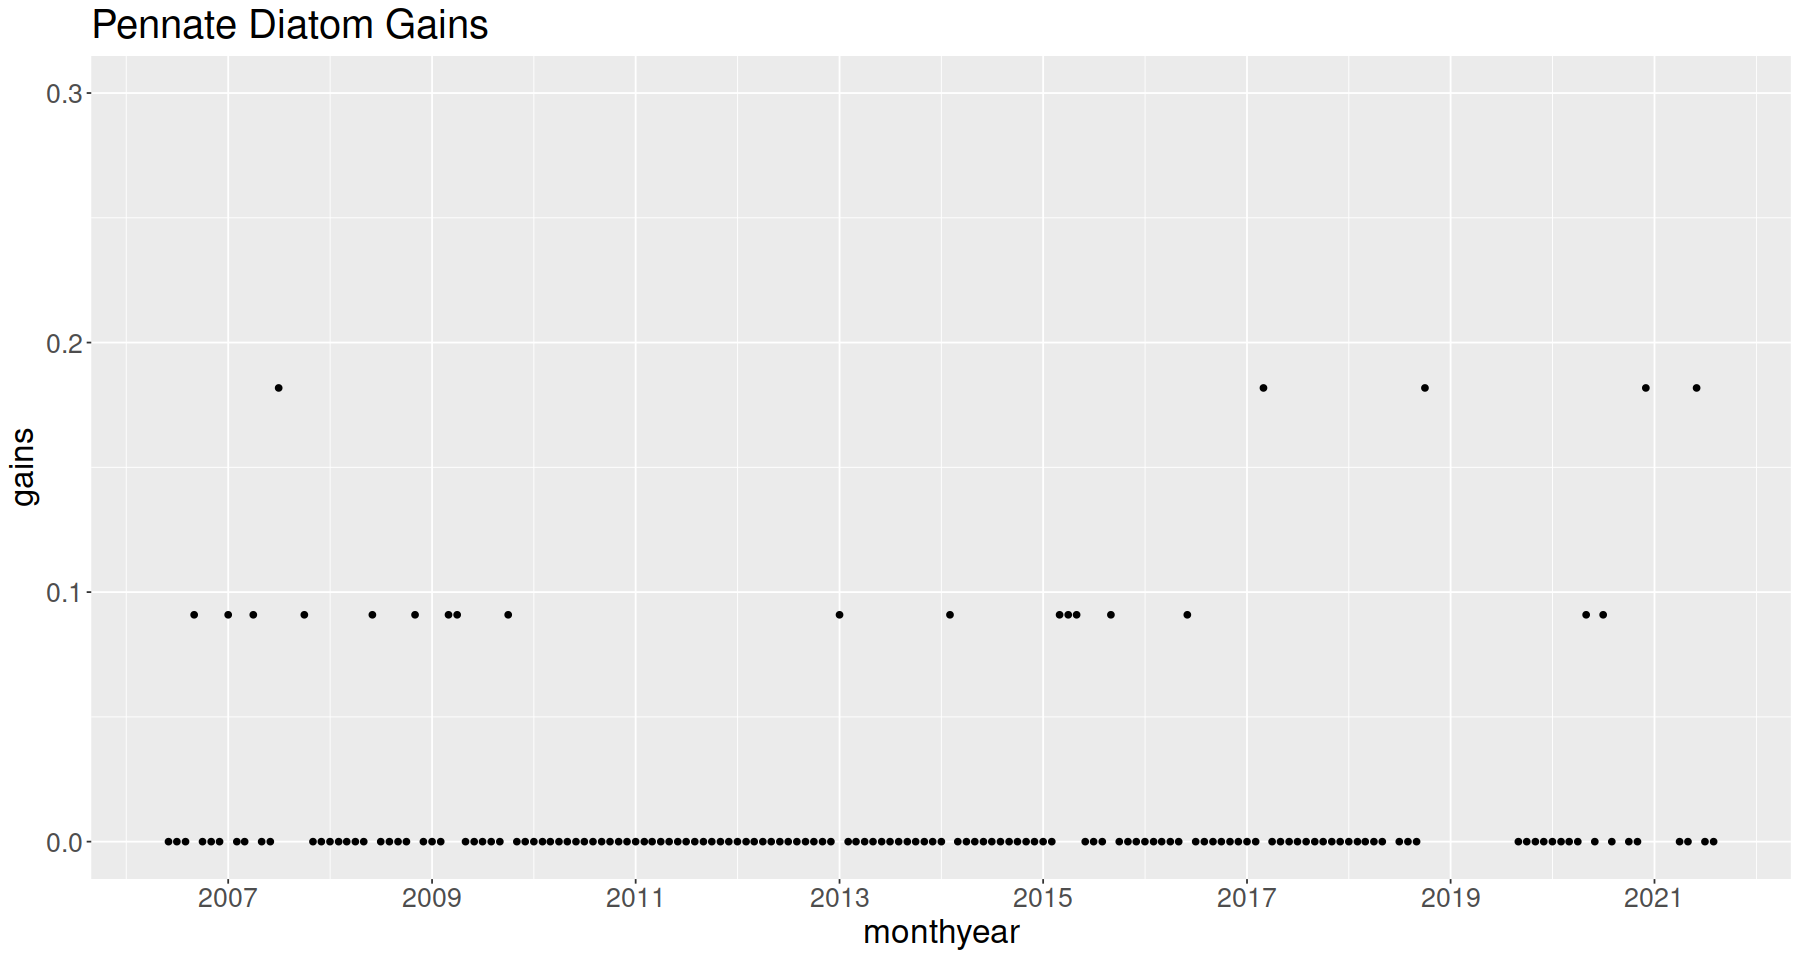

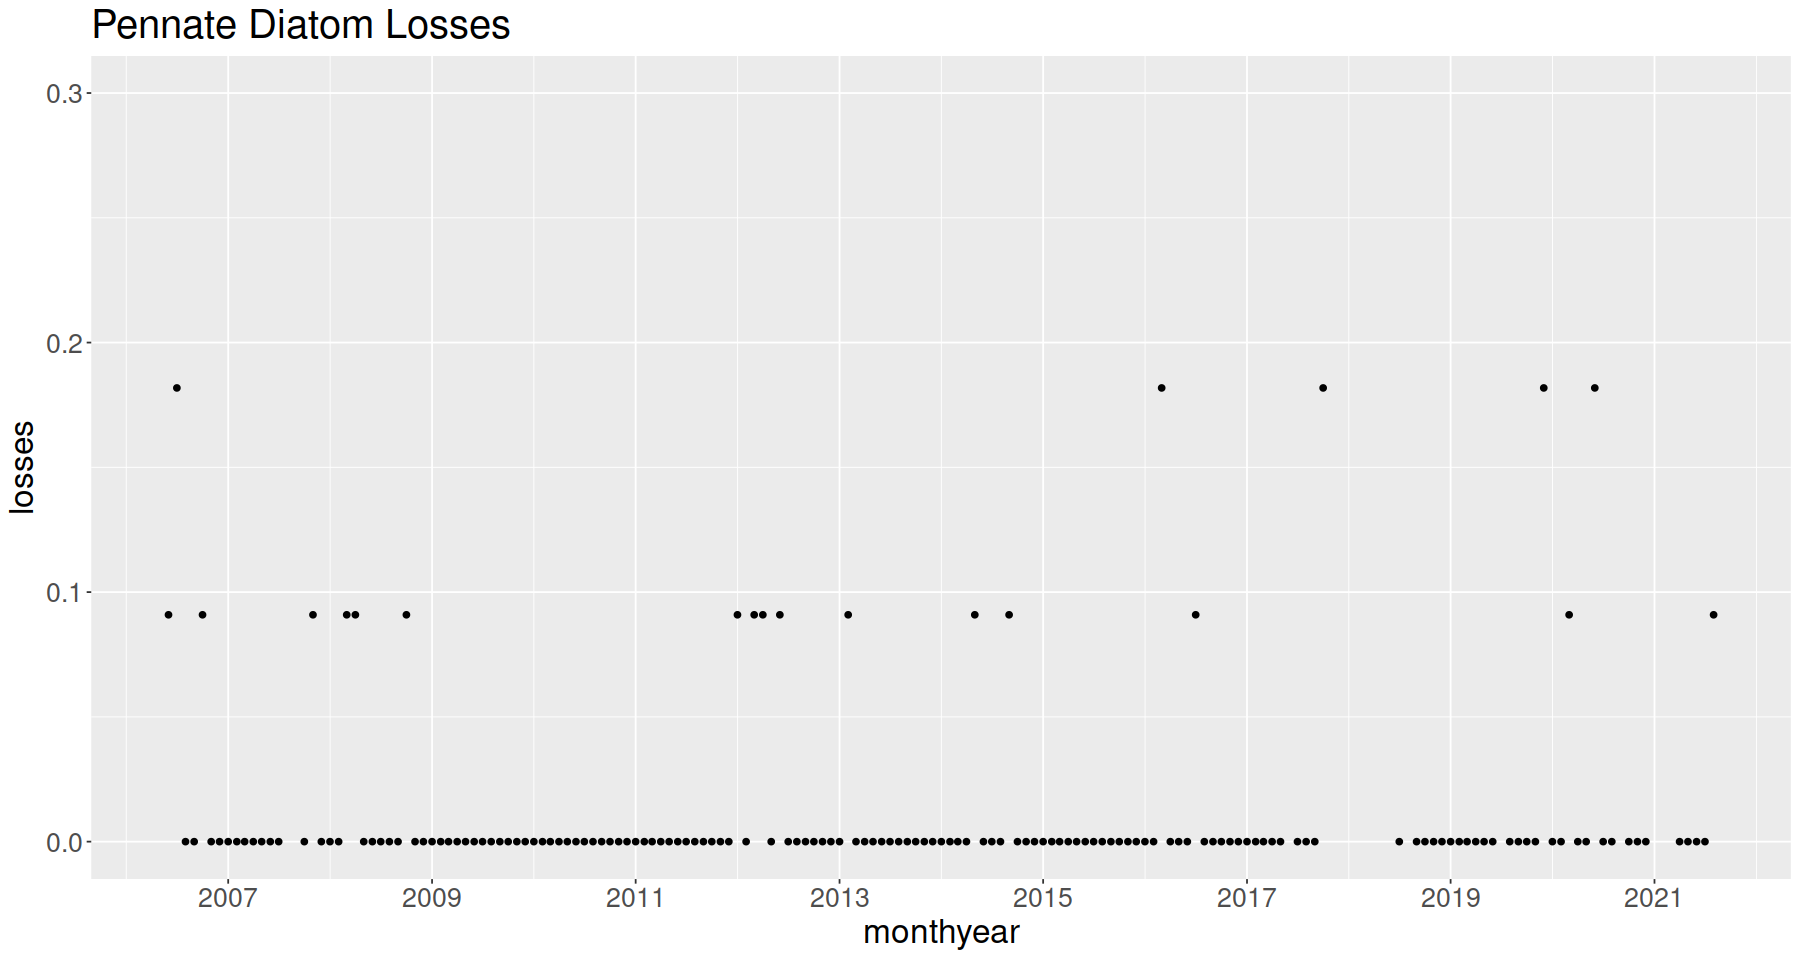

In [34]:
plotgroup <- function(group,datagroup) {
    # converting to long format
    # head(dfConc)
    df.dia <- dfConc[,c(1,2,datagroup)] # isolating just the diatom group

    # head(df.dia)

    #converting from wide to long format 
    df.dia.long <- gather(df.dia,species,conc,as.character(colnames(df.dia)[3]):as.character(colnames(df.dia)[length(df.dia)]),factor_key=TRUE)

    df.dia.long$date = dmy_hms(as.character(df.dia.long$datetime))
    df.dia.long$year = year(df.dia.long$date)
    df.dia.long$month = month(df.dia.long$date)
    df.dia.long$day = day(df.dia.long$date)
    df.dia.long["mdy"] = paste0(df.dia.long$month,"_",df.dia.long$day,"_",df.dia.long$year)
    df.dia.long["my"] = paste0(df.dia.long$month,"_",df.dia.long$year)

    # head(df.dia.long)
    print(length(df.dia.long$species))

    df.dia.long<- df.dia.long %>% 
                drop_na() %>%
                filter_all( all_vars(. != 0)) %>%
                group_by(my,species)

    # head(df.dia.long)

    df.dia.long$count <- df.dia.long$conc * df.dia.long$milliliters_analyzed

    df.dia.long <- df.dia.long %>% 
                    summarize(my.conc = (sum(count)/sum(milliliters_analyzed)))

    head(df.dia.long)

    dfrm <- RAC_change(df = df.dia.long, 
               species.var = "species",
               abundance.var = "my.conc",
               time.var ="my")

    dfrm$monthyear = as.Date(my(dfrm$my),format = "%Y-%m-%d")
    typeof(dfrm$my)
    head(dfrm)

    options(repr.plot.width=15, repr.plot.height=8)


    # plotting evenness change

    print(ggplot(data = dfrm,aes(x = monthyear, y = evenness_change)) +
    geom_point()+
    geom_hline(yintercept = 0,
               linetype = "dashed",
               color = "red",
               size = 2)+
        theme(text = element_text(size=20))+
      geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)+
        scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
        ggtitle(paste(group,"Evenness Change")))

    # plotting rank change
    print(ggplot(data = dfrm,aes(x = monthyear, y = rank_change)) +
    geom_point()+
        theme(text = element_text(size=20))+
    #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
        scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
    ylim(0,0.3)+
    ggtitle(paste(group,"Rank Change")))


    # plotting gains
   print(ggplot(data = dfrm,aes(x = monthyear, y = gains)) +
    geom_point()+
        theme(text = element_text(size=20))+
    #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
        scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
    ylim(0,0.3)+
    ggtitle(paste(group,"Gains")))

    # plotting losses
    print(ggplot(data = dfrm,aes(x = monthyear, y = losses)) +
    geom_point()+
        theme(text = element_text(size=20))+
    #   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
        scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
    ylim(0,0.3)+
    ggtitle(paste(group,"Losses")))
    }


plotgroup("Pennate Diatom", pen_col)

[1] 226734


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


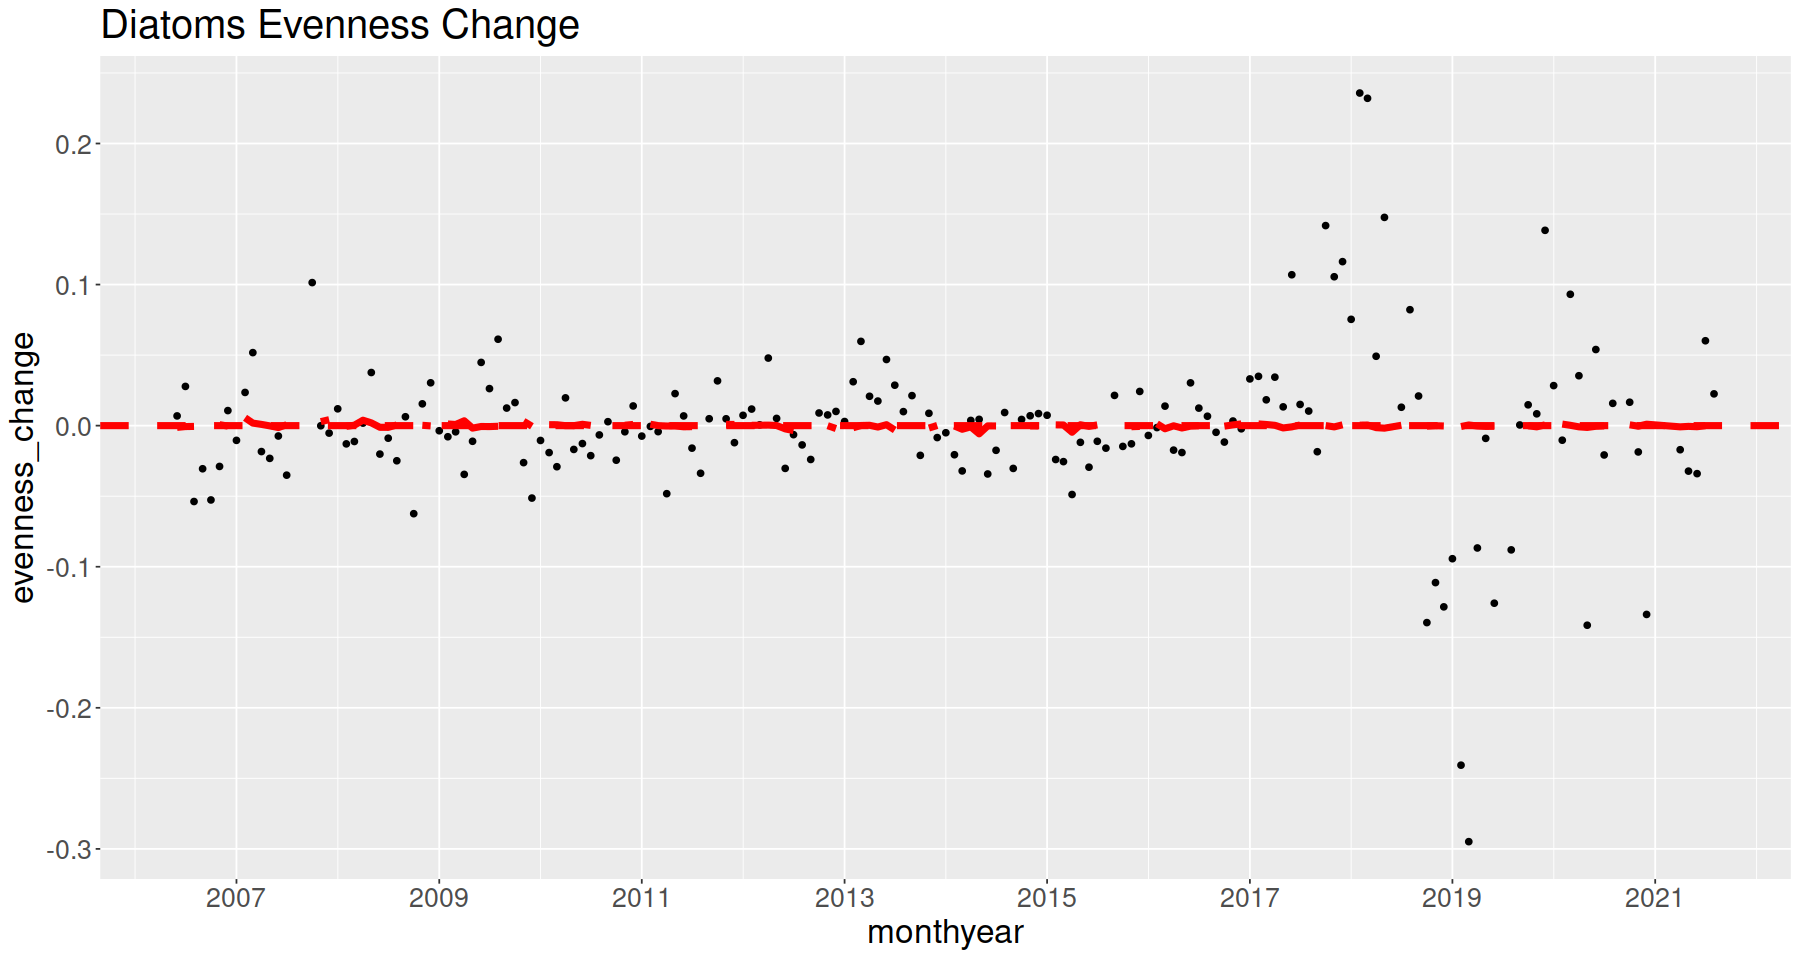

Warning message:
“Removed 4 rows containing missing values (geom_point).”


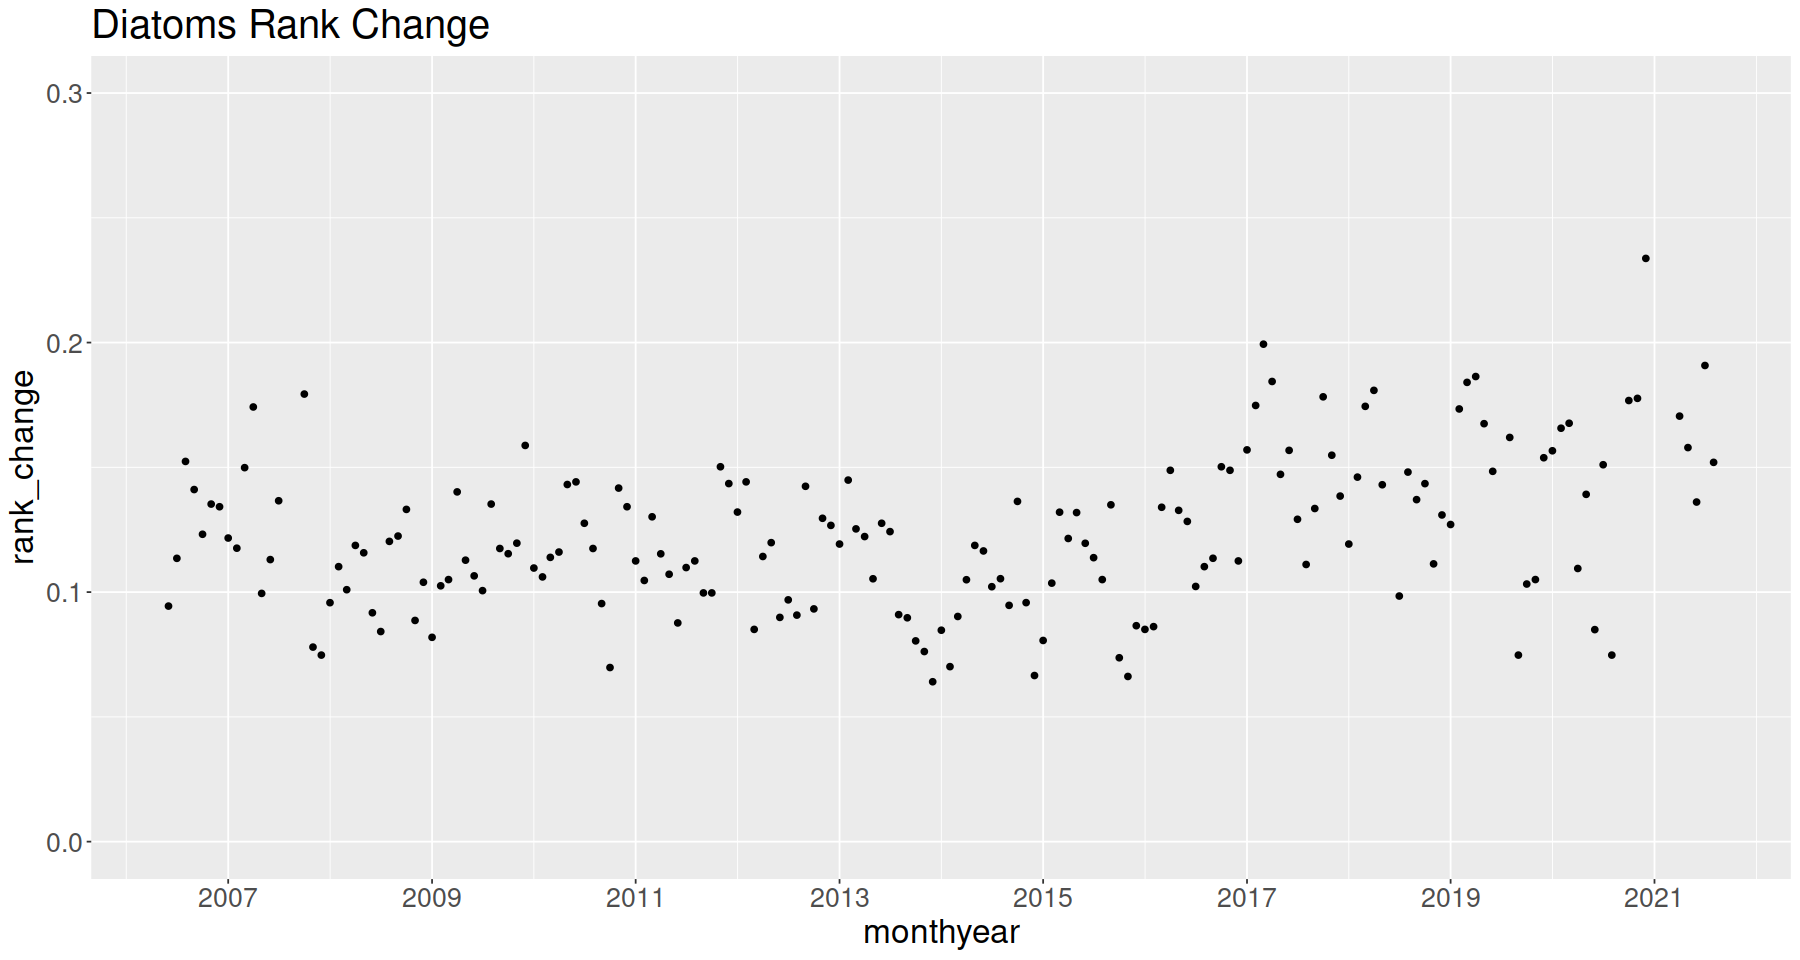

Warning message:
“Removed 6 rows containing missing values (geom_point).”


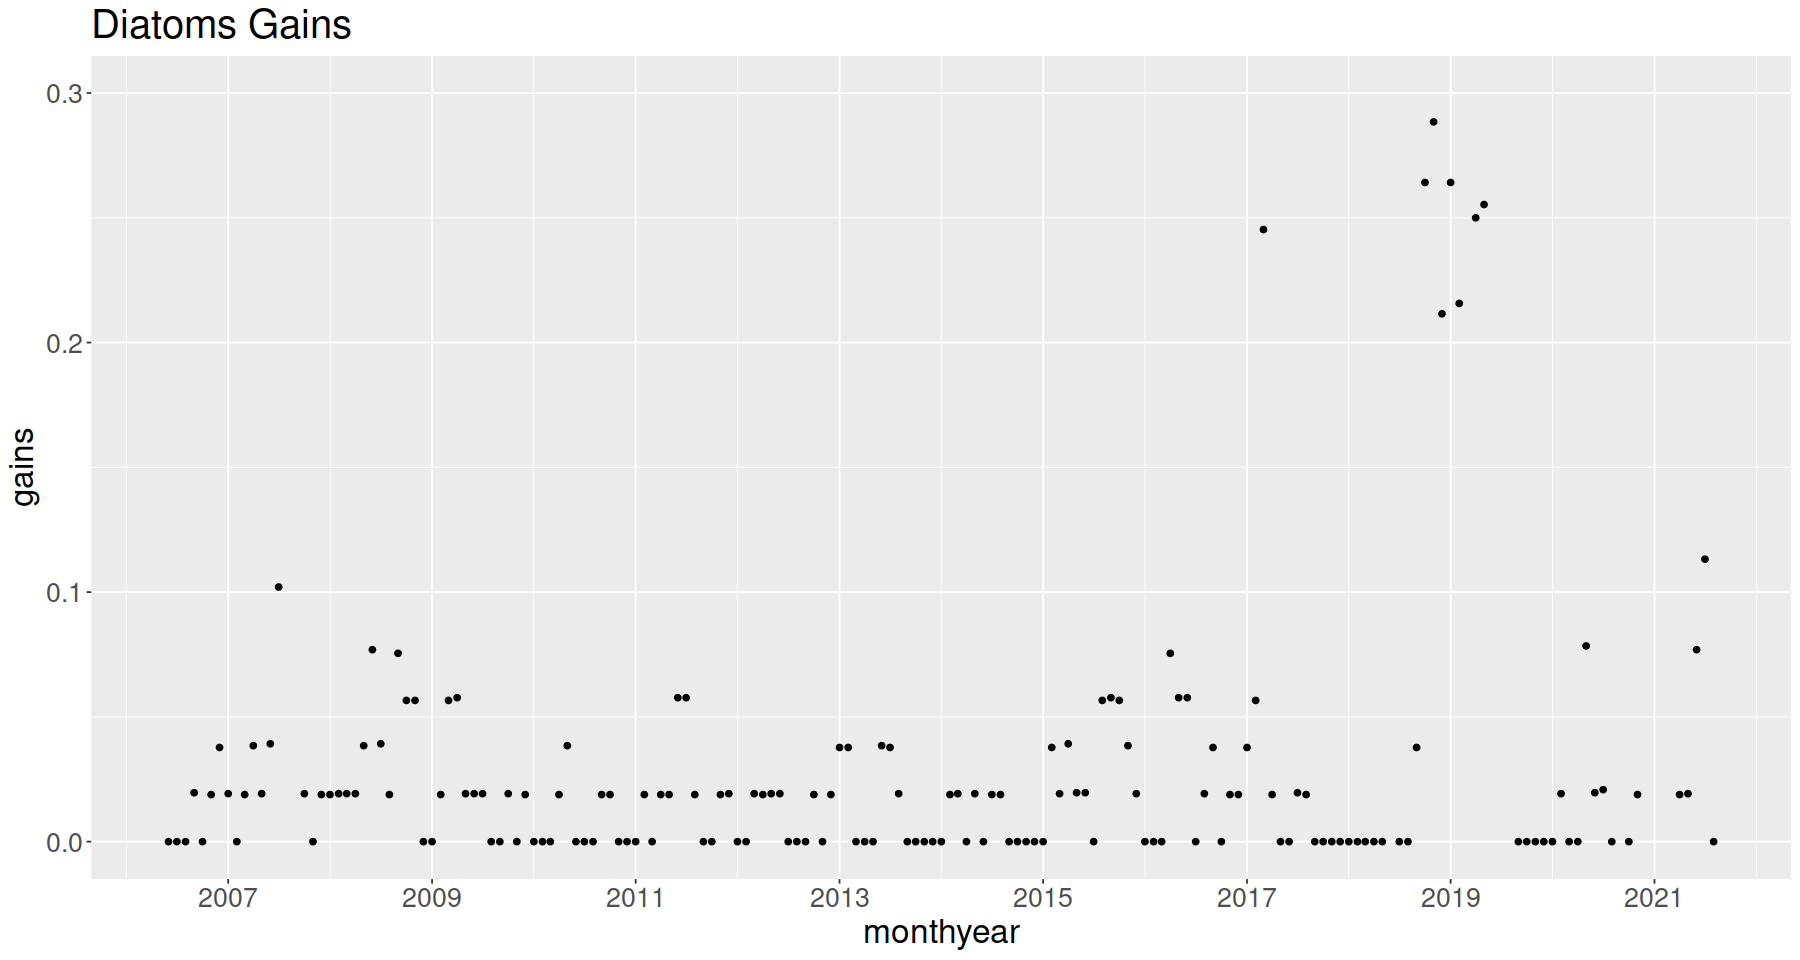

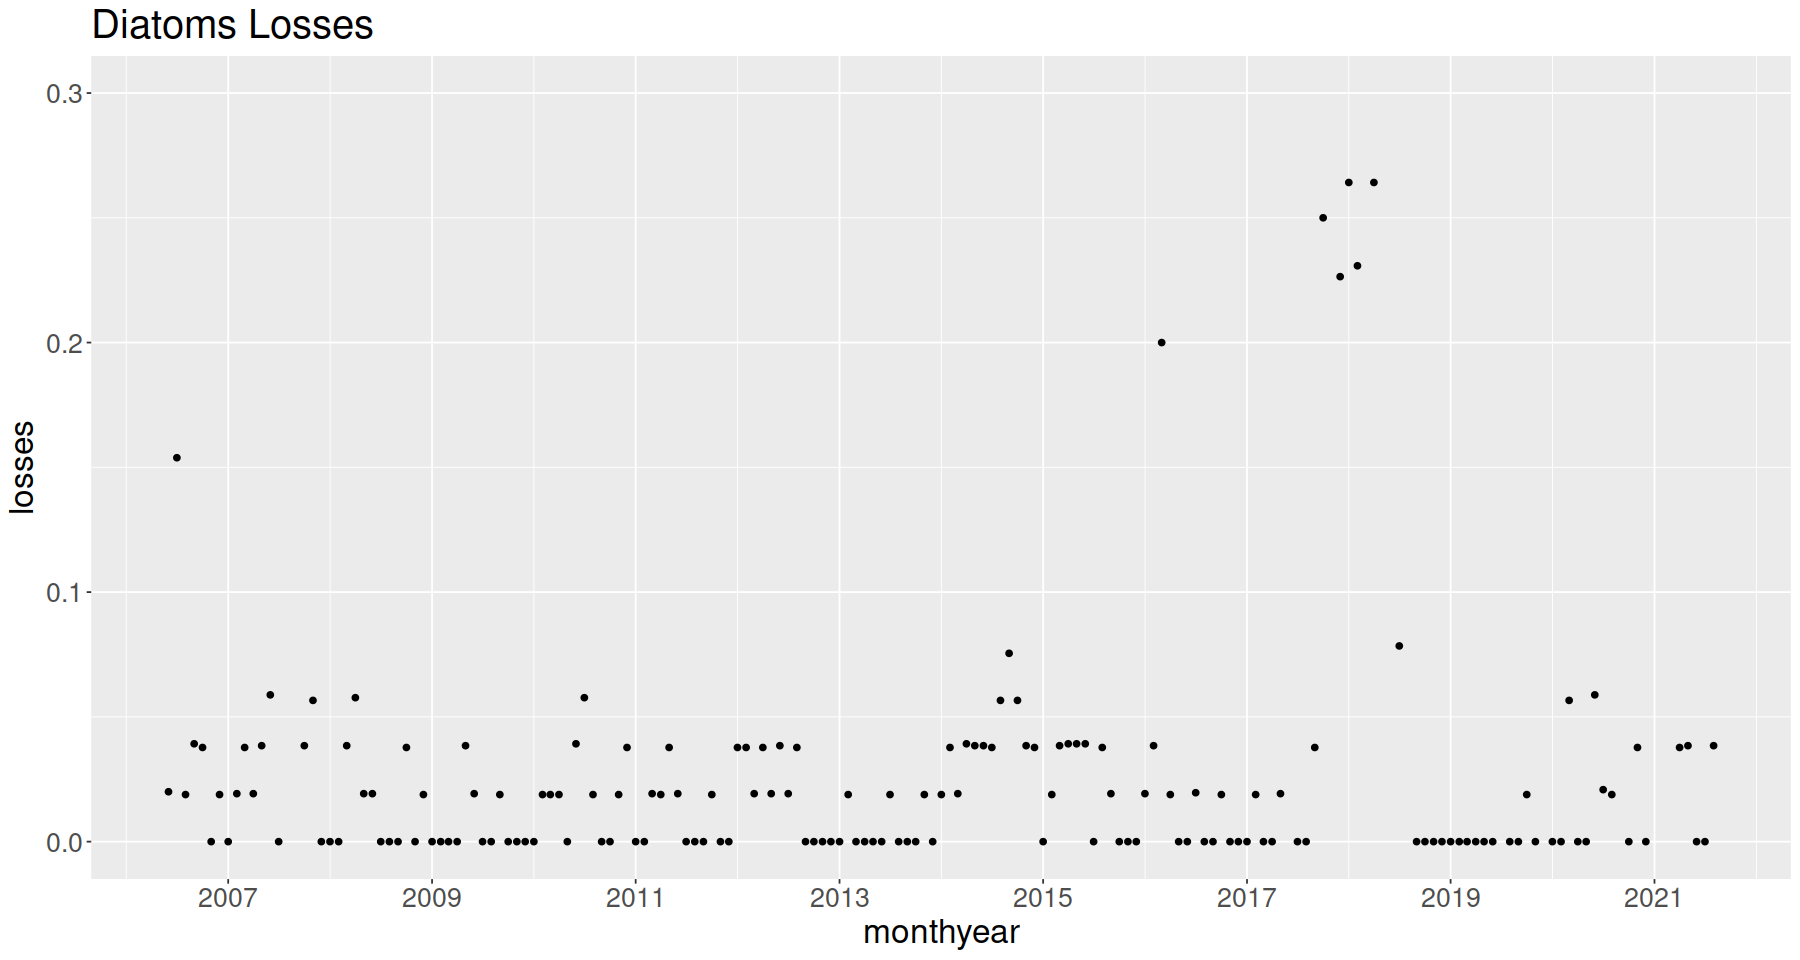

In [39]:
plotgroup("Diatoms",dia_col)

## Coccolithophores

[1] 34224


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


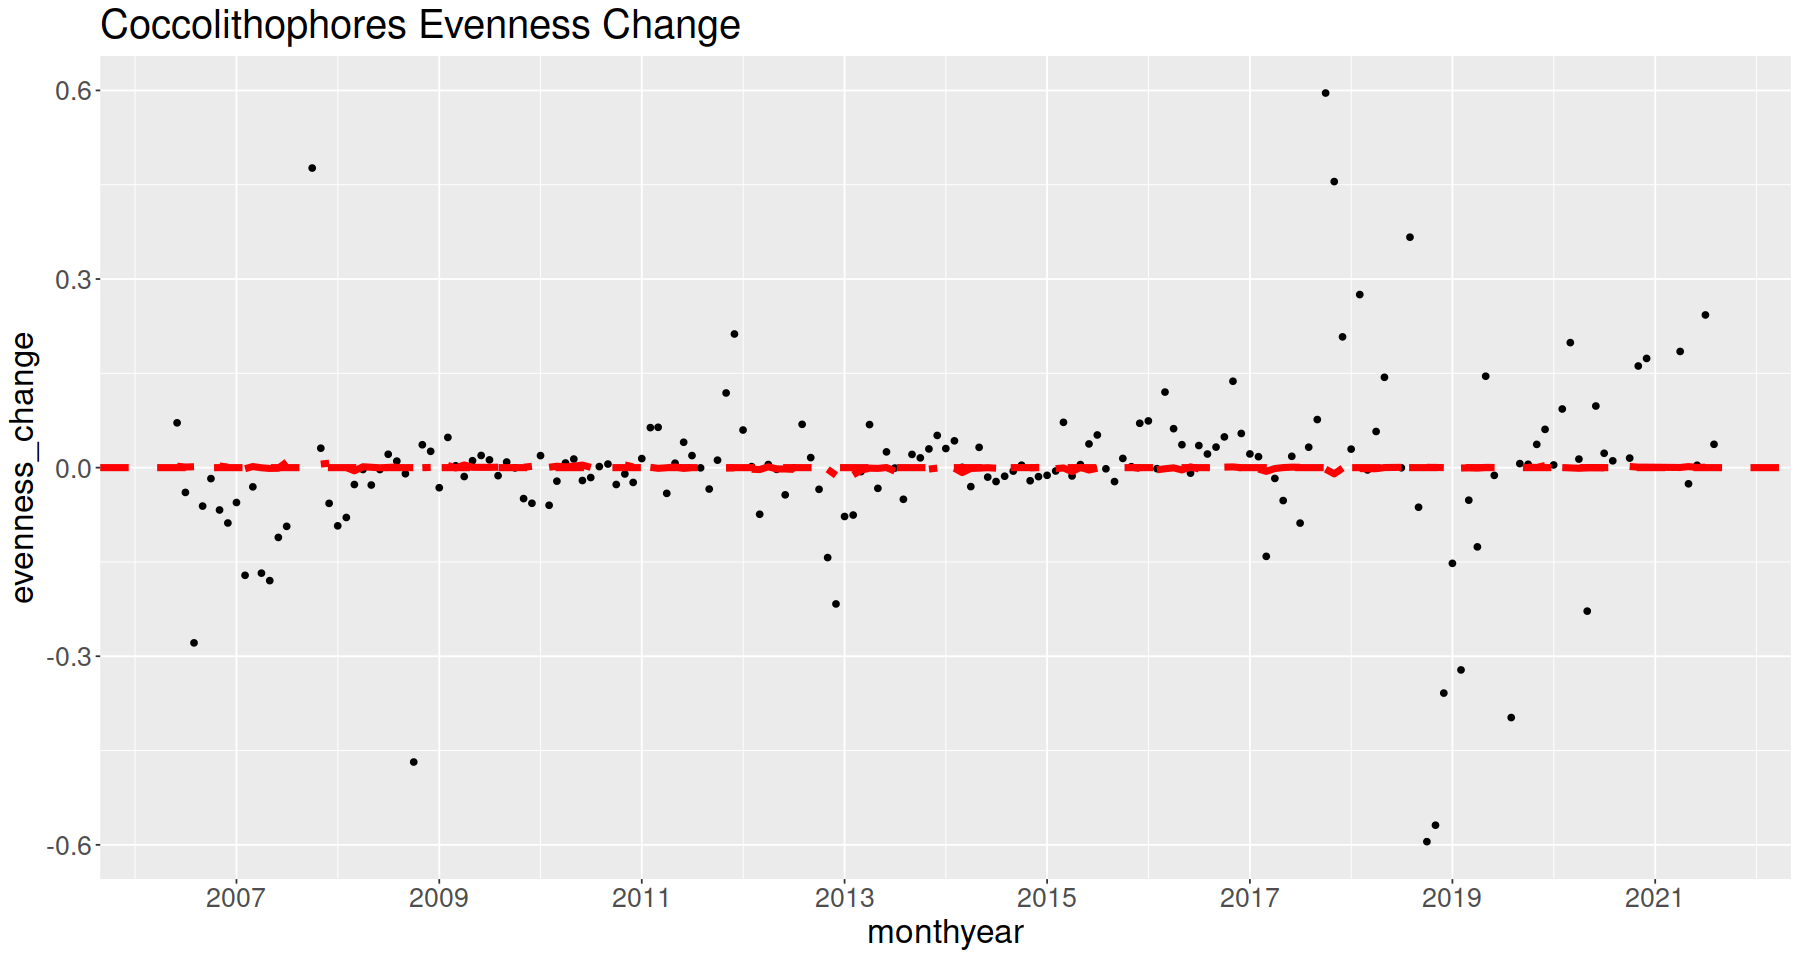

Warning message:
“Removed 7 rows containing missing values (geom_point).”


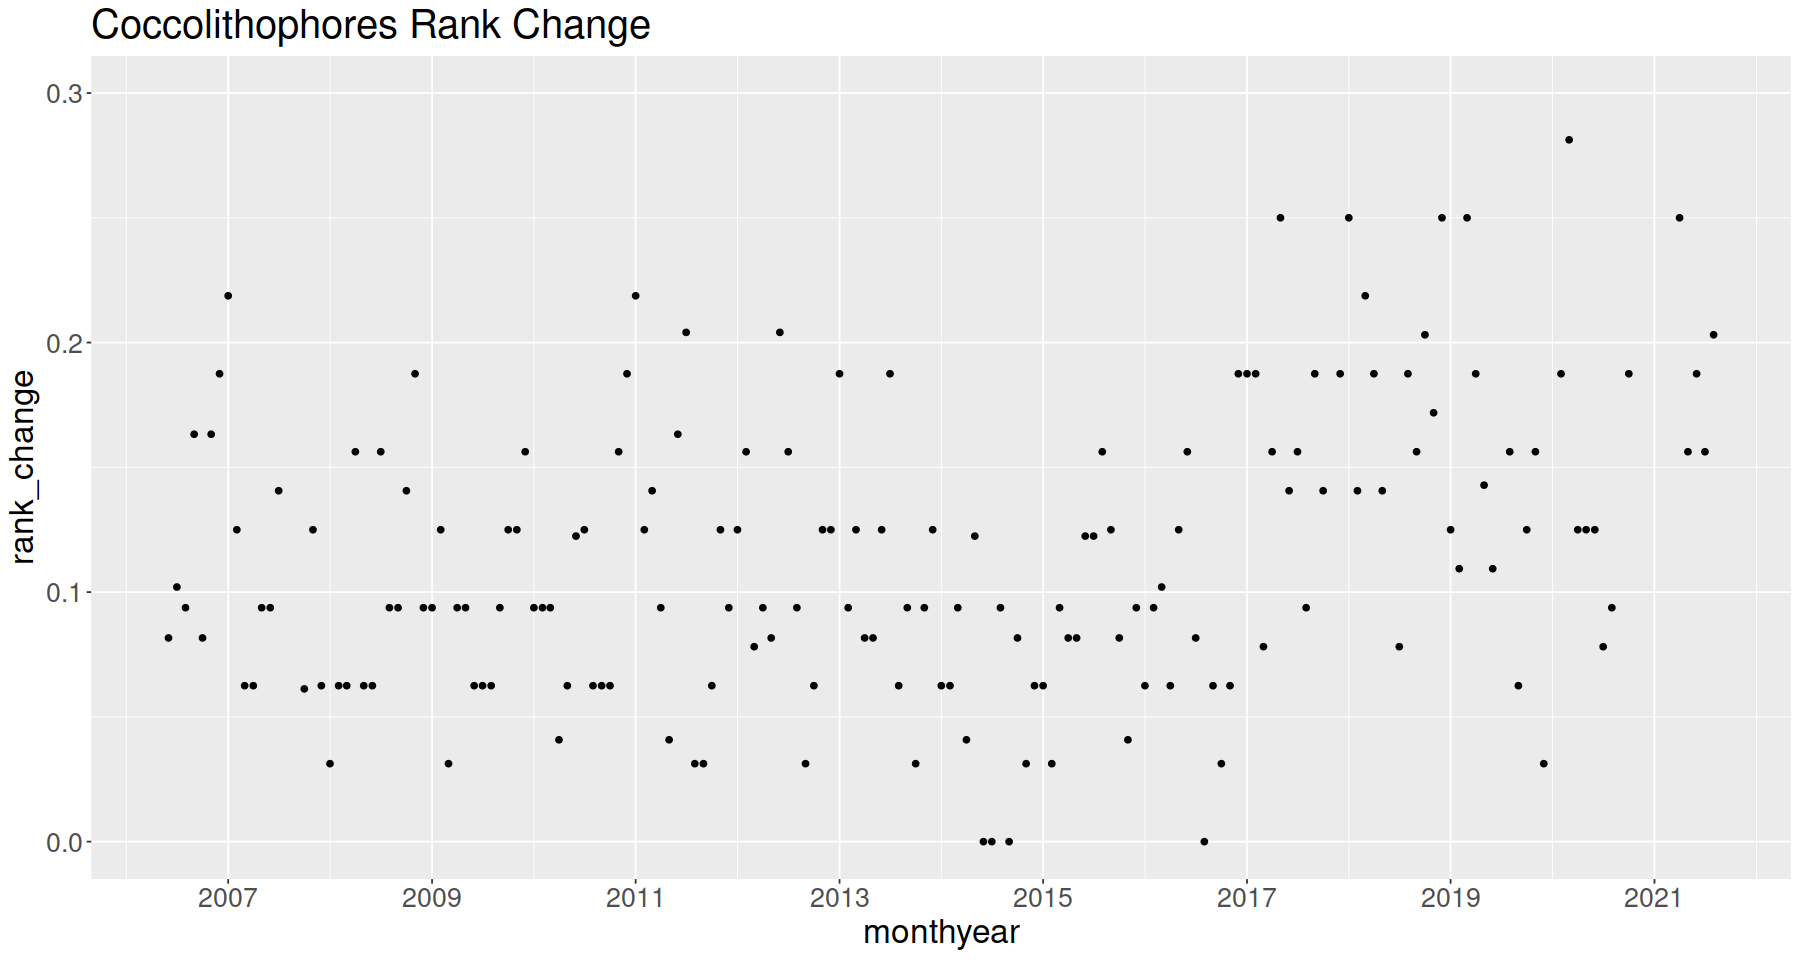

Warning message:
“Removed 6 rows containing missing values (geom_point).”


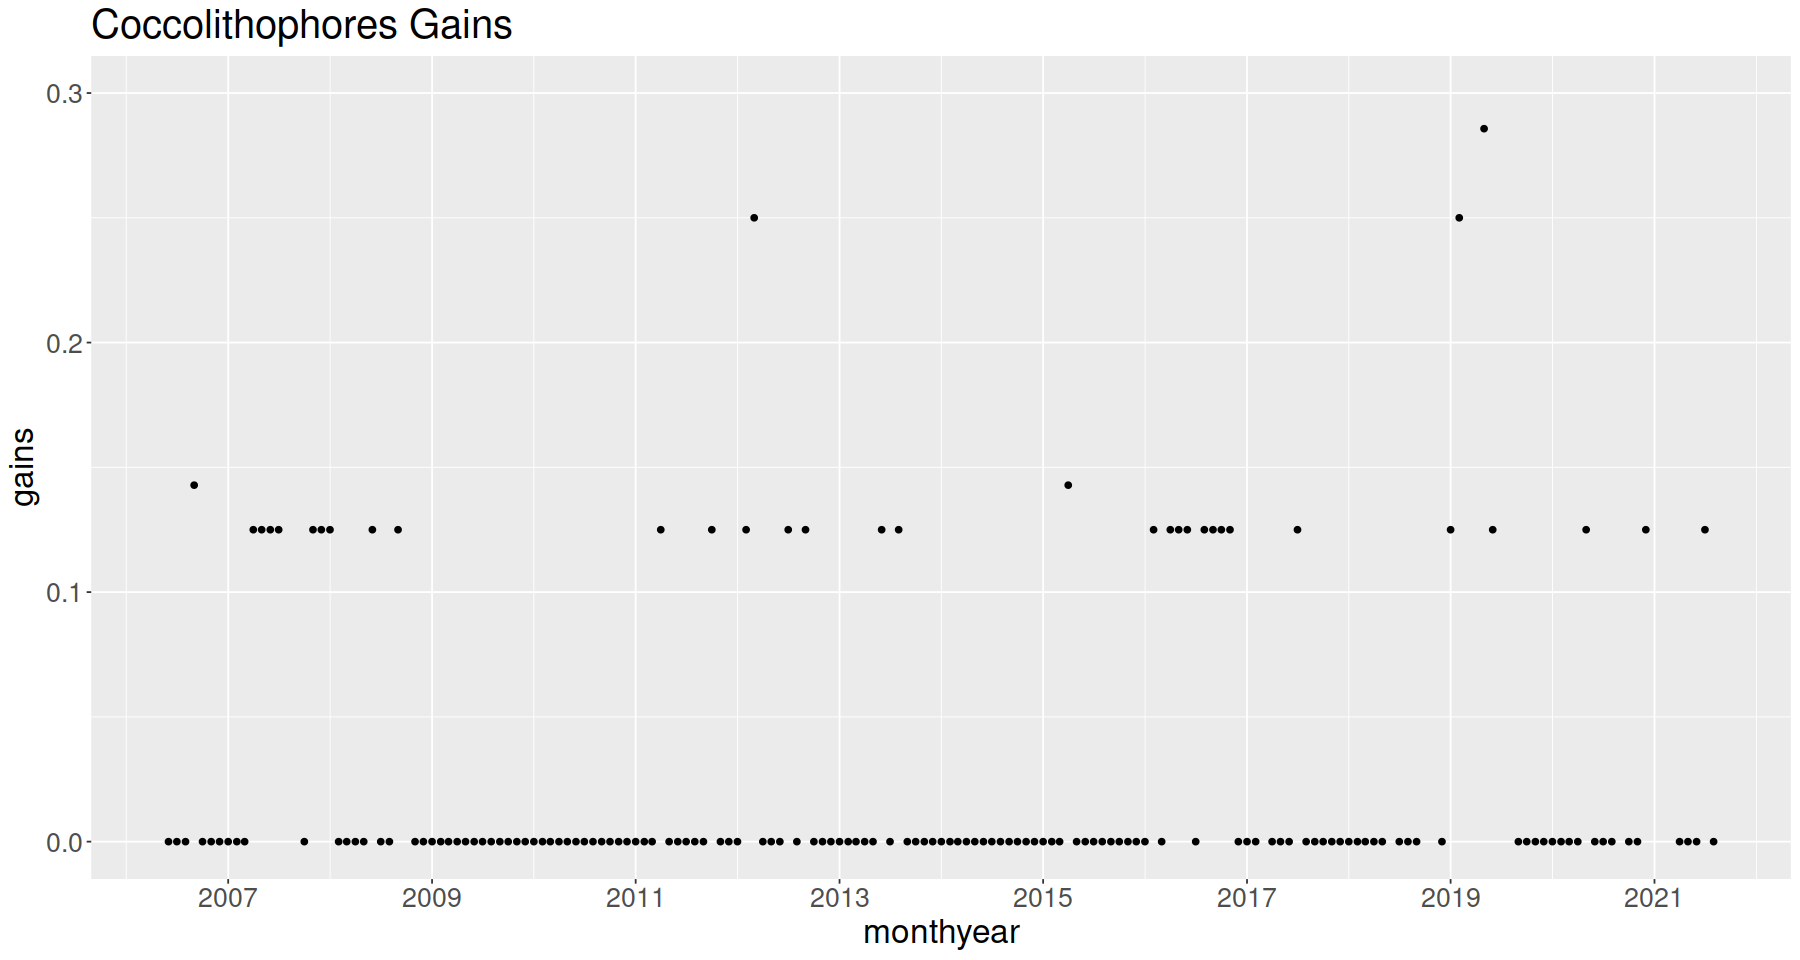

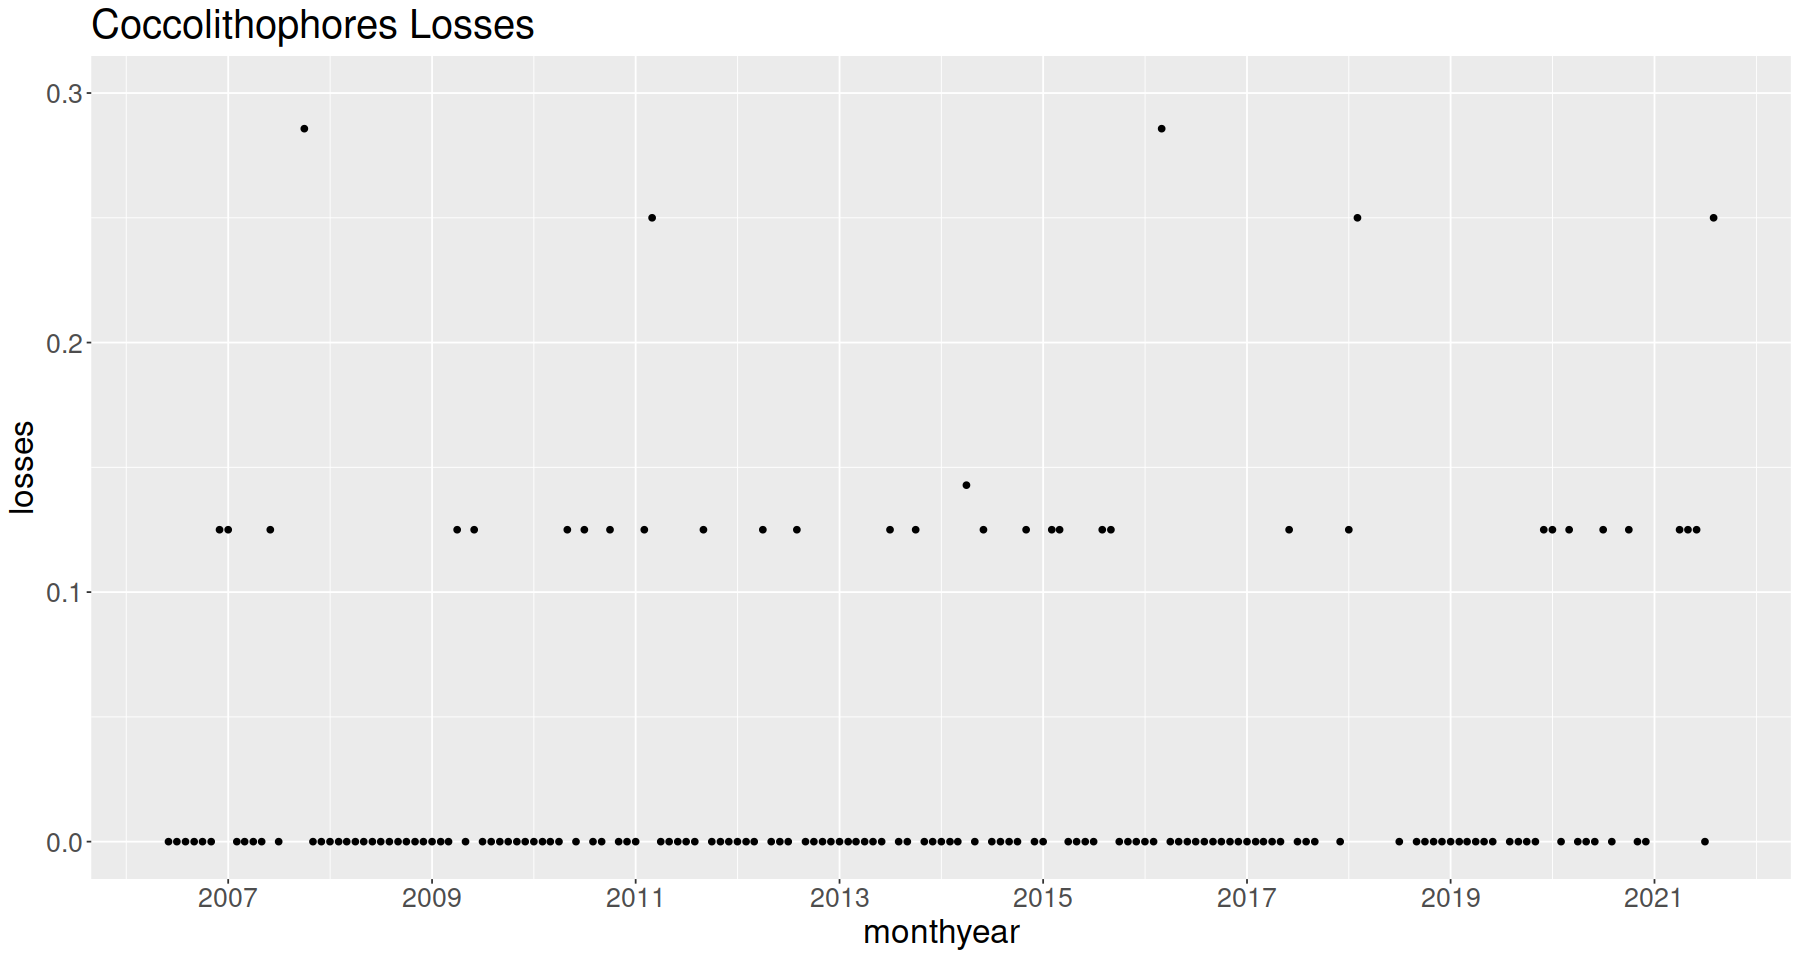

In [35]:
plotgroup("Coccolithophores",coc_col)

[1] 119784


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


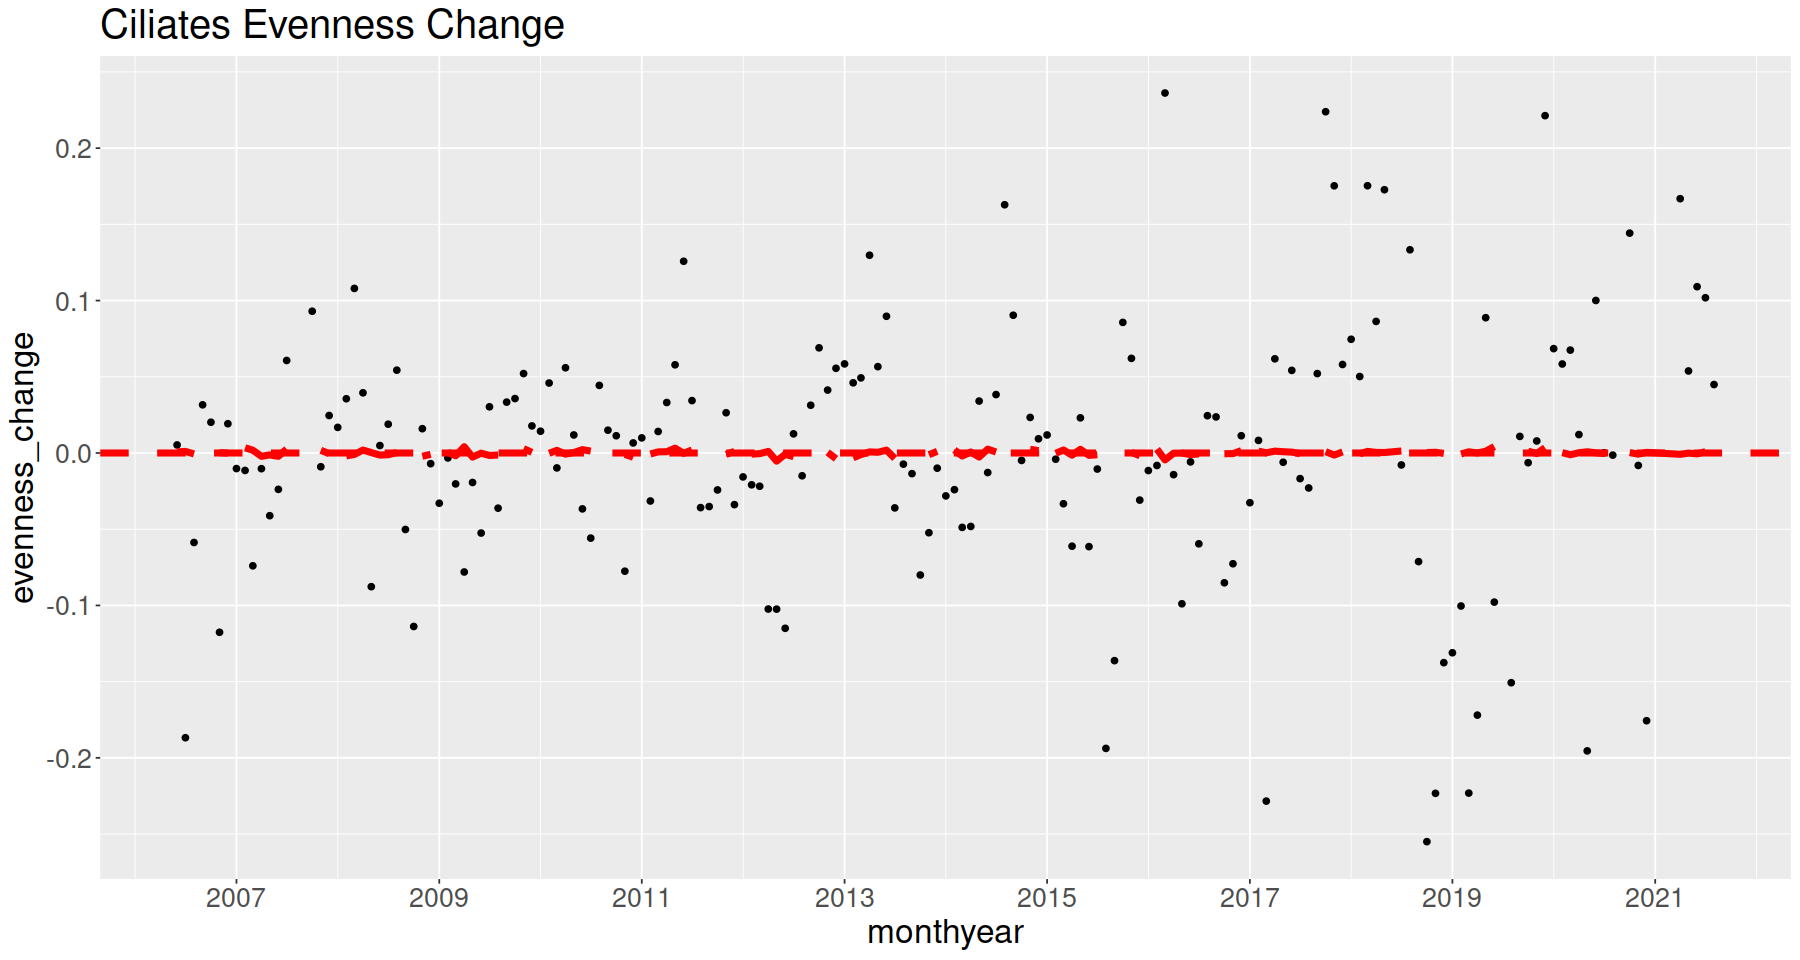

Warning message:
“Removed 11 rows containing missing values (geom_point).”


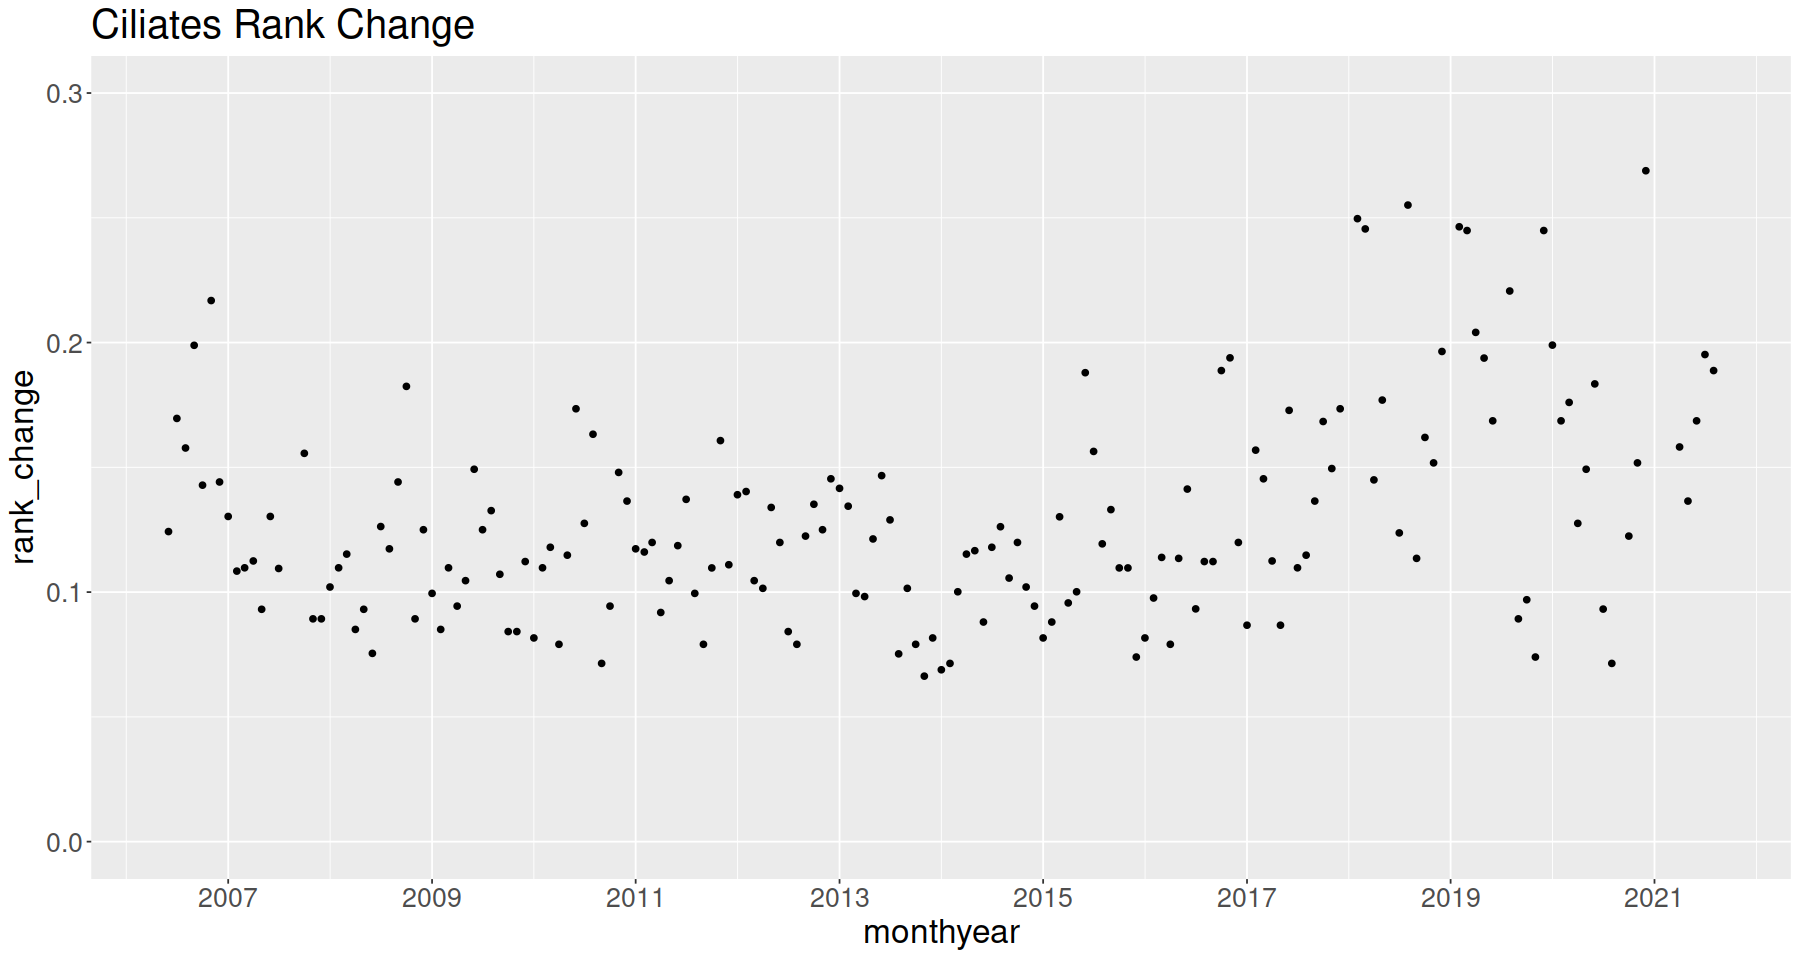

Warning message:
“Removed 11 rows containing missing values (geom_point).”


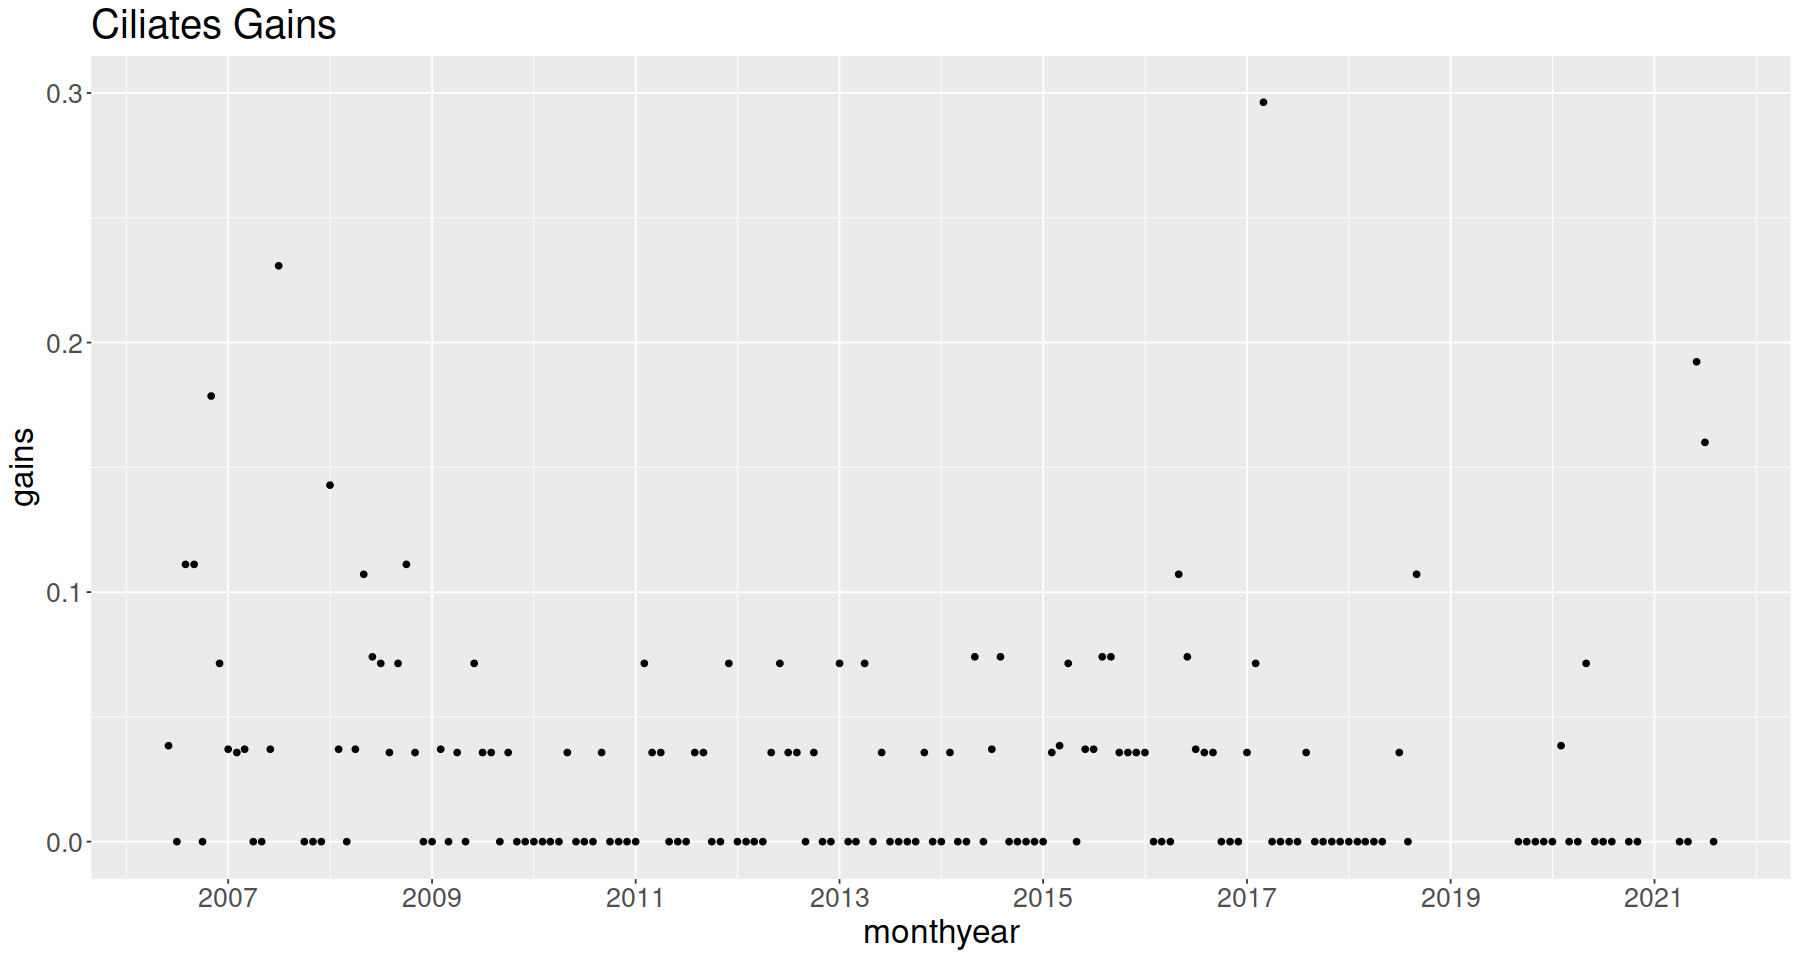

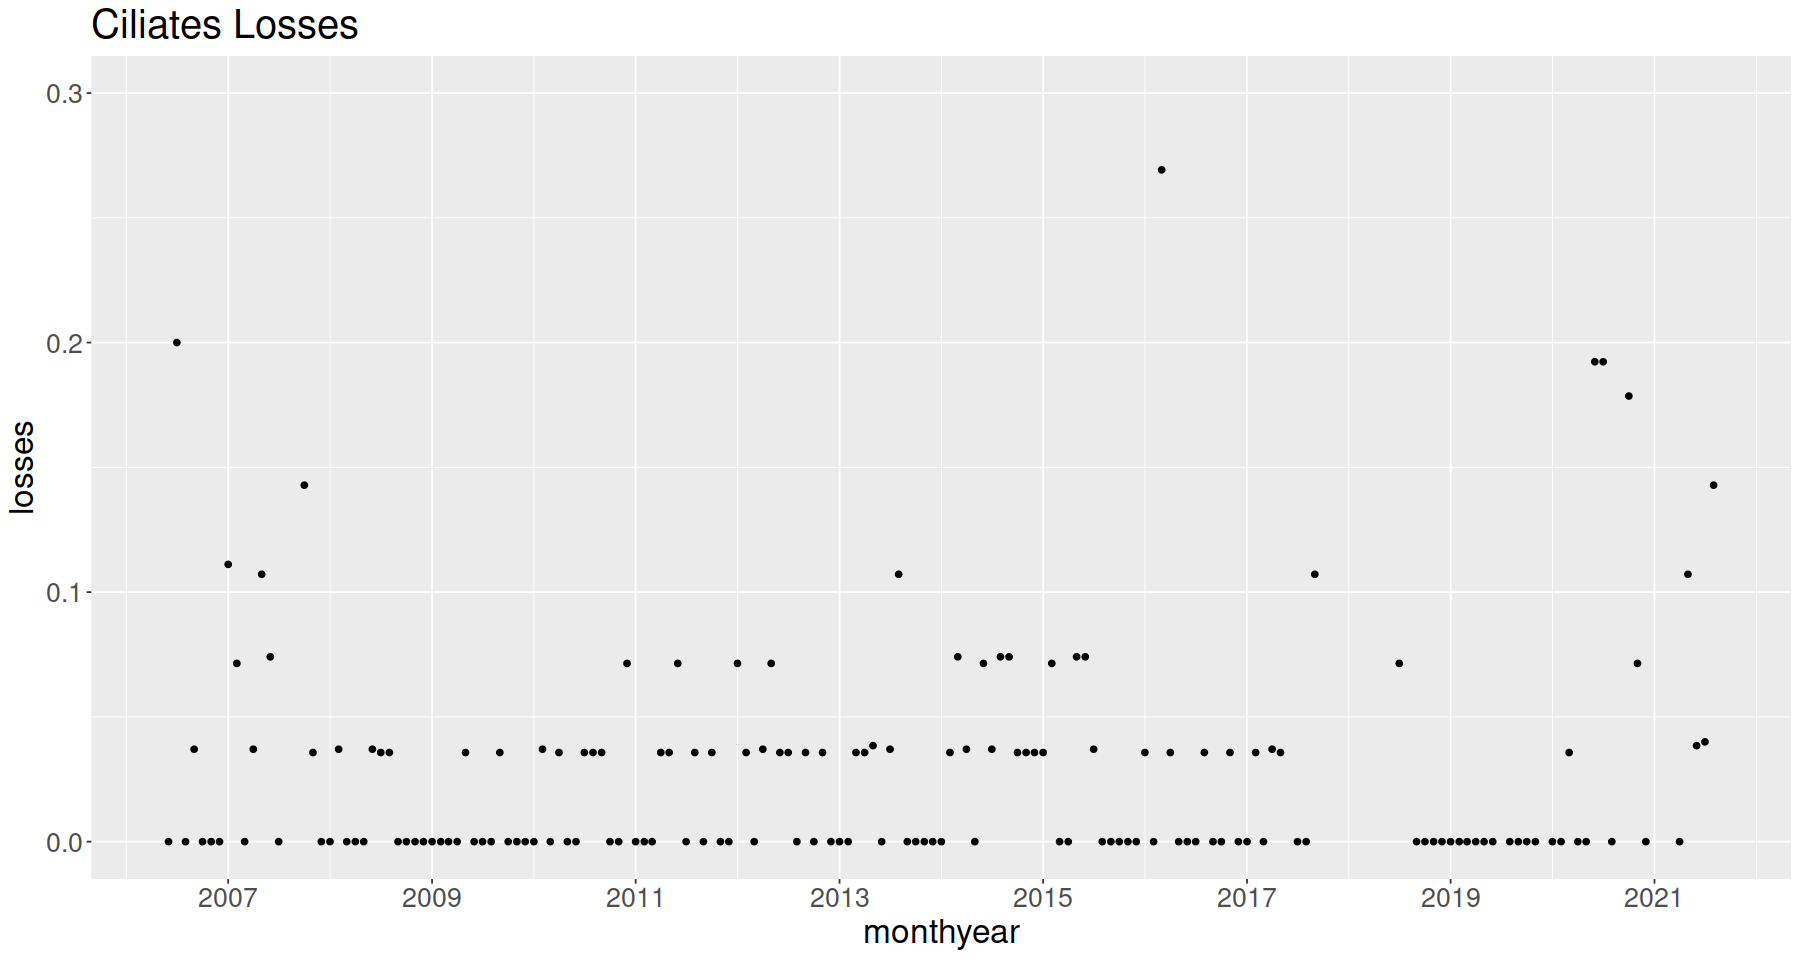

In [36]:
plotgroup("Ciliates",cil_col)

[1] 68448


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


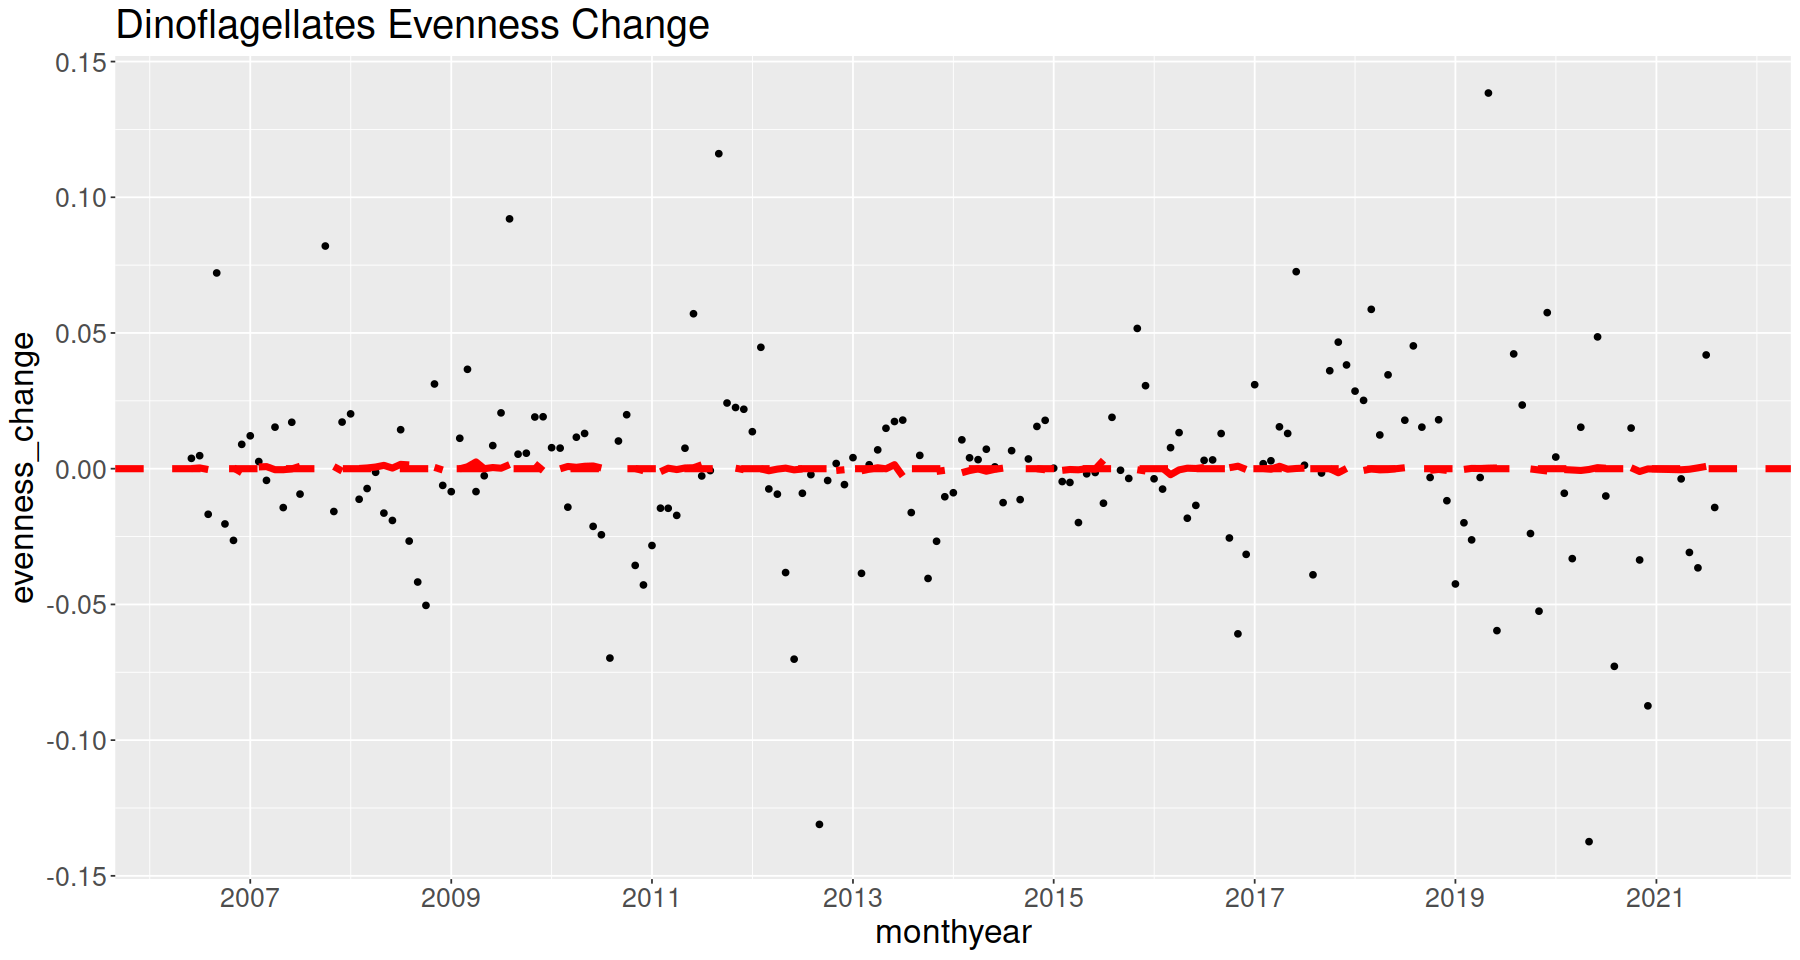

Warning message:
“Removed 4 rows containing missing values (geom_point).”


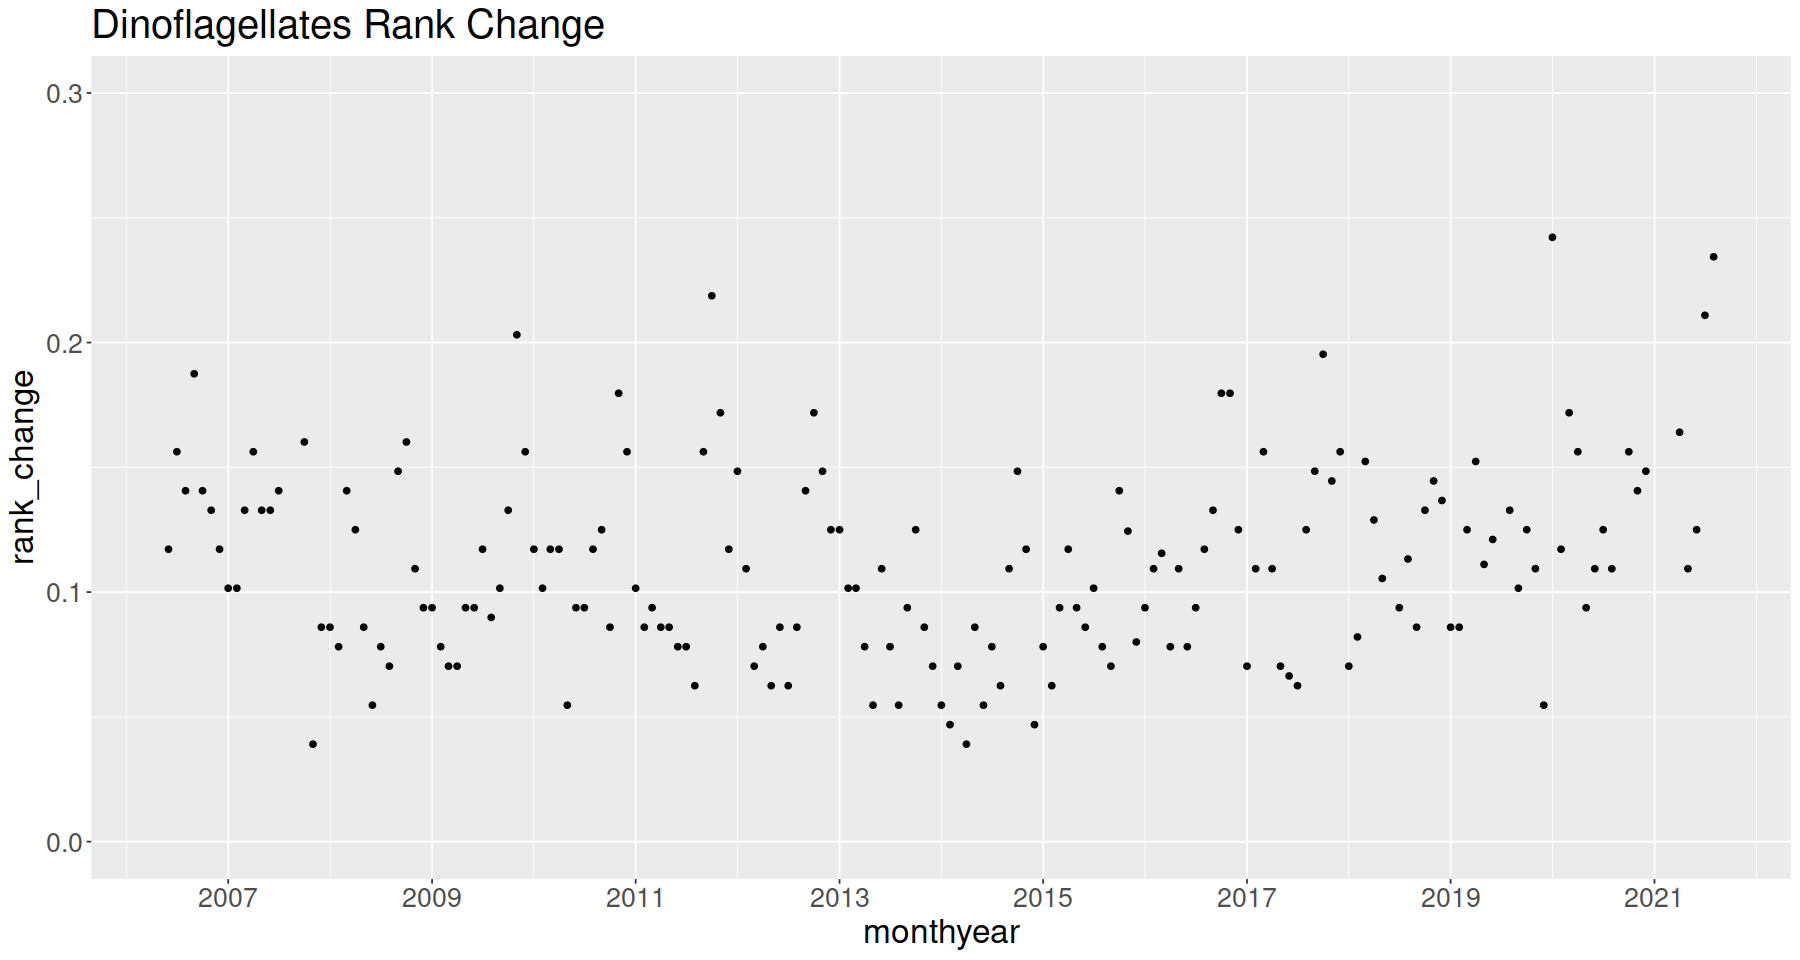

Warning message:
“Removed 4 rows containing missing values (geom_point).”


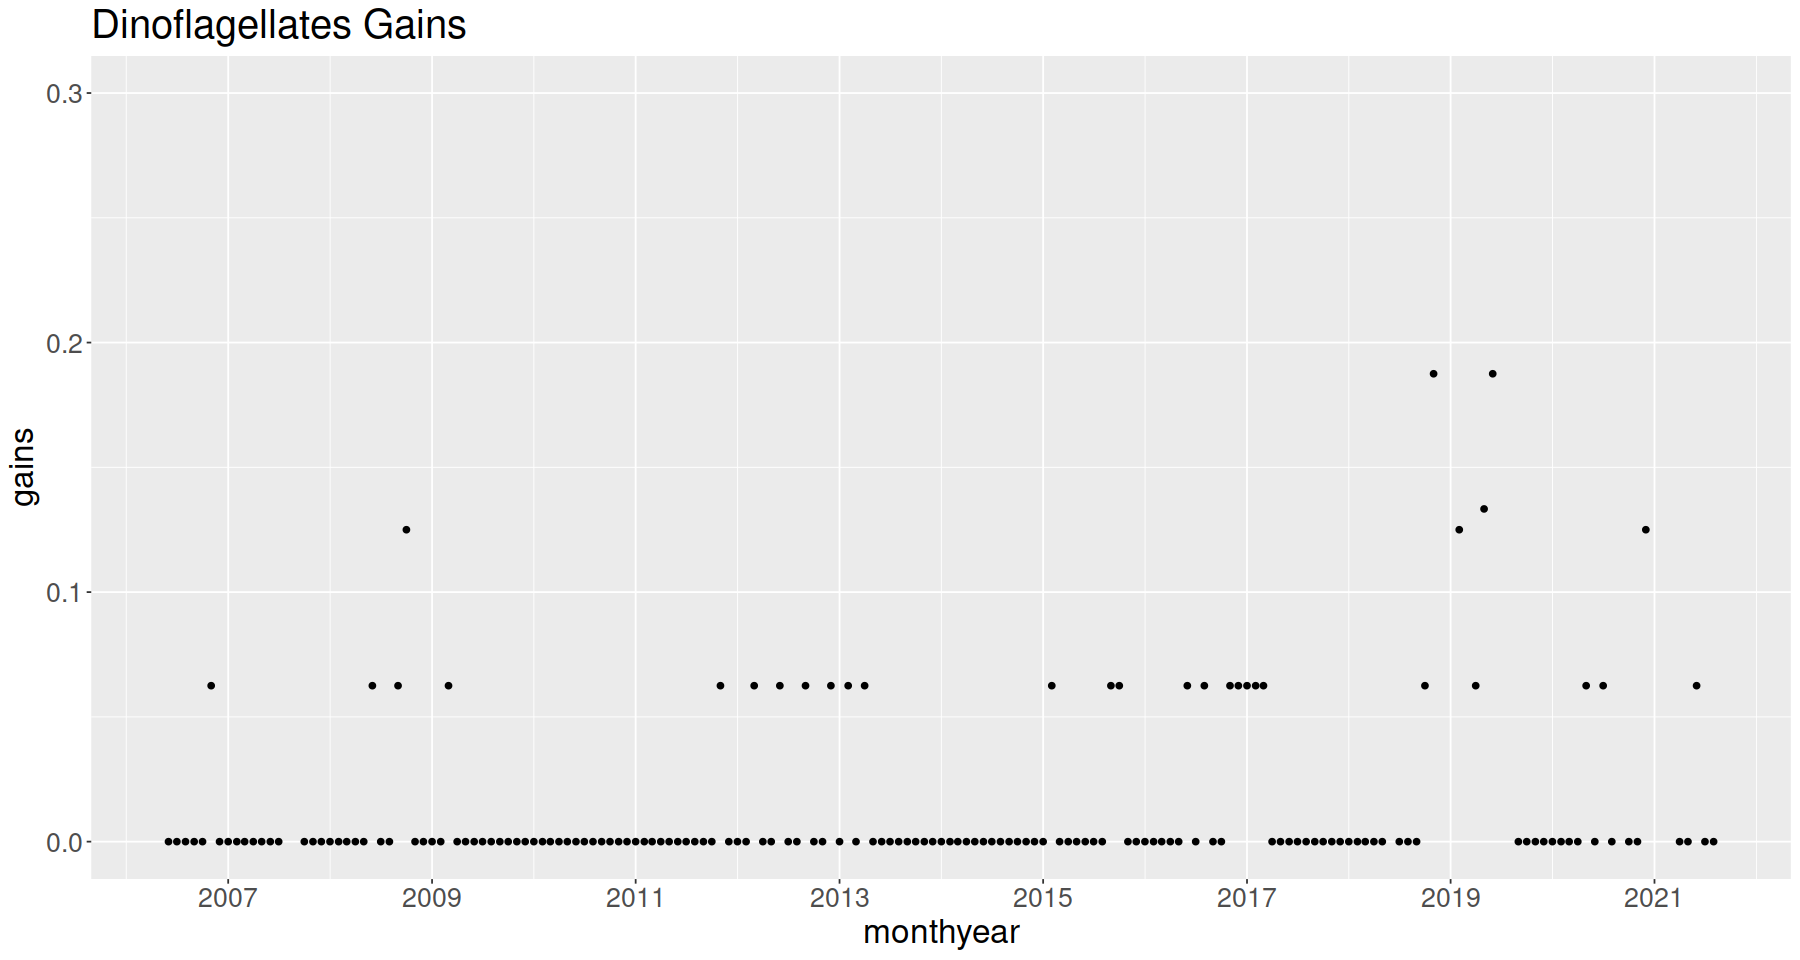

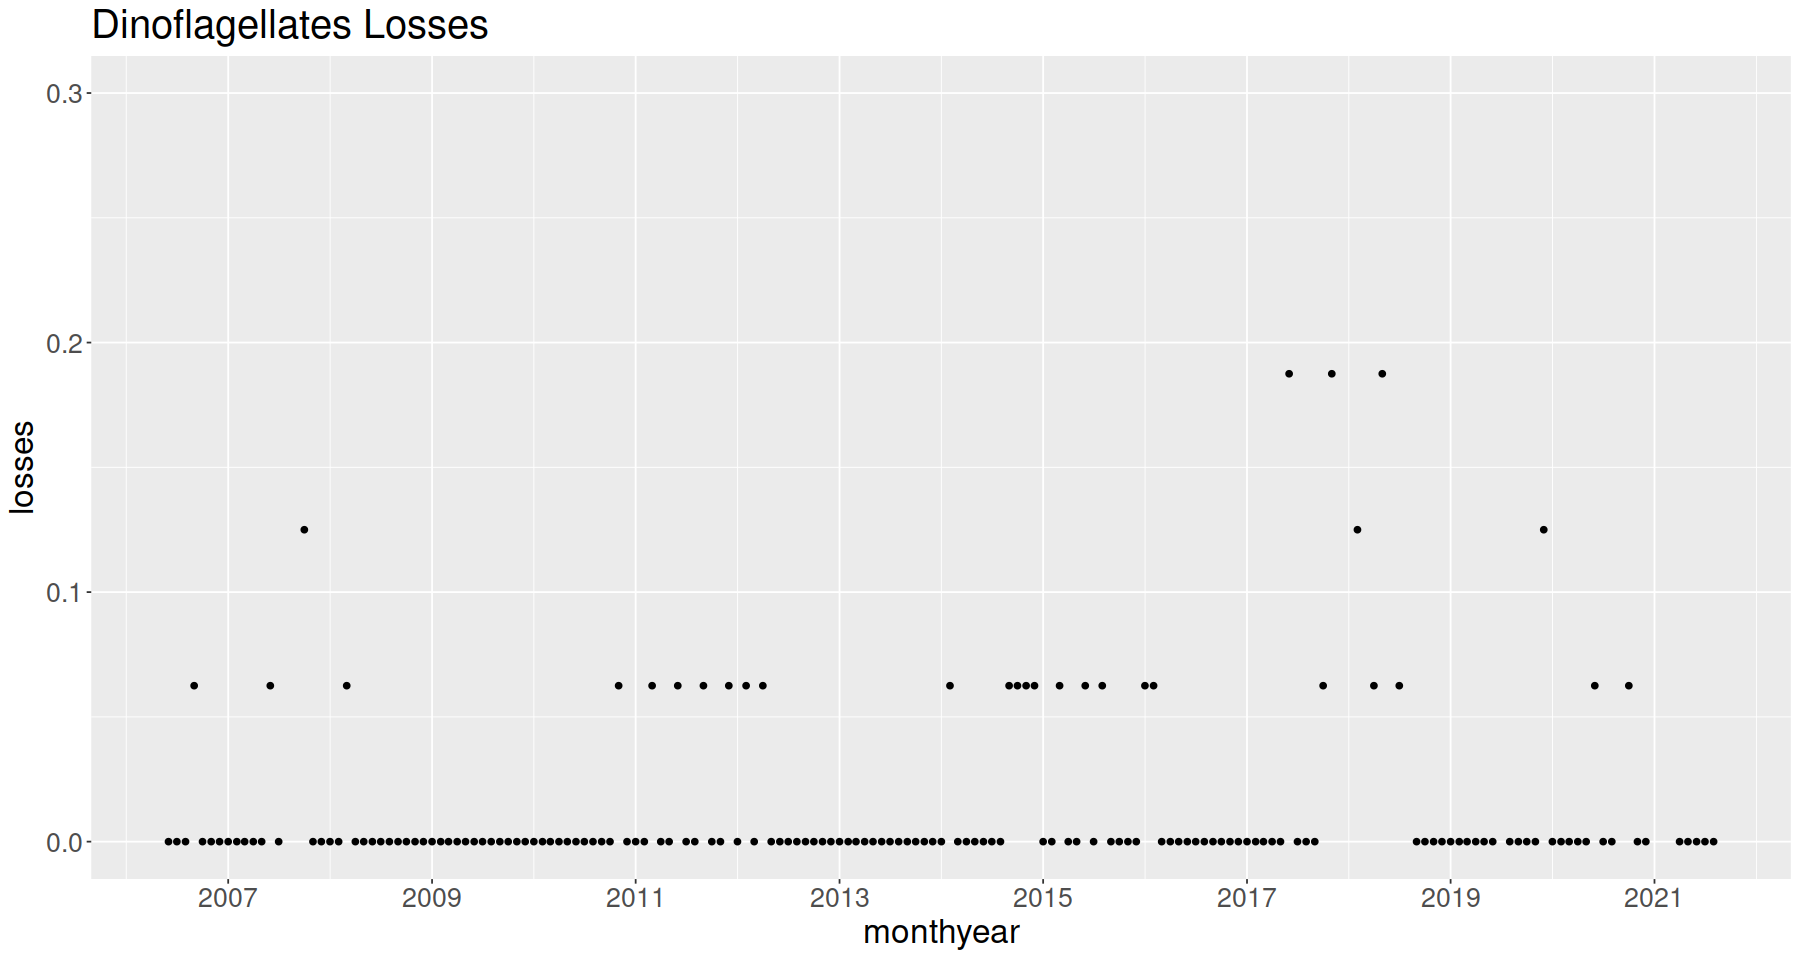

In [37]:
plotgroup("Dinoflagellates",fla_col)

[1] 55614


`summarise()` has grouped output by 'my'. You can override using the `.groups` argument.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


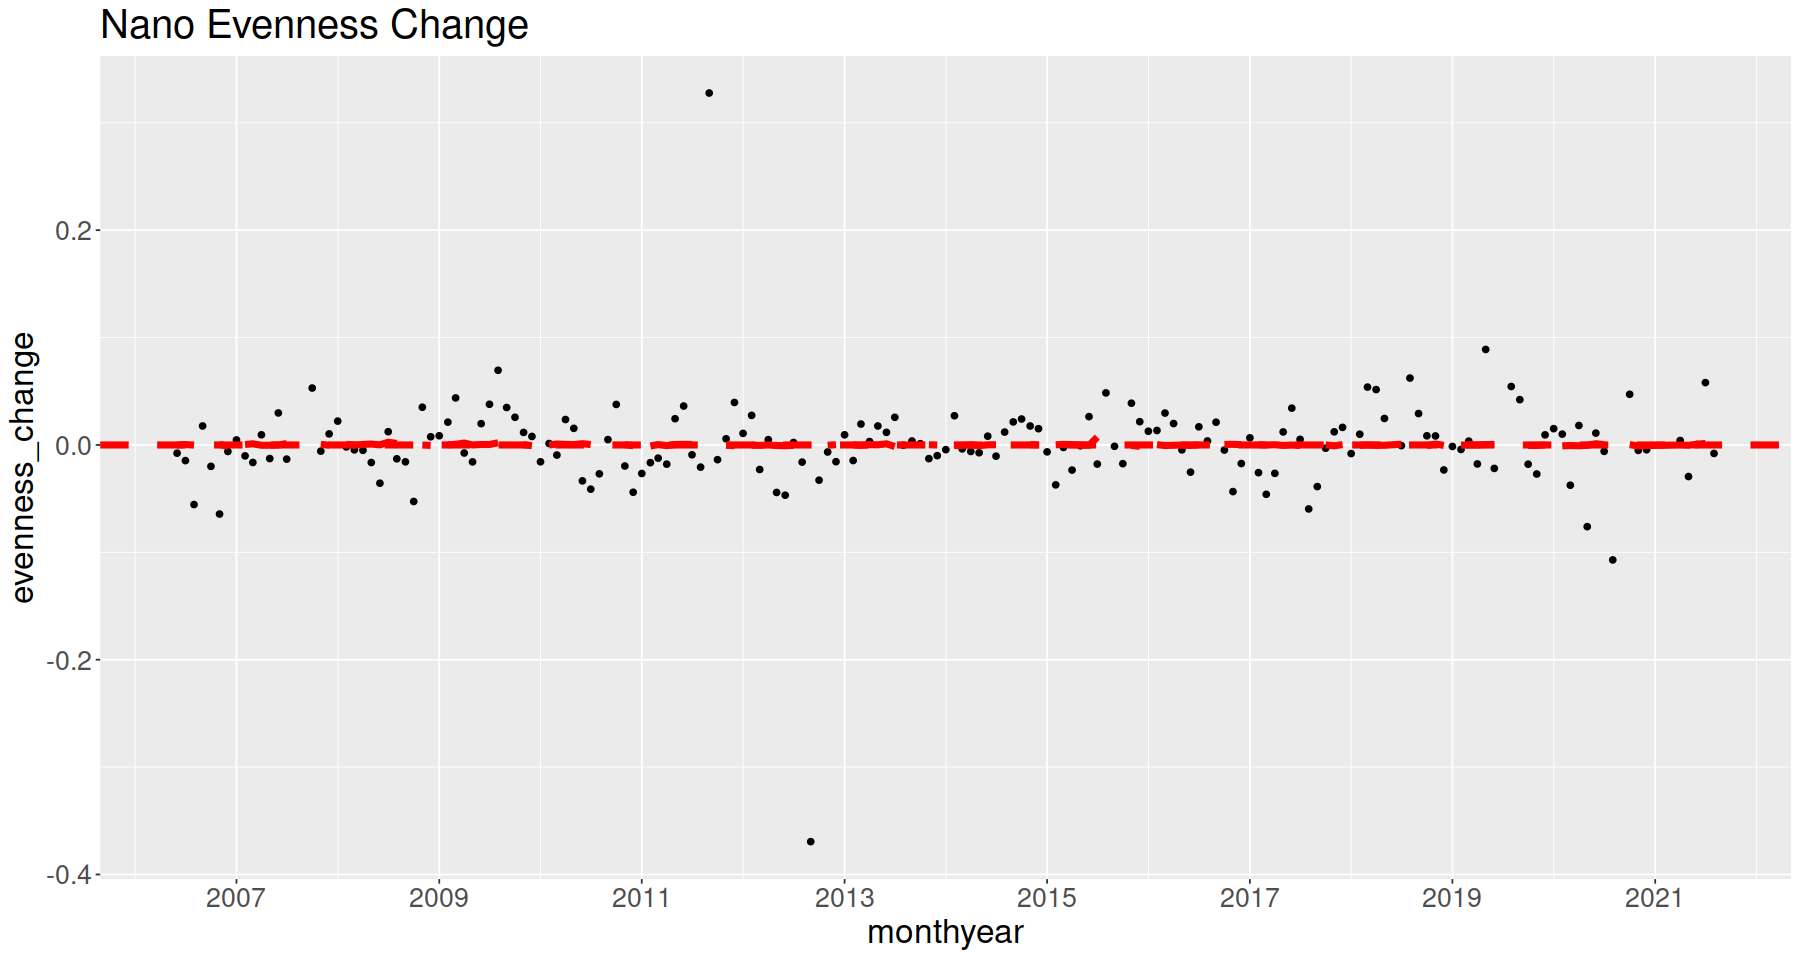

Warning message:
“Removed 1 rows containing missing values (geom_point).”


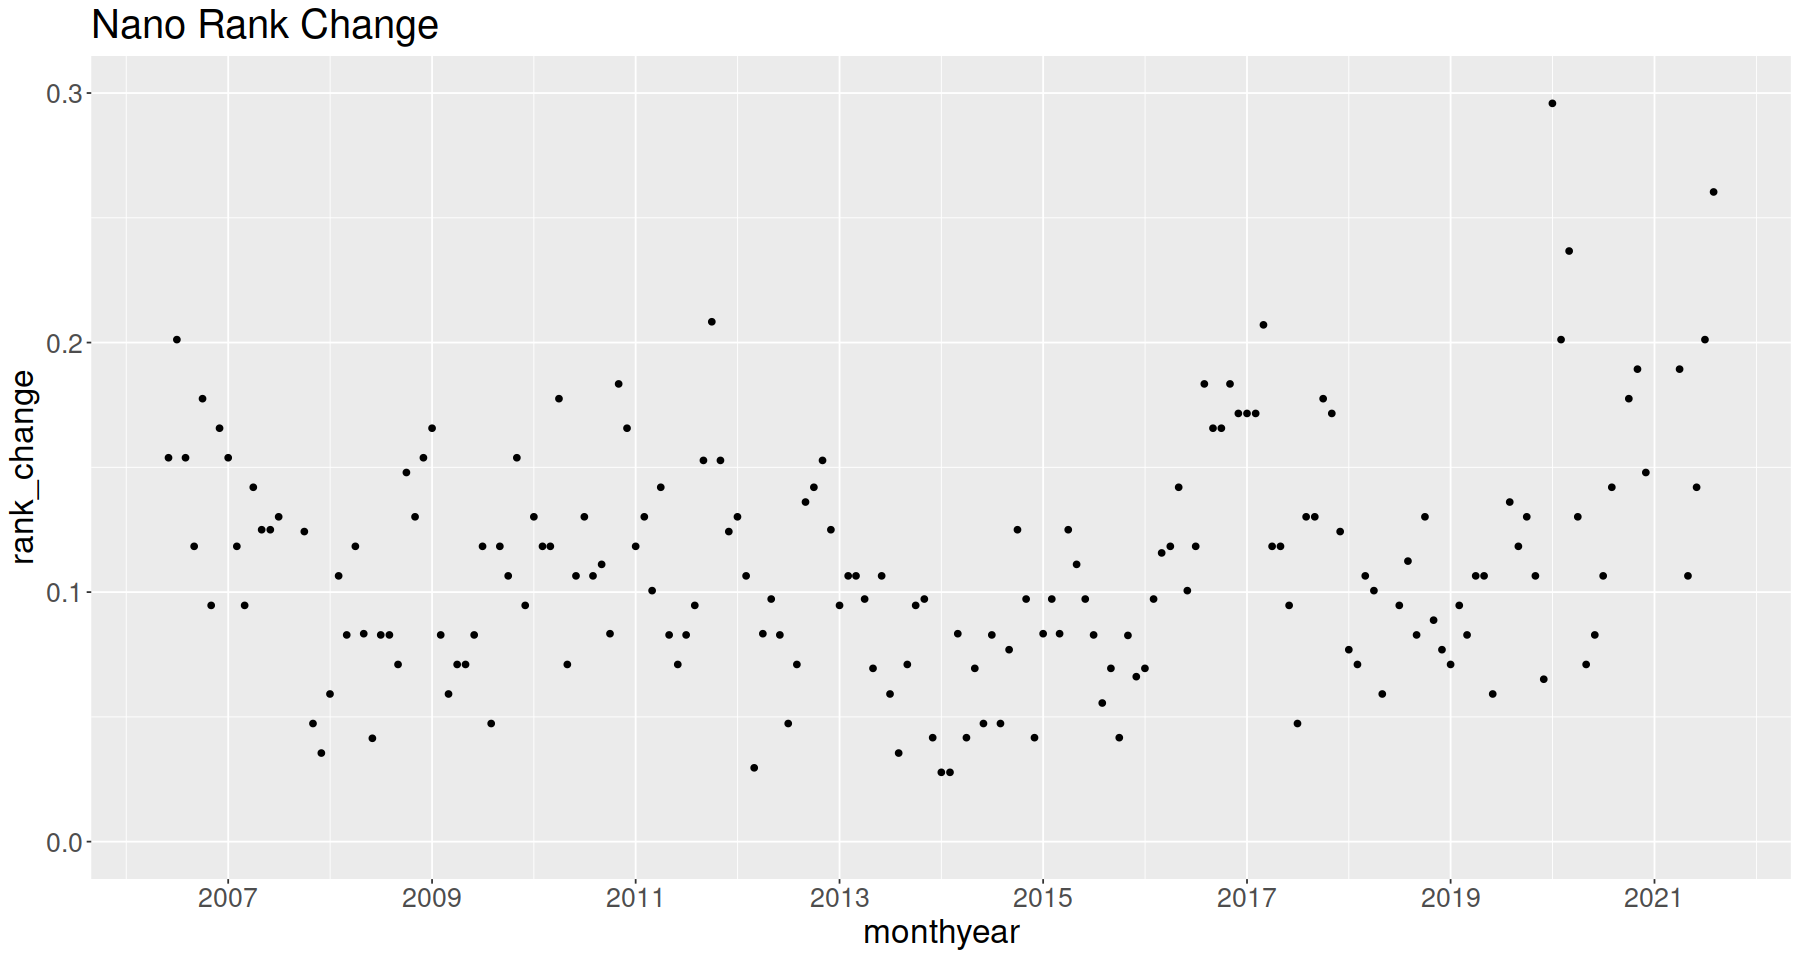

Warning message:
“Removed 1 rows containing missing values (geom_point).”


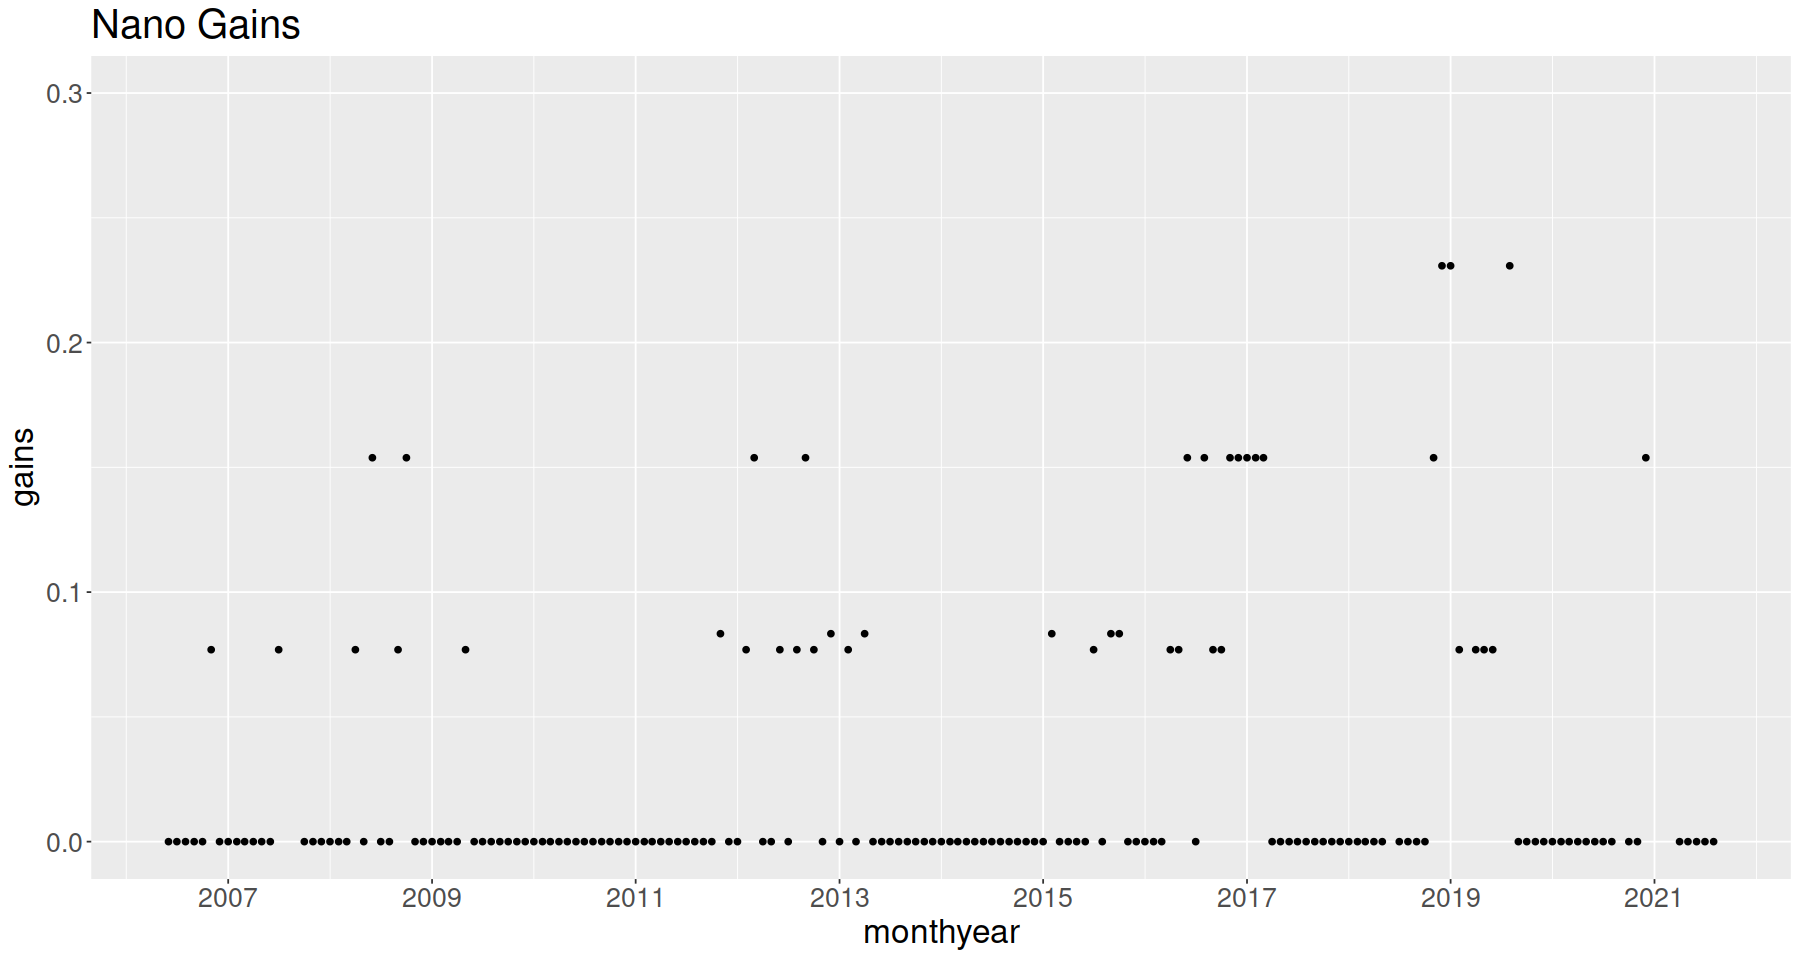

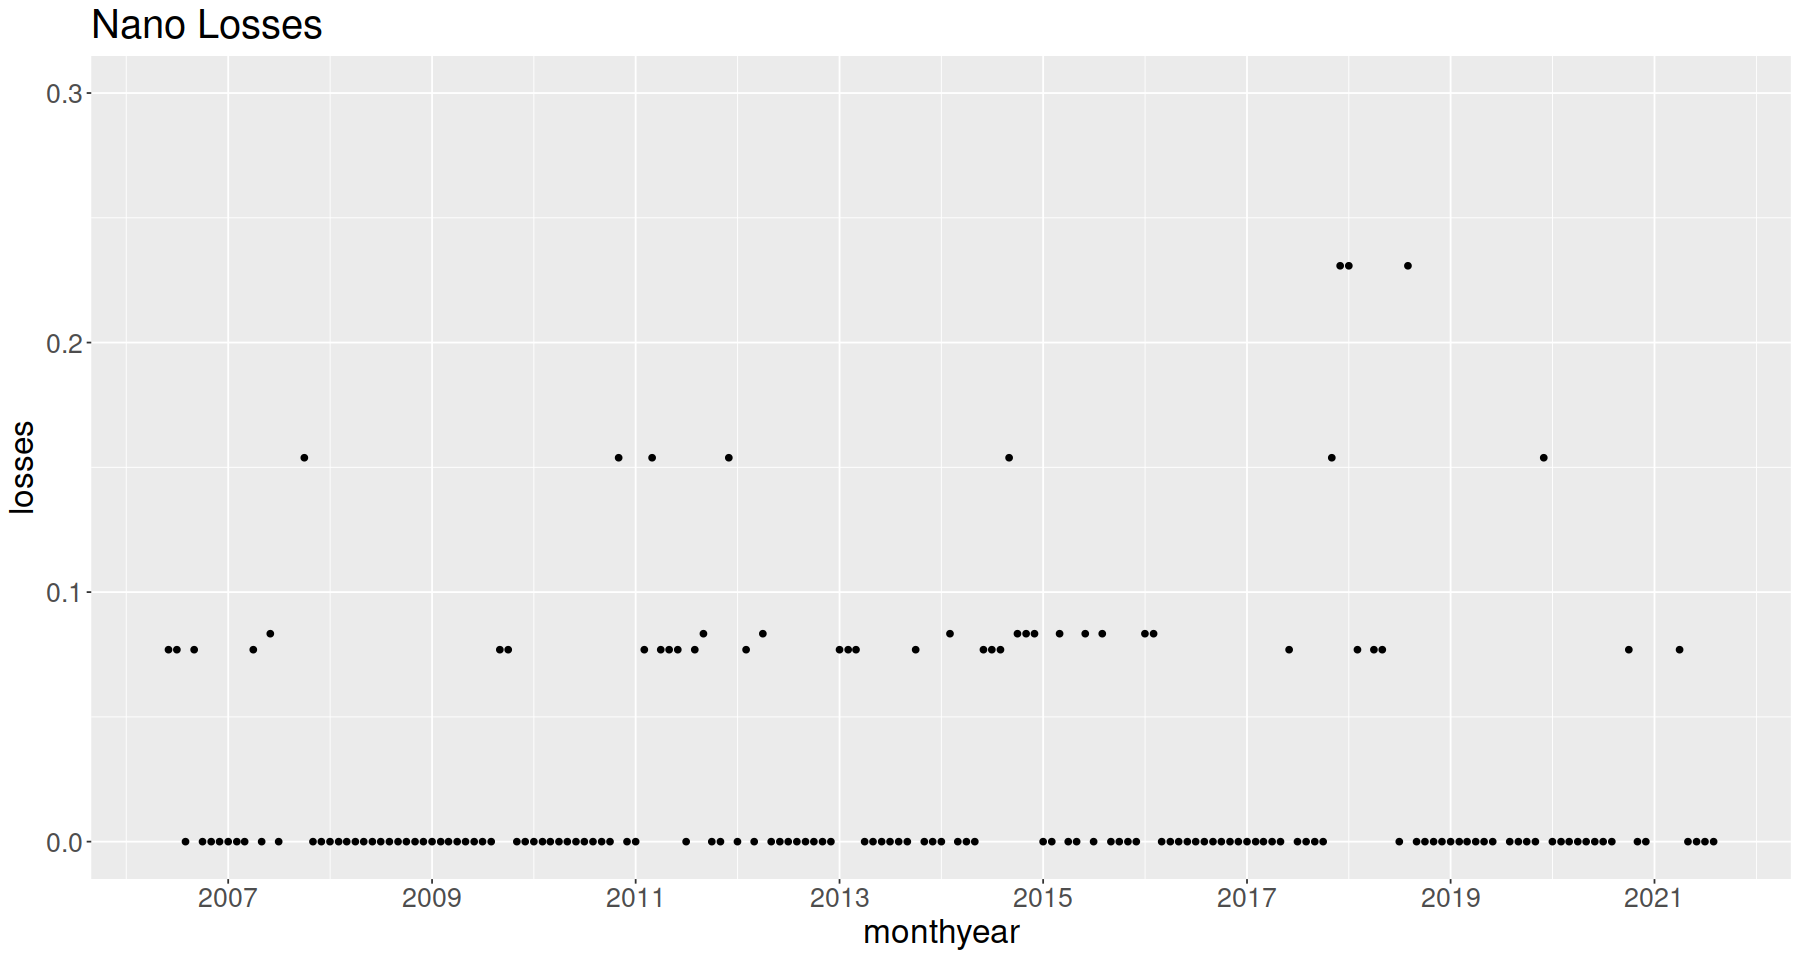

In [38]:
plotgroup("Nano",nan_col)

In [ ]:
#write code to plot RACs from scratch



## RAC_change

The library codyn has functions that are designed to use RACs:
- RAC_change()
- RAC_diffference()

They extend the existing rank_change() and turnover() functions in codyn.

RAC_change() computes

1. evenness change:

    $$ \Delta S = \frac{S_{t+1}-S_{t}}{S_{total}}$$ where 

    $S_{t} = $ richness at time t at replicate

    $S_{t+1} = $ richness at time t + 1 at same replicate

    $S_{total} =$ total number of unique species at both time periods
    
    
2. rank change:

    $$\mu_R = \frac{\sum ^N_i(|R_{i,t+1}-R_{i,t}|)}{S_{tot}},  \Delta R = \frac{\mu _R}{S_{tot}}$$
  


RAC_differrence computes species richness difference

$$ S.D. = \frac{S_x - S_y}{S_{total}}$$

$S_x$ and $S_y$ are the levels species richness at 2 replicates

$S_{total}$ is total number of unique species at both replicates.


NOTE:

$\Delta S$ and $S.D$ are proportions bound between -1 and 1.


community_structure() allows you specify 3 eveness measures.
1. inverse of Simpson's D
    - $P_i = \frac{x_i}{\sum x}$
    - $D = \sum_{x_i}^{S}P_i$
    - SimpEven = $\frac{\frac{1}{D}}{S}$ where $x_i$ is the abundance of species i
2. $E_Q$ a measure of the slope of an RAC and converts it to a 0-1 scale. if the slope is relatively flat, evenness is high and if it is steep evenness is low.

$$ E_Q = \frac{-2}{\pi*arctan(b')}$$ where $b'$ is the slope of the line fitted by a linear model of relationship between the relative rank of a species vs. its log abundance.

NOTE: This paper likes $E_Q$ bc it doesn't report an evenness of 1 if only 1 species is present like the first method and has a more normal distribution of values than $E_{var}$ .

3. $E_{var}$ a measure of the variance of abundance values normalized to 1.
    $$E_{var} = 1 - \frac{2}{\pi} a tan(\frac{s-1}{x}var(lnx))$$
    
    where s is the number of species in the sample and var is the sample variance. WHAT IS X tho???


## $\Delta RAC$ on MVCO data

In [68]:
#NOTE: DATA IS LARGE, RAN ON CLUSTER, THIS IS JUST LOCAL VERSION. DO NOT RUN LOCALLY. SEE VERSION CREATED FOR CLUSTER

options(repr.plot.width=15, repr.plot.height=8)

dfrm <- RAC_change(df = dfConc_long, 
           species.var = "species",
           abundance.var = "my.conc",
           time.var ="my")

dfrm$monthyear = as.Date(my(dfrm$my),format = "%Y-%m-%d")
typeof(dfrm$my)
head(dfrm)


[1] "integer"

my     my2    richness_change evenness_change rank_change gains     
1 1_2007 1_2008 -0.007092199    -0.0003730566   0.10799256  0.02127660
2 1_2008 1_2009  0.041958042     0.0085444354   0.08455181  0.04195804
3 1_2009 1_2010  0.000000000    -0.0049246475   0.08078635  0.00000000
4 1_2010 1_2011  0.000000000    -0.0059265575   0.08562766  0.00000000
5 1_2011 1_2012 -0.006993007    -0.0062992565   0.09809771  0.00000000
6 1_2012 1_2013 -0.049295775     0.0150898255   0.11887522  0.00000000
  losses      monthyear 
1 0.028368794 2007-01-01
2 0.000000000 2008-01-01
3 0.000000000 2009-01-01
4 0.000000000 2010-01-01
5 0.006993007 2011-01-01
6 0.049295775 2012-01-01

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

dfrm <- RAC_change(df = dfConc_long, 
           species.var = "species",
           abundance.var = "wy.conc",
           time.var ="wy")

dfrm$weekyear = as.Date(my(dfrm$wy),format = "%Y-%m-%d")
typeof(dfrm$wy)
head(dfrm)


In [71]:
head(dfConc)

datetime             milliliters_analyzed Acanthoica_quattrospina Akashiwo   
1 06-Jun-2006 21:26:01  53.2644             0.01877427              0.000000000
2 07-Jun-2006 11:58:20 244.0683             0.68833202              0.000000000
3 08-Jun-2006 12:30:33 202.7547             0.50800296              0.004932068
4 09-Jun-2006 07:29:59 145.0619             0.36536123              0.000000000
5 10-Jun-2006 15:24:26 169.4460             0.44261885              0.000000000
6 11-Jun-2006 11:57:42 245.2778             0.43216298              0.000000000
  Alexandrium_catenella Amphidinium Amylax      Apedinella
1 0.000000000           0.000000000 0.000000000 0.1126456 
2 0.020486072           0.020486072 0.008194429 0.3892354 
3 0.004932068           0.004932068 0.014796203 0.4488182 
4 0.000000000           0.013787216 0.000000000 0.2550635 
5 0.000000000           0.011803169 0.017704754 0.2655713 
6 0.000000000           0.020385046 0.004077009 0.1386183 
  Asterionellopsis_glacialis Bacillaria  ⋯ cryptophyta flagellate
1 0.05632280                 0.000000000 ⋯  0.4130339  19.33749  
2 0.24583286                 0.004097214 ⋯ 29.2786941  76.08937  
3 0.17262237                 0.000000000 ⋯ 24.8625528  73.44835  
4 0.08961691                 0.006893608 ⋯ 28.4774952  57.45133  
5 0.12393328                 0.005901585 ⋯ 30.6587325  48.91824  
6 0.18346541                 0.000000000 ⋯ 43.1755276  48.14540  
  flagellate_morphotype1 flagellate_morphotype3 pennate  
1 0.01877427             2.196589               0.6195508
2 0.36465208             4.445478               3.4949239
3 0.38470127             8.187232               4.2366461
4 0.54459504             6.342119               4.8806746
5 0.83802503             5.417655               4.9632327
6 0.72163063             6.013589               5.7322750
  pennate_Pseudo.nitzschia pennate_Thalassionema pennate_morphotype1
1 0.00000000               0.000000000           0.000000000        
2 0.09423593               0.004097214           0.004097214        
3 0.07398101               0.009864135           0.004932068        
4 0.02068082               0.000000000           0.041361649        
5 0.01770475               0.000000000           0.011803169        
6 0.03261607               0.000000000           0.020385046        
  shellfish_larvae zooplankton
1 0.000000000      0.018774267
2 0.000000000      0.008194429
3 0.000000000      0.024660338
4 0.006893608      0.006893608
5 0.000000000      0.005901585
6 0.004077009      0.032616074

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


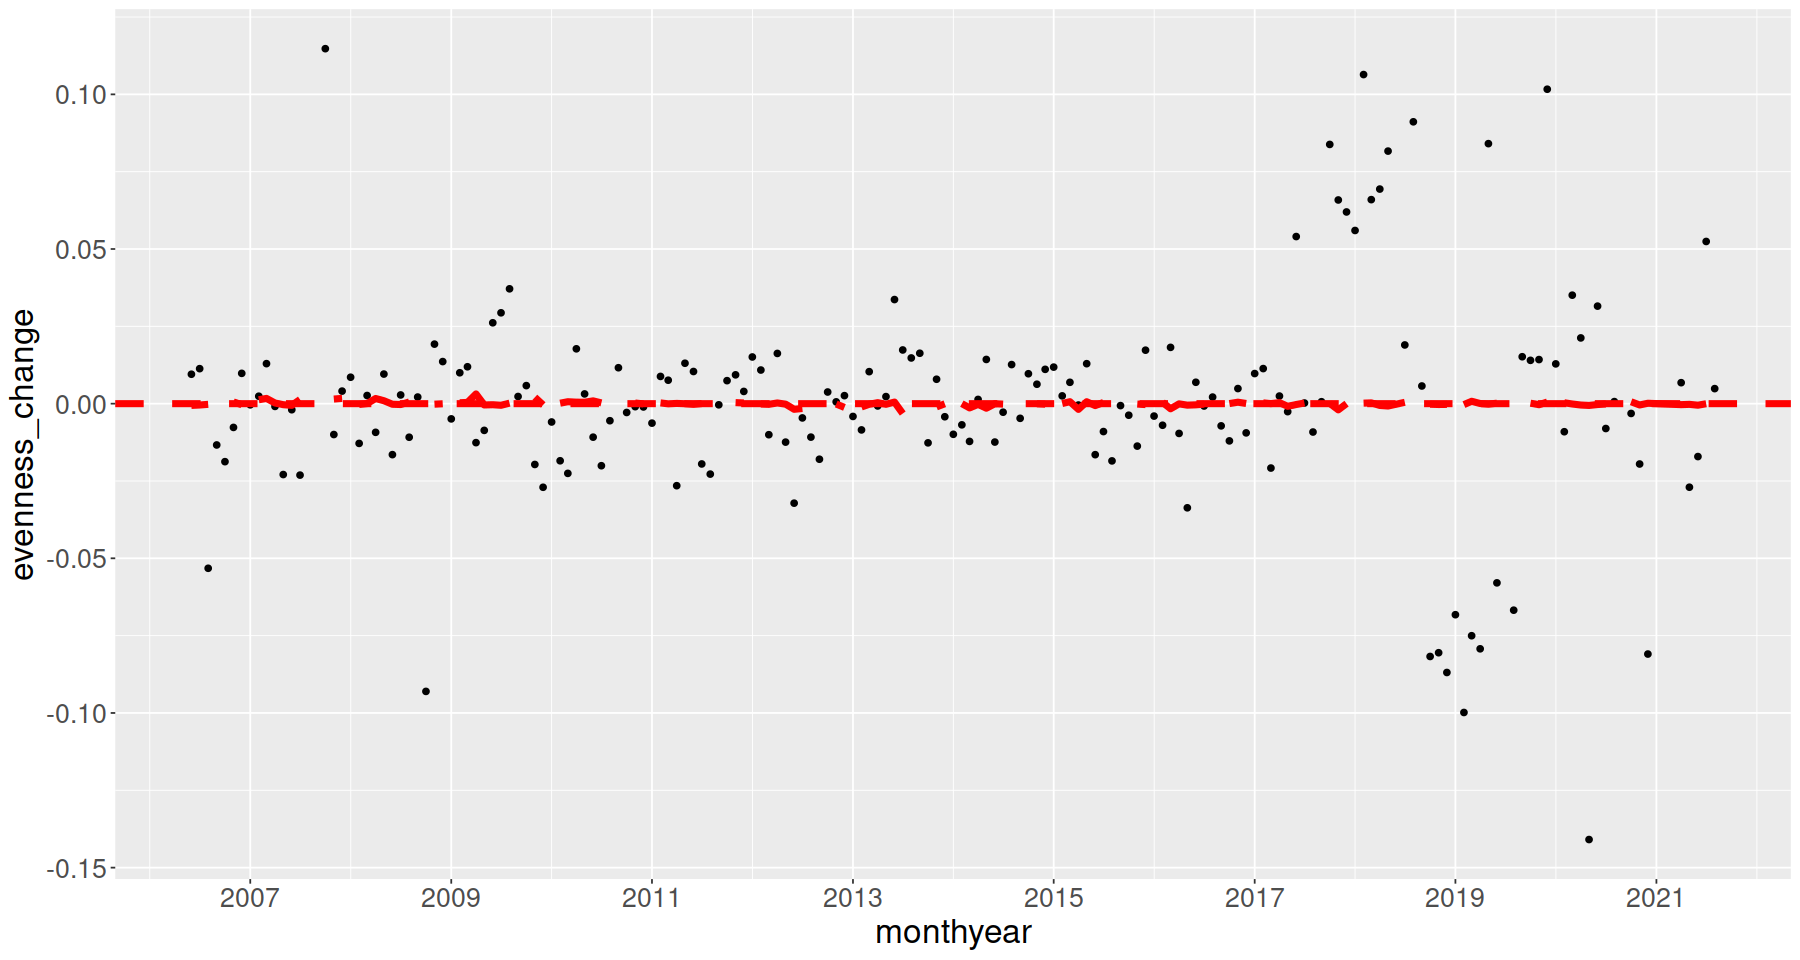

Warning message:
“Removed 11 rows containing missing values (geom_point).”


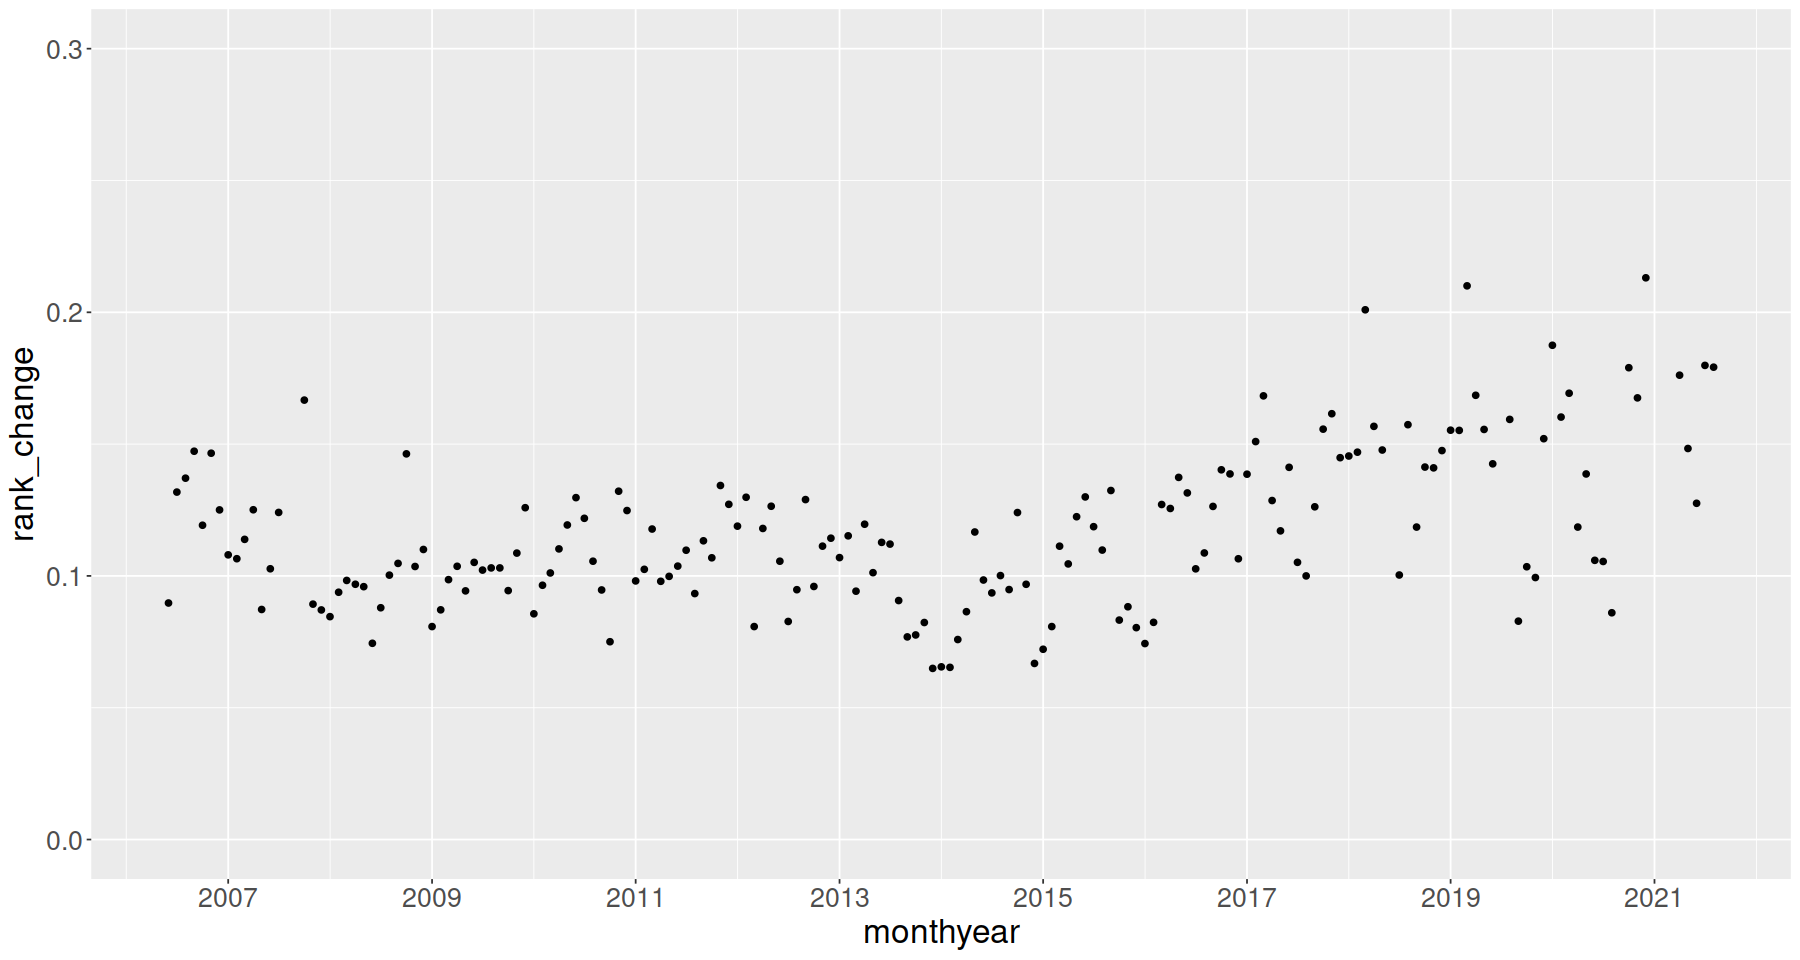

Warning message:
“Removed 11 rows containing missing values (geom_point).”


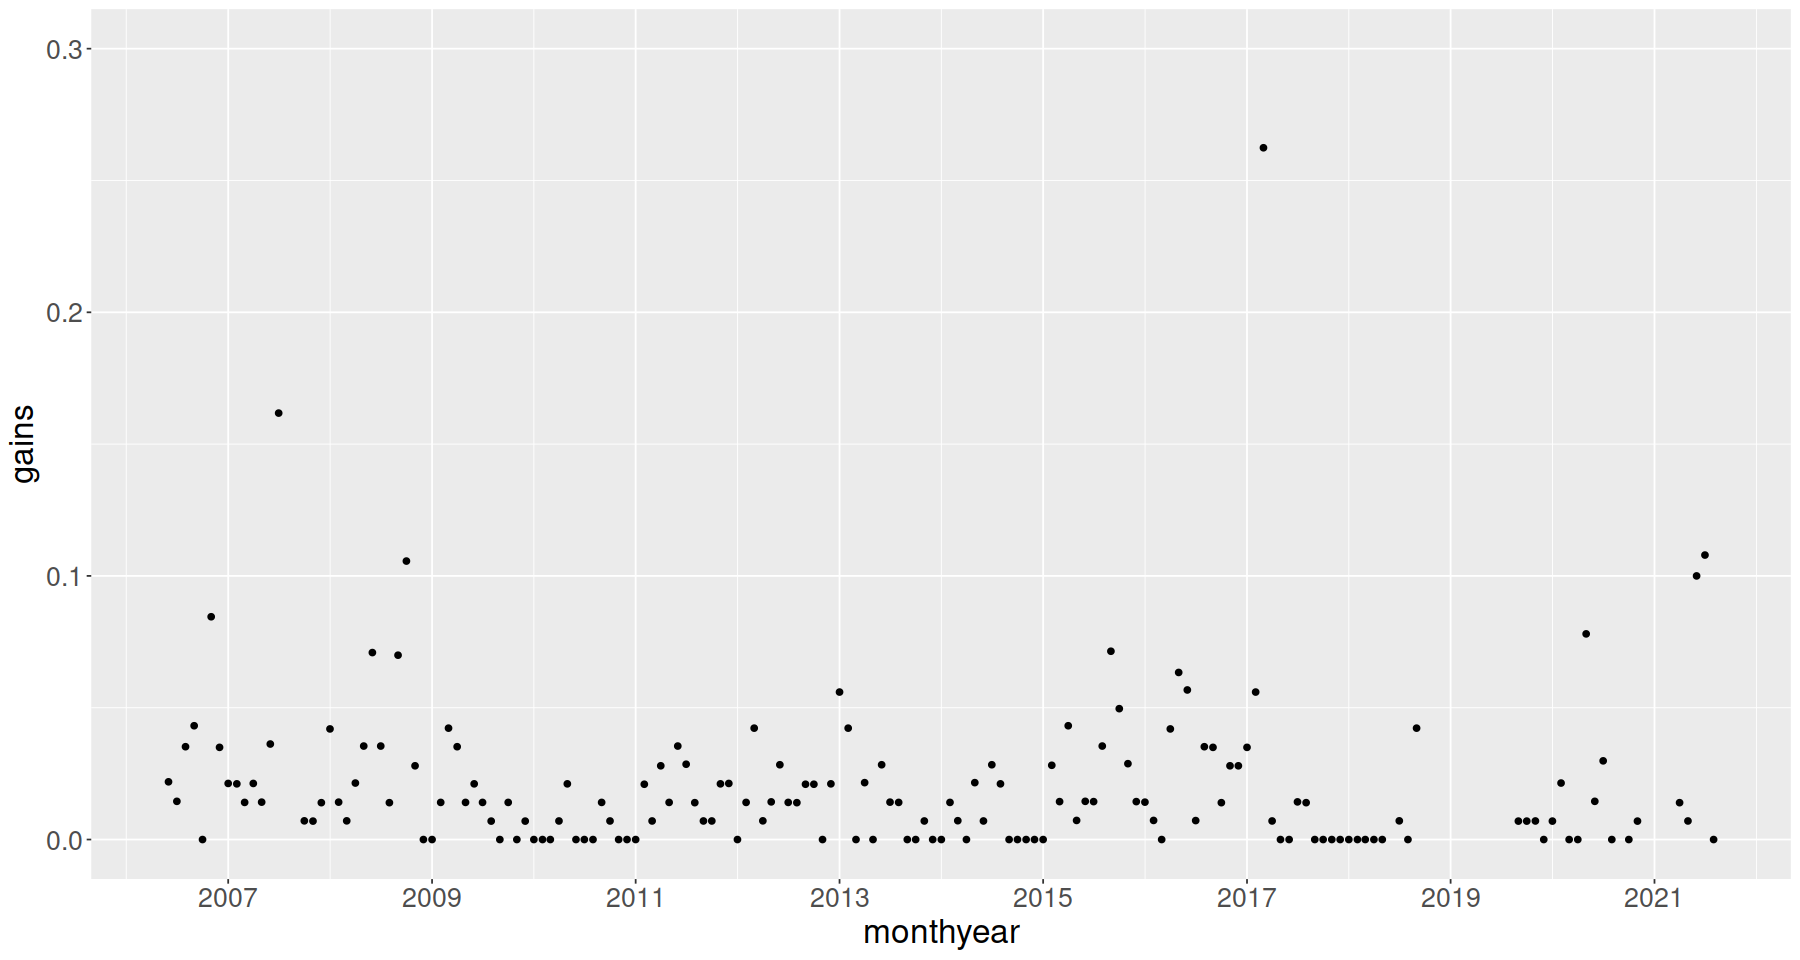

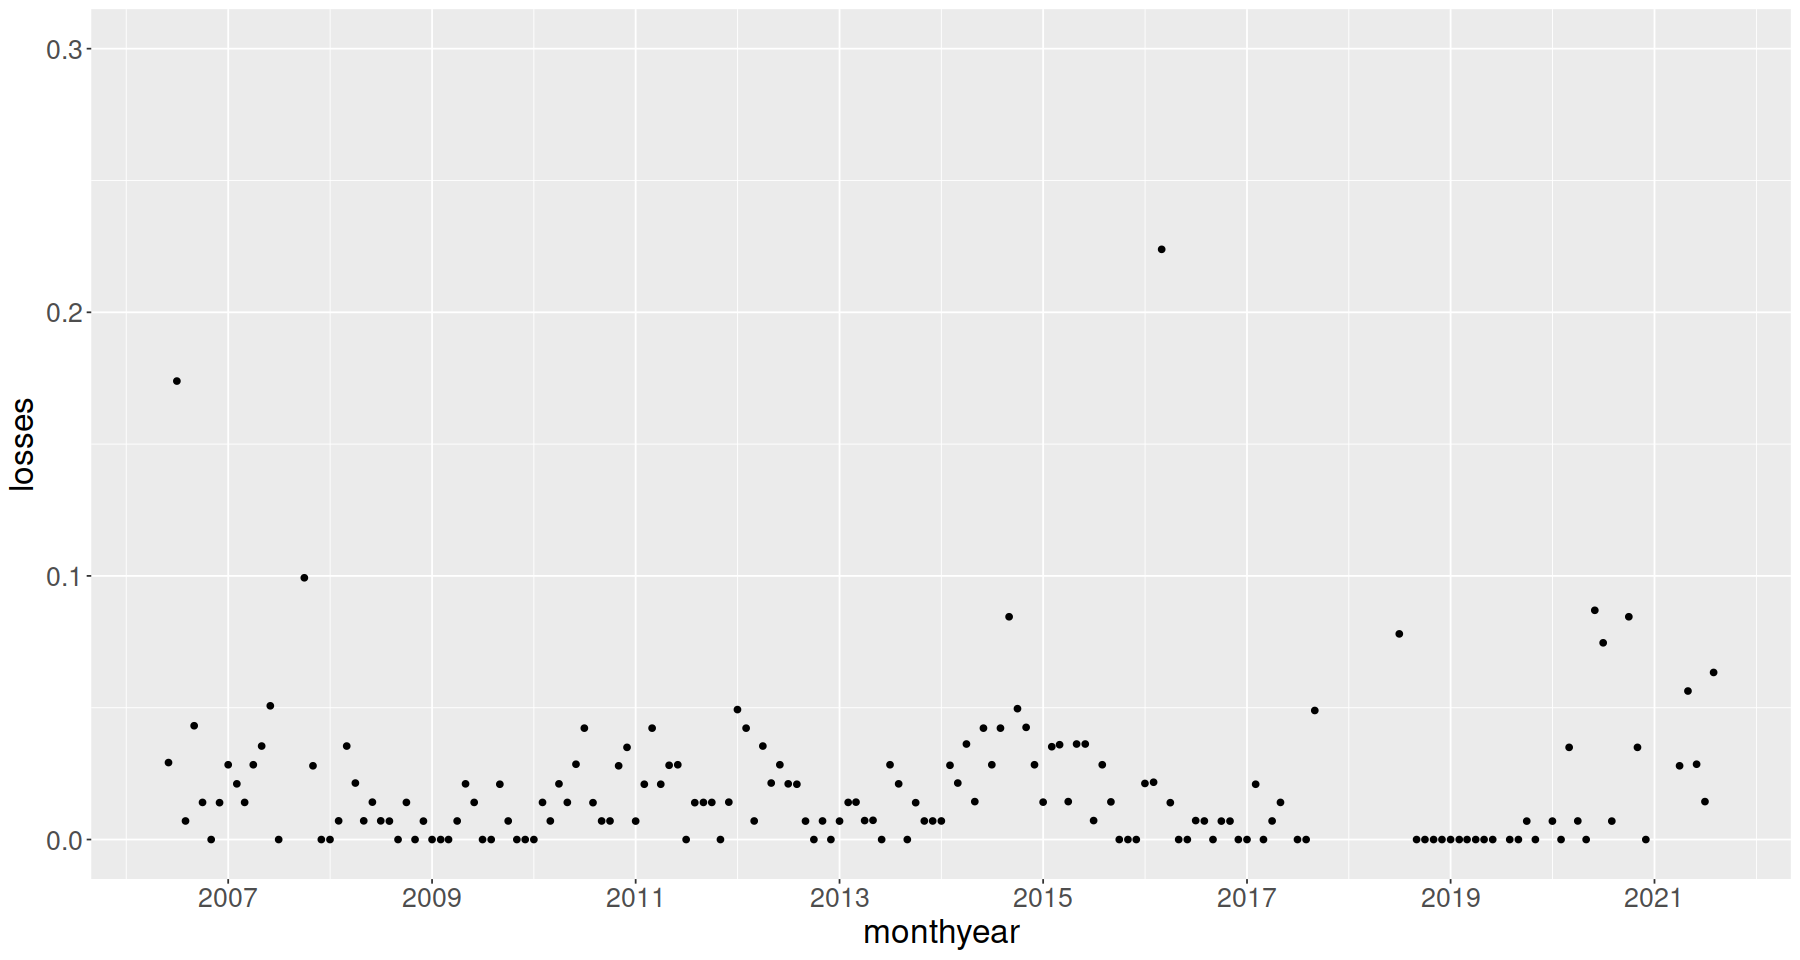

In [80]:
# plotting evenness change
ggplot(data = dfrm,aes(x = monthyear, y = evenness_change)) +
geom_point()+
geom_hline(yintercept = 0,
           linetype = "dashed",
           color = "red",
           size = 2)+
    theme(text = element_text(size=20))+
  geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = rank_change)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = gains)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)


# plotting rank change
ggplot(data = dfrm,aes(x = monthyear, y = losses)) +
geom_point()+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 3, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "2 year", labels=date_format("%Y"))+
ylim(0,0.3)

1. plot rank abundance curve at each time point
2. plot rank change for each species over time?

TAKE INTO ACCOUNT MISSING DATA POINTS

### Results of RAC_change analysis

X mdy      mdy2     richness_change evenness_change rank_change gains losses
1 1 1_1_2007 1_1_2008 0                0.013706833    0.03305785  0     0     
2 2 1_1_2008 1_1_2009 0               -0.044177711    0.16528926  0     0     
3 3 1_1_2009 1_1_2010 0                0.015966852    0.09917355  0     0     
4 4 1_1_2010 1_1_2011 0               -0.002151787    0.06611570  0     0     
5 5 1_1_2011 1_1_2012 0                0.034369745    0.08264463  0     0     
6 6 1_1_2012 1_1_2013 0                0.007566854    0.08264463  0     0     
  date      
1 2007-01-01
2 2008-01-01
3 2009-01-01
4 2010-01-01
5 2011-01-01
6 2012-01-01

Warning message:
“Removed 126 rows containing missing values (geom_point).”
Warning message:
“Removed 7 row(s) containing missing values (geom_path).”


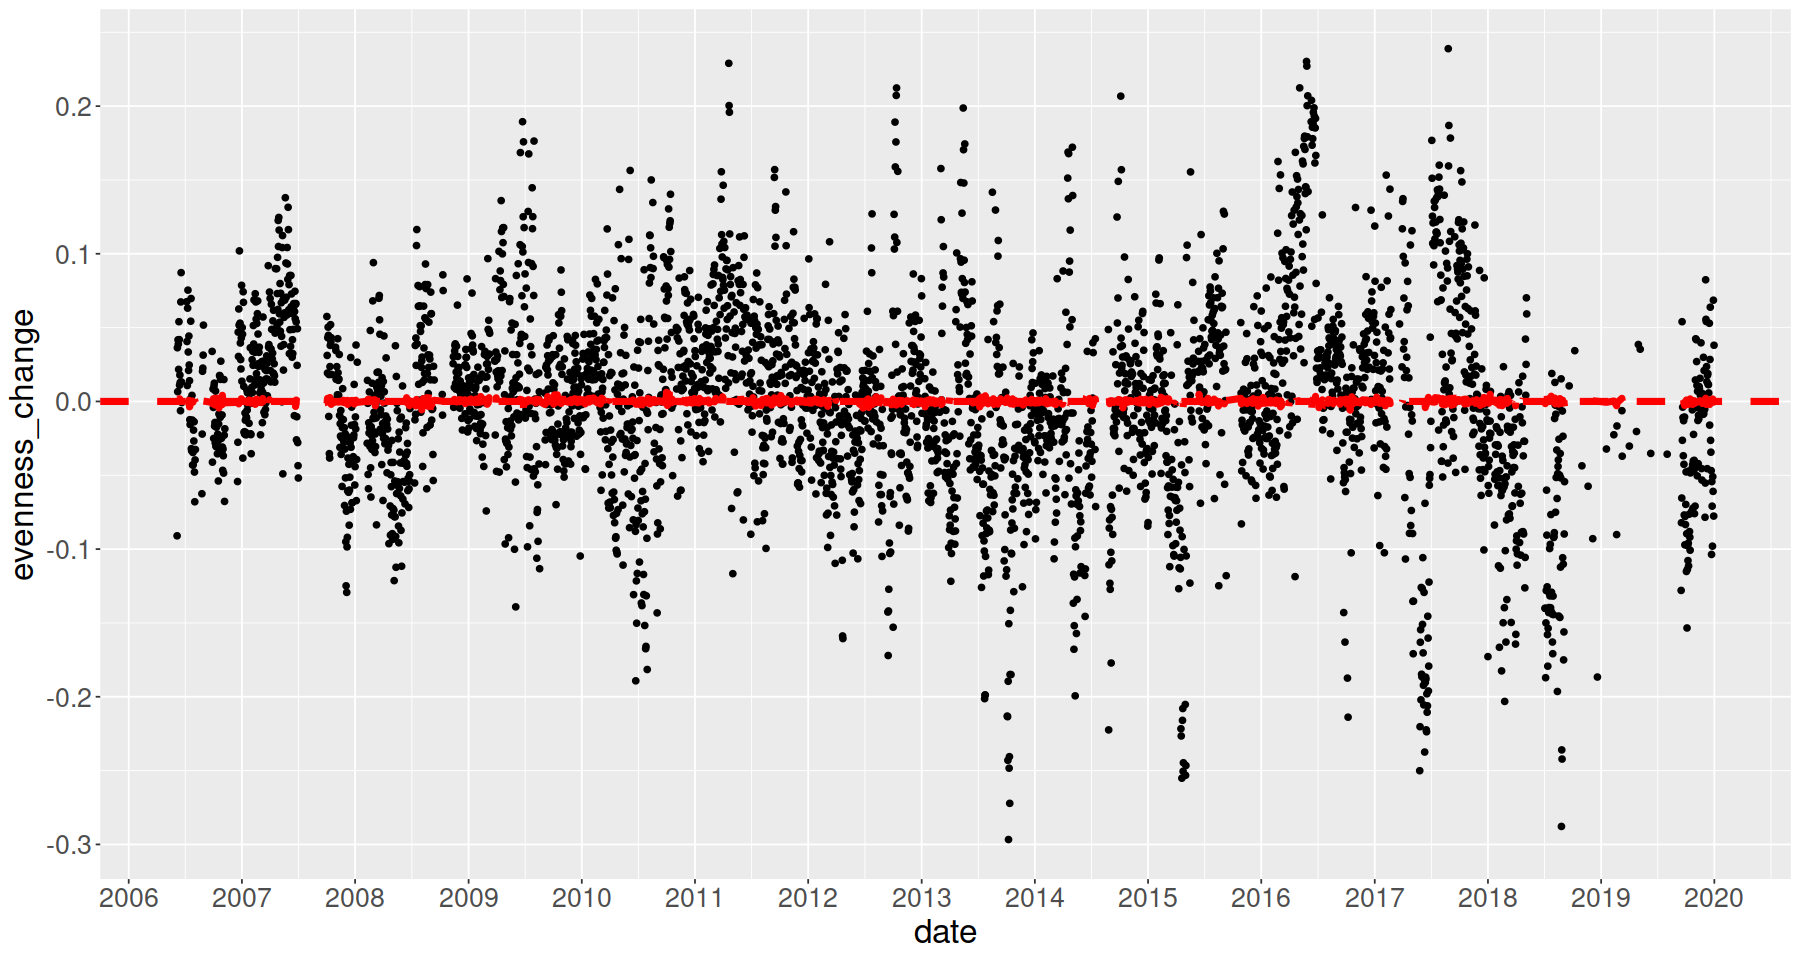

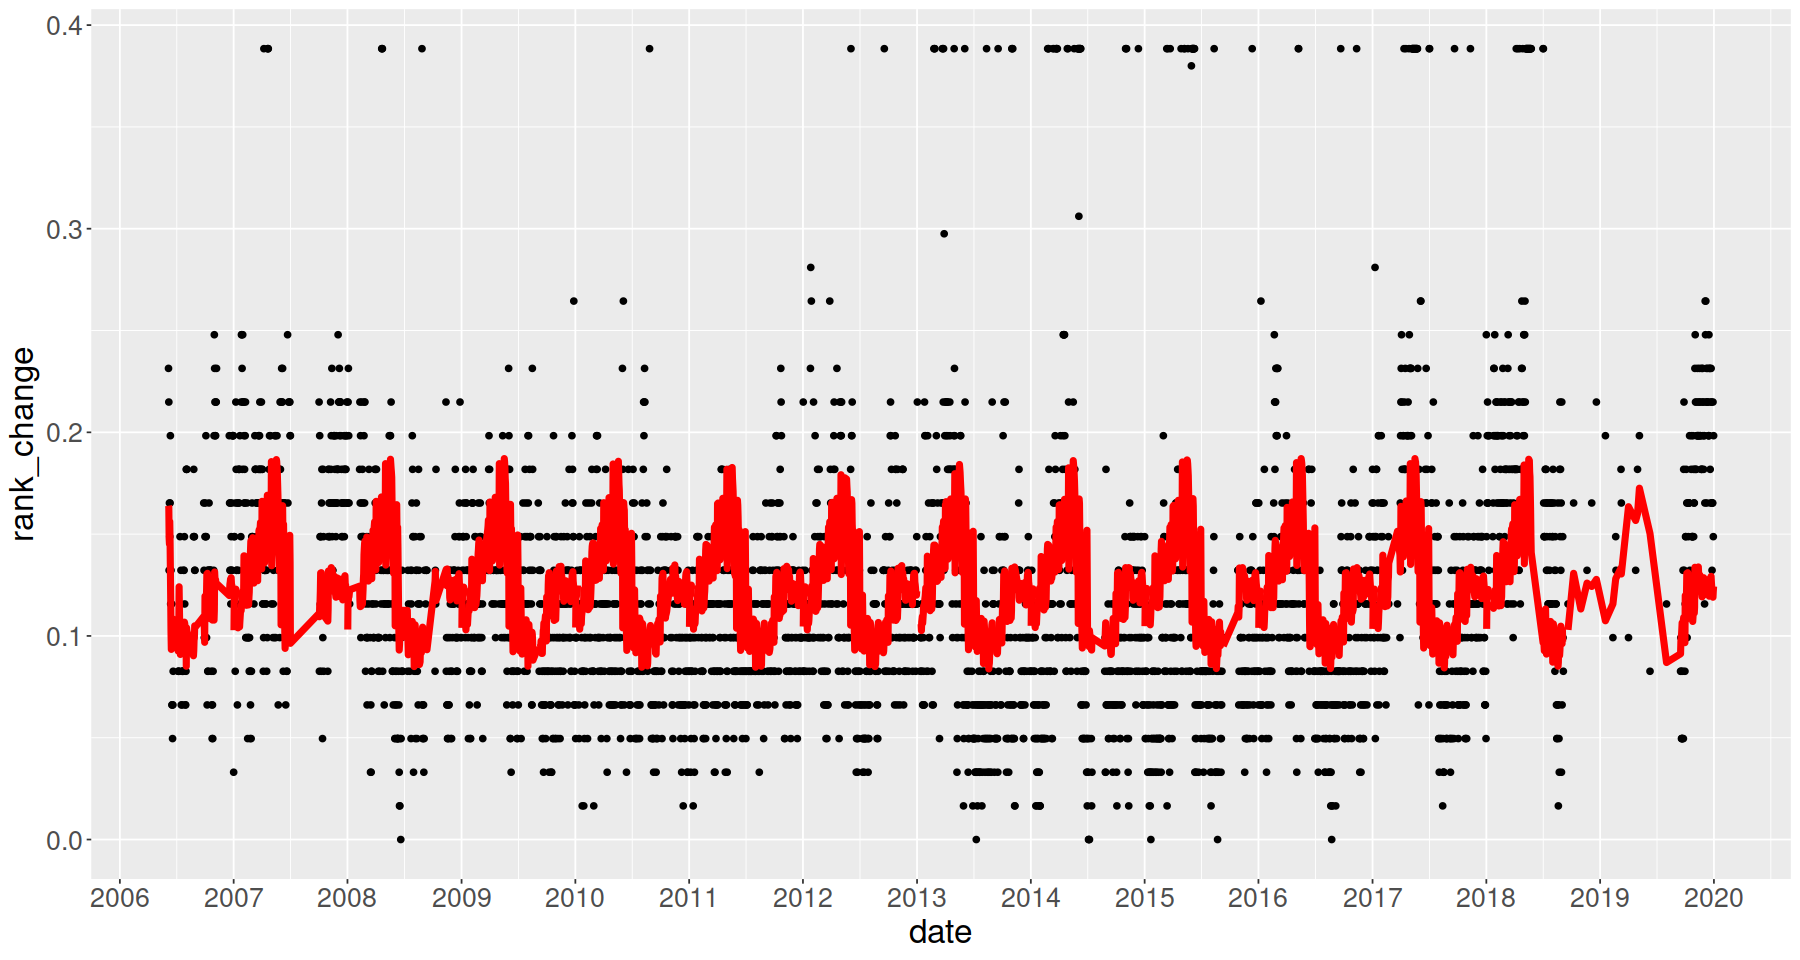

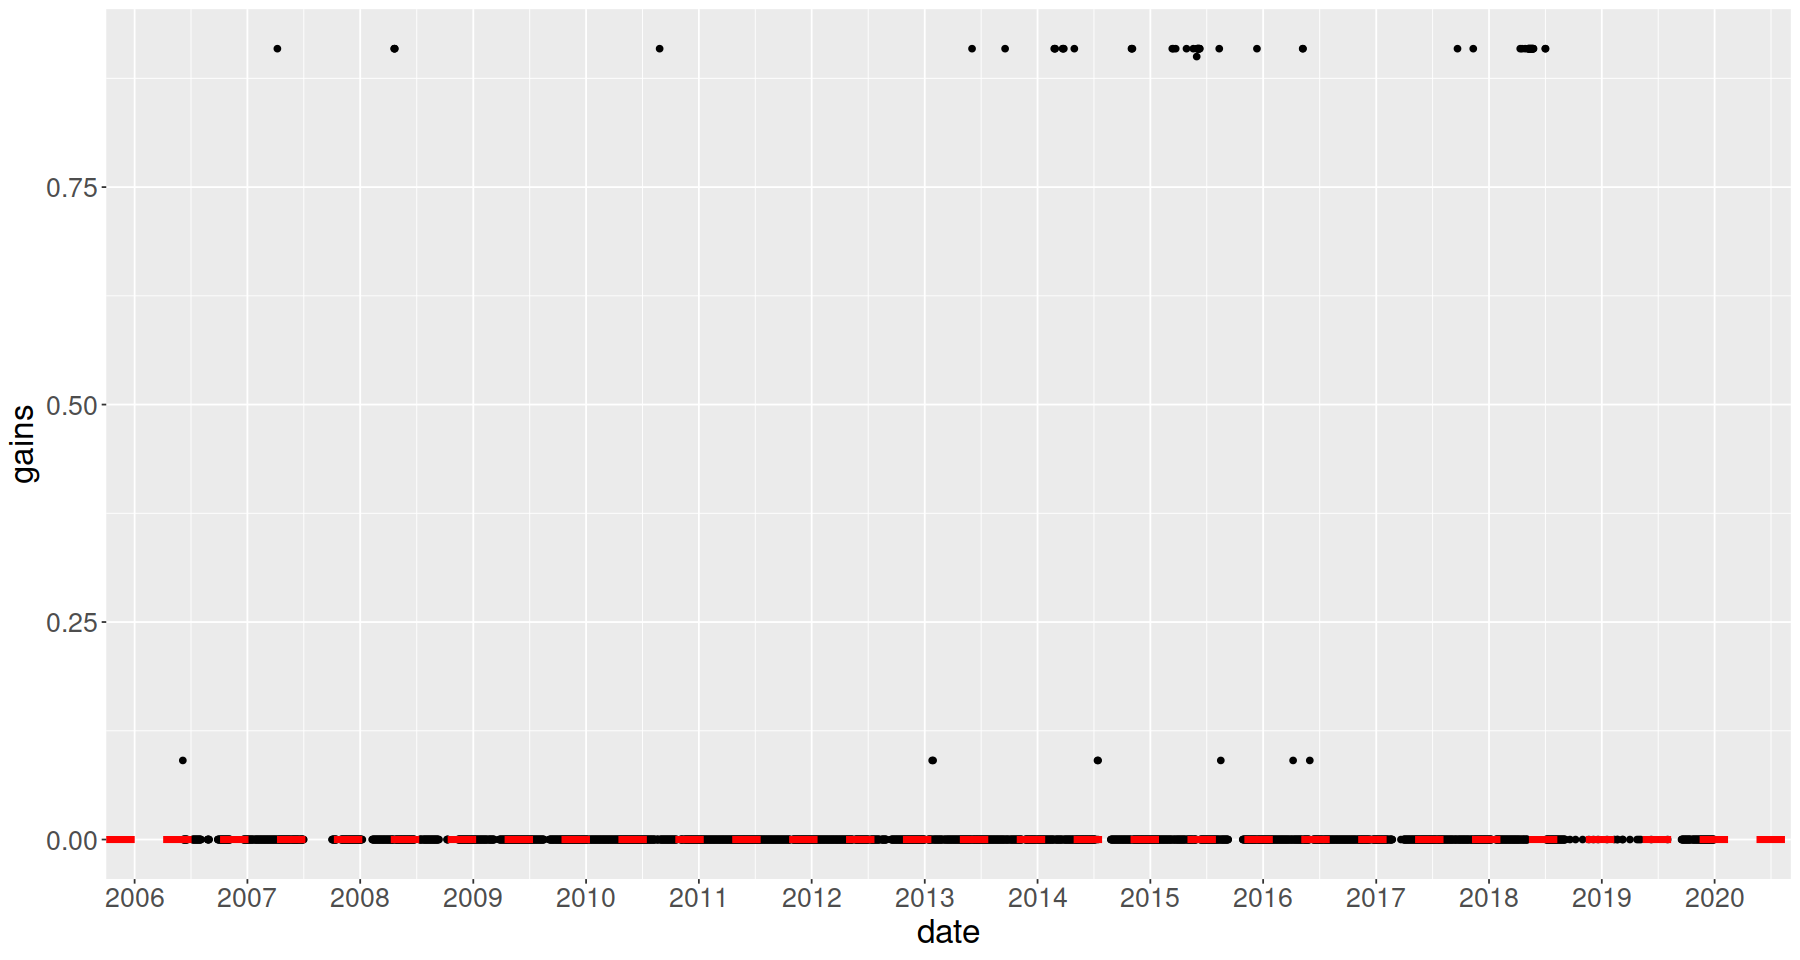

In [87]:
dfr = read.csv("/D/MIT-WHOI/data/2021/codyn_output/outputRAC_func.csv")
dfr$date = as.Date(dfr$mdy,format = "%m_%d_%Y")
head(dfr)

options(repr.plot.width=15, repr.plot.height=8)

#plotting evenness change
ggplot(data = dfr,aes(x = date, y = evenness_change)) +
geom_point()+
geom_hline(yintercept = 0,
           linetype = "dashed",
           color = "red",
           size = 2)+
    theme(text = element_text(size=20))+
  geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))




#plotting evenness change
ggplot(data = dfr,aes(x = date, y = rank_change)) +
geom_point()+
    theme(text = element_text(size=20))+
  geom_line(aes(y=rollmean(rank_change, 100, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))


ggplot(data = dfr,aes(x = date, y = gains)) +
geom_point()+
geom_hline(yintercept = 0,linetype = "dashed",color = "red", size = 2)+
    theme(text = element_text(size=20))+
#   geom_line(aes(y=rollmean(evenness_change, 50, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))




In [66]:
length(dfr$X)
length(dfFunc_long$mdy)
# length(dfFunc_long$year)




[1] 3973

[1] 43072

X mdy      mdy2     richness_change evenness_change rank_change gains losses
1 1 1_1_2007 1_1_2008 0                0.013706833    0.03305785  0     0     
2 2 1_1_2008 1_1_2009 0               -0.044177711    0.16528926  0     0     
3 3 1_1_2009 1_1_2010 0                0.015966852    0.09917355  0     0     
4 4 1_1_2010 1_1_2011 0               -0.002151787    0.06611570  0     0     
5 5 1_1_2011 1_1_2012 0                0.034369745    0.08264463  0     0     
6 6 1_1_2012 1_1_2013 0                0.007566854    0.08264463  0     0     
  date      
1 2007-01-01
2 2008-01-01
3 2009-01-01
4 2010-01-01
5 2011-01-01
6 2012-01-01

## Comparing RAC curves


1. relative rank
2. cummulative community abundance
3. then a plot is made of relative rank vs. cummulative abundance is plotted with stepwise fuction ($f_{k,t}(r)$ for relative rank r of the community at location k and the time t.

$$\Delta Curve = \sum_{i =1}^{N}| f_{k,t}(r_i)-f_{k,t+1}(r_i)|(r_i - r_{i-1})$$

where N = number of unique relative ranks
r = sor

In [74]:
dfc = read.csv("/D/MIT-WHOI/data/2021/codyn_output/output_curve_change.csv")
head(dfc)
dfc$date = as.Date(dfc$mdy,format = "%m_%d_%Y")

X     mdy      mdy2     curve_change
1  3975 1_1_2007 1_1_2008  768375.9   
2  7950 1_1_2008 1_1_2009  987721.9   
3 11925 1_1_2009 1_1_2010  769280.9   
4 15900 1_1_2010 1_1_2011 1330072.3   
5 19875 1_1_2011 1_1_2012 2637322.6   
6 23850 1_1_2012 1_1_2013 3718189.0

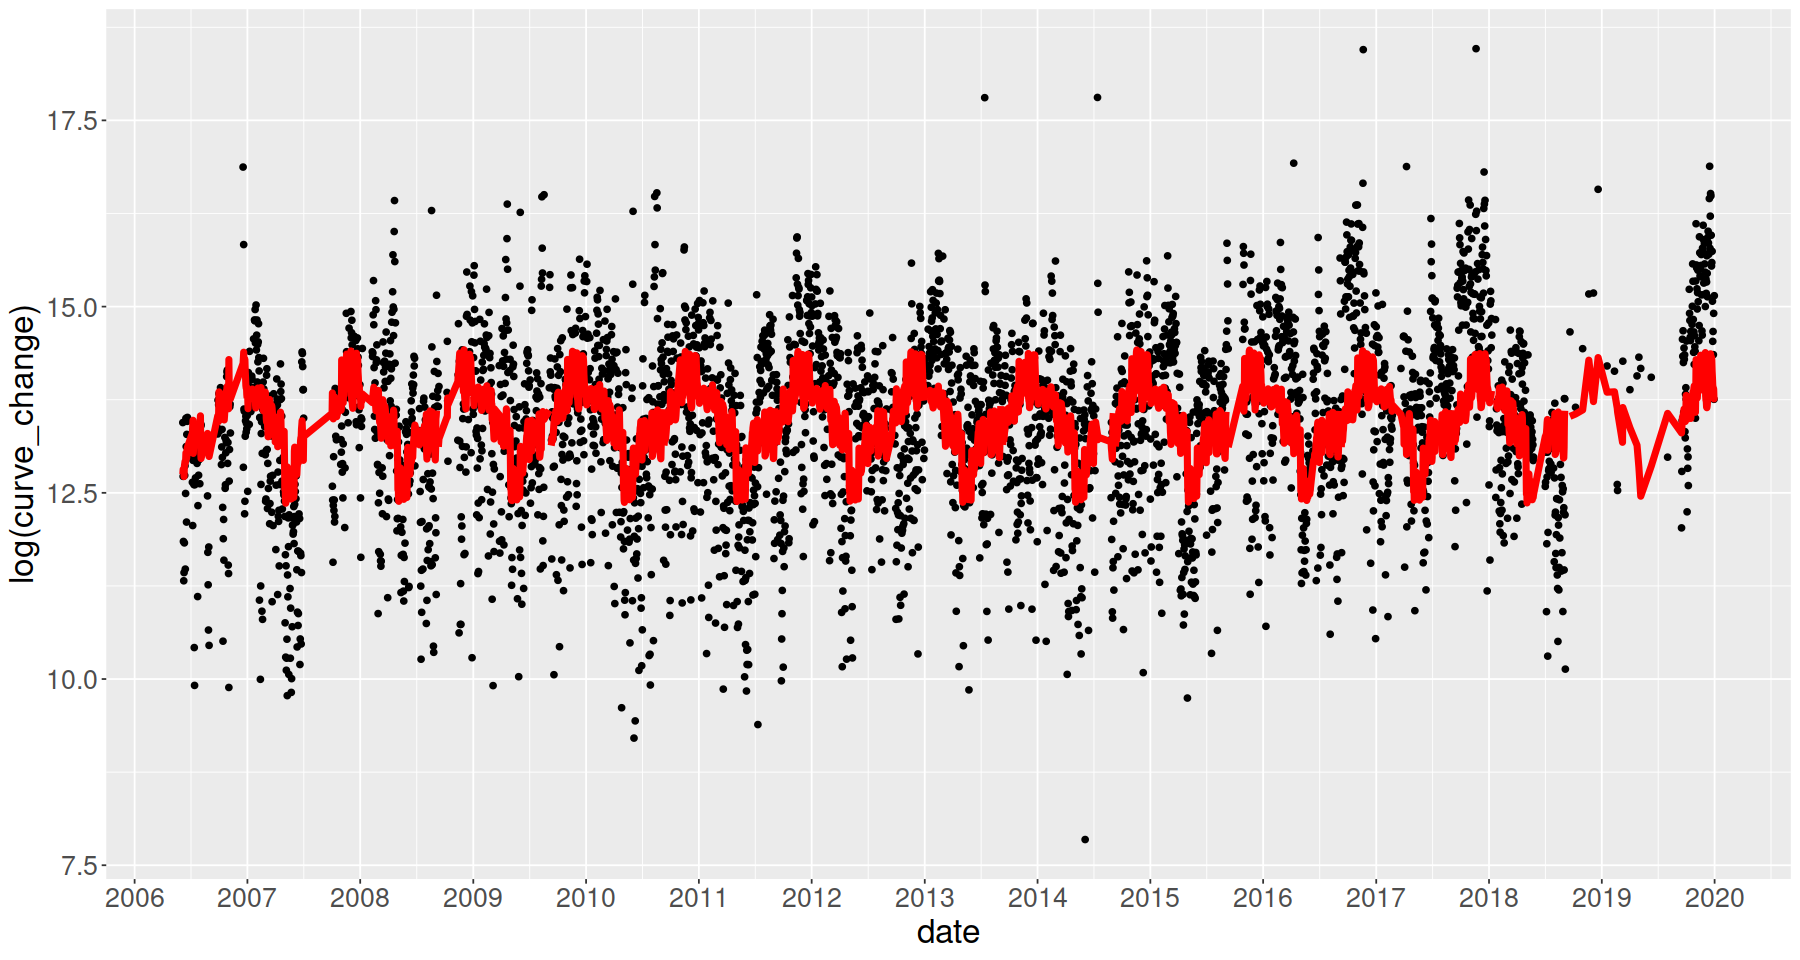

In [76]:
ggplot(data = dfc, aes(x = date, y = log(curve_change))) +
geom_point()+
theme(text = element_text(size=20))+
  geom_line(aes(y=rollmean(log(curve_change), 100, na.pad=TRUE)),color = "red",size = 2)+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))


### Mutivariate composition comparisions

1. Distance between centroids
2. dispersion around centroids

In [ ]:
multivariate_change()